# SET UP

In [70]:
! pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.6 MB/s eta 0:00:00ta 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


OLD CODE (RUN TO SETUP NOTEBOOK)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pywt
import pywt.data

In [4]:
import torch
import numpy as np
import torchvision

print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)
print("torchvision version:", torchvision.__version__)

PyTorch version: 2.4.0a0
NumPy version: 1.26.4
torchvision version: 0.19.1a0


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize to [-1, 1]
])
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
subset_size = 30_000
indices = np.random.choice(len(trainset), subset_size, replace=False)
train_subset = Subset(trainset, indices)
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
testloader  = DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)
images, labels = next(iter(trainloader))
print(f"Subset size: {len(train_subset)}")
print(f"Image batch shape: {images.shape}")
print(f"Label batch shape: {labels.shape}")

Files already downloaded and verified
Files already downloaded and verified
Subset size: 30000
Image batch shape: torch.Size([64, 3, 32, 32])
Label batch shape: torch.Size([64])


data visualization

Files already downloaded and verified


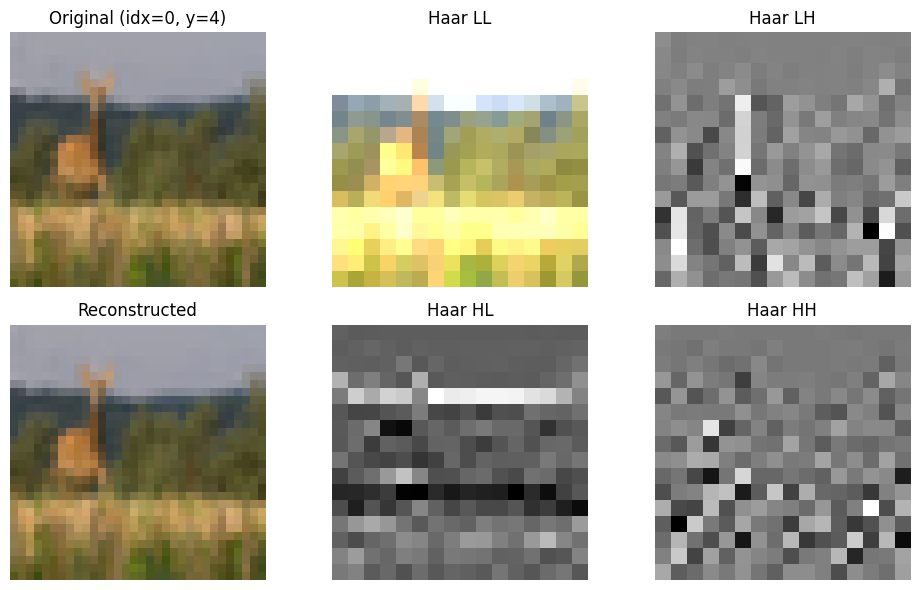

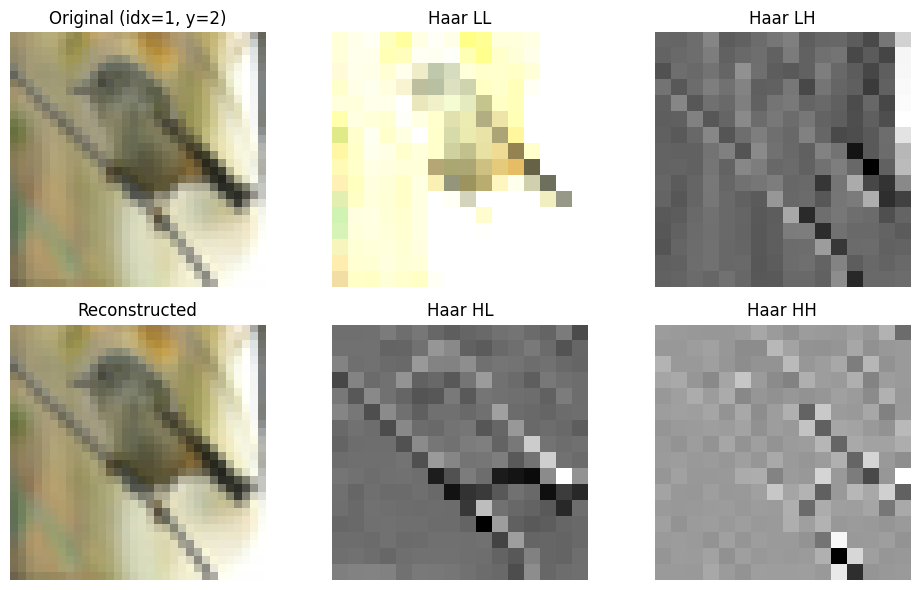

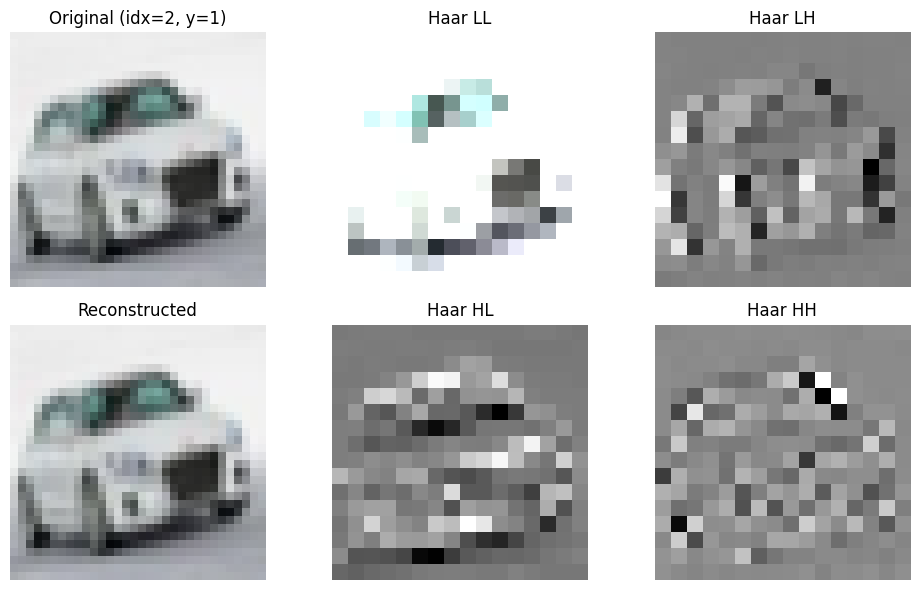

In [45]:
# This cell loads N_SAMPLES CIFAR-10 samples, applies a 1-level Haar DWT,
# reconstructs the image via inverse DWT, and visualizes a few examples
# in a 2x3 grid: (top) Original, LL, LH ; (bottom) Reconstructed, HL, HH.
# DB2 via PyWavelets is optional—set TRY_DB2 to True if pywt is installed.

import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset

N_SAMPLES = 30_000
SAMPLE_INDICES = [0, 1, 2]  
TRY_DB2 = False             

transform = transforms.ToTensor() 
train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
idxs = np.random.choice(len(train_full), N_SAMPLES, replace=False)
train = Subset(train_full, idxs)

def get_item(i):
    x, y = train[i]
    return x, y  # x: (3,32,32)

s = 1.0 / np.sqrt(2.0)

def haar_dwt2(img):
    """
    1-level separable Haar DWT.
    img: (C,H,W), H and W even.
    Returns: LL, LH, HL, HH each (C, H/2, W/2).
    """
    C, H, W = img.shape
    assert H % 2 == 0 and W % 2 == 0, "Image dims must be even."

    def down_cols(x):
        # along width dim=2: even/odd columns
        even = x[:, :, ::2]
        odd  = x[:, :, 1::2]
        low  = s * (even + odd)
        high = s * (even - odd)
        return low, high  # (C,H,W/2) each

    def down_rows(x):
        # along height dim=1: even/odd rows
        even = x[:, ::2, :]
        odd  = x[:, 1::2, :]
        low  = s * (even + odd)
        high = s * (even - odd)
        return low, high  # (C,H/2,W) each

    low_c, high_c = down_cols(img)        # (C,H,W/2) each
    LL, HL = down_rows(low_c)             # LL from low, HL from low-high (rows)
    LH, HH = down_rows(high_c)            # LH from high-low (rows), HH from high-high (rows)
    return LL, LH, HL, HH

def inv1d_upsample(low, high, dim):
    """
    Inverse of the pairwise Haar along a single dimension using:
      even = (low + high) / sqrt(2)
      odd  = (low - high) / sqrt(2)
    Concatenate interleaving even/odd to double the size along 'dim'.
    """
    # permute so target dim is last
    if dim != -1:
        perm = list(range(low.dim()))
        perm[dim], perm[-1] = perm[-1], perm[dim]
        low  = low.permute(*perm)
        high = high.permute(*perm)

    even = (low + high) / np.sqrt(2.0)  # (..., N)
    odd  = (low - high) / np.sqrt(2.0)  # (..., N)

    N = even.shape[-1]
    out_shape = list(even.shape[:-1]) + [2 * N]
    out = even.new_zeros(out_shape)

    out[..., ::2] = even
    out[..., 1::2] = odd

    # permute back
    if dim != -1:
        inv_perm = list(range(out.dim()))
        inv_perm[dim], inv_perm[-1] = inv_perm[-1], inv_perm[dim]
        out = out.permute(*inv_perm)

    return out

def haar_idwt2(LL, LH, HL, HH):
    """
    Inverse 1-level separable Haar DWT.
    Inputs: (C, H/2, W/2). Output: (C, H, W).
    """
    low_c  = inv1d_upsample(LL, HL, dim=1)  
    high_c = inv1d_upsample(LH, HH, dim=1)
    img = inv1d_upsample(low_c, high_c, dim=2)  # along cols (width)
    return img

# Optional DB2 via PyWavelets
def db2_dwt2(img):
    import pywt
    LLs, LHs, HLs, HHs = [], [], [], []
    for c in range(img.shape[0]):
        arr = img[c].cpu().numpy()
        LL, (LH, HL, HH) = pywt.dwt2(arr, "db2", mode="periodization")
        LLs.append(torch.from_numpy(LL))
        LHs.append(torch.from_numpy(LH))
        HLs.append(torch.from_numpy(HL))
        HHs.append(torch.from_numpy(HH))
    return torch.stack(LLs), torch.stack(LHs), torch.stack(HLs), torch.stack(HHs)

def db2_idwt2(LL, LH, HL, HH):
    import pywt
    chans = []
    for c in range(LL.shape[0]):
        rec = pywt.idwt2((LL[c].numpy(),
                          (LH[c].numpy(), HL[c].numpy(), HH[c].numpy())),
                         "db2", mode="periodization")
        chans.append(torch.from_numpy(rec))
    return torch.stack(chans)

def chw_to_hwc(img):
    x = img.detach().cpu()
    x = x.clamp(0, 1)
    return x.permute(1, 2, 0).numpy()

def to_gray01(x):
    # average across channels, normalize to [0,1] for display
    g = x.mean(0)
    g = g - g.min()
    denom = g.max() - g.min()
    if denom > 1e-12:
        g = g / denom
    return g.numpy()

def plot_grid_original_wavelets_recon(img, LL, LH, HL, HH, recon, title_prefix="Haar", idx=0, label=None):
    fig, axes = plt.subplots(2, 3, figsize=(10, 6))

    # Top row: Original, LL (upsampled to 32x32 for viewing), LH
    axes[0,0].imshow(chw_to_hwc(img)); axes[0,0].set_title(f"Original (idx={idx}, y={label})"); axes[0,0].axis("off")

    LL_up = torch.nn.functional.interpolate(LL.unsqueeze(0), size=img.shape[1:], mode="nearest").squeeze(0)
    axes[0,1].imshow(chw_to_hwc(LL_up)); axes[0,1].set_title(f"{title_prefix} LL"); axes[0,1].axis("off")

    axes[0,2].imshow(to_gray01(LH), cmap="gray"); axes[0,2].set_title(f"{title_prefix} LH"); axes[0,2].axis("off")

    # Bottom row: Reconstructed, HL, HH
    axes[1,0].imshow(chw_to_hwc(recon)); axes[1,0].set_title("Reconstructed"); axes[1,0].axis("off")
    axes[1,1].imshow(to_gray01(HL), cmap="gray"); axes[1,1].set_title(f"{title_prefix} HL"); axes[1,1].axis("off")
    axes[1,2].imshow(to_gray01(HH), cmap="gray"); axes[1,2].set_title(f"{title_prefix} HH"); axes[1,2].axis("off")

    plt.tight_layout()
    plt.show()

for i in SAMPLE_INDICES:
    img, y = get_item(i)  # (3,32,32)

    # Haar forward + inverse
    LL, LH, HL, HH = haar_dwt2(img)
    recon = haar_idwt2(LL, LH, HL, HH).clamp(0,1)

    plot_grid_original_wavelets_recon(img, LL, LH, HL, HH, recon, title_prefix="Haar", idx=i, label=y)

    if TRY_DB2:
        try:
            LL2, LH2, HL2, HH2 = db2_dwt2(img)
            recon2 = db2_idwt2(LL2, LH2, HL2, HH2).clamp(0,1)
            plot_grid_original_wavelets_recon(img, LL2, LH2, HL2, HH2, recon2, title_prefix="DB2", idx=i, label=y)
        except Exception as e:
            print("DB2 (pywt) not available or failed:", e)


Files already downloaded and verified


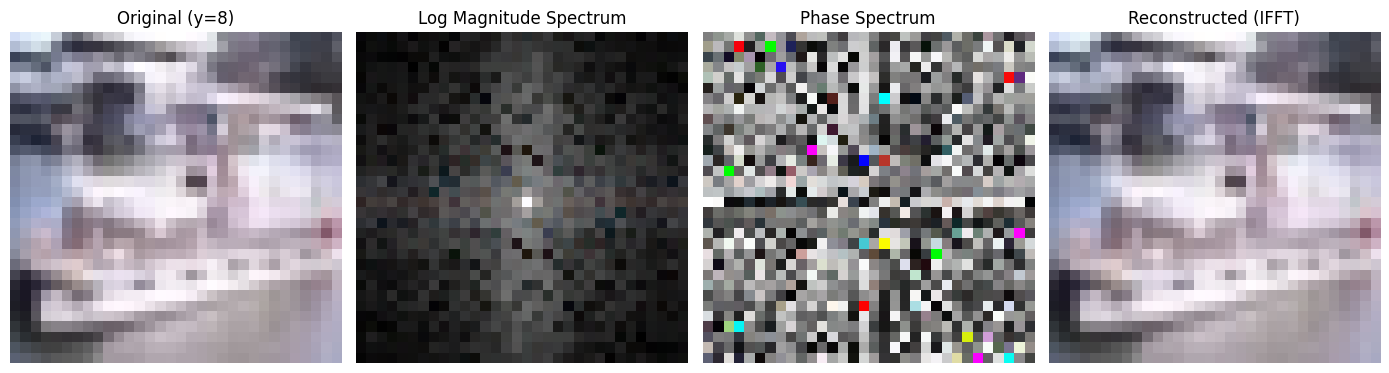

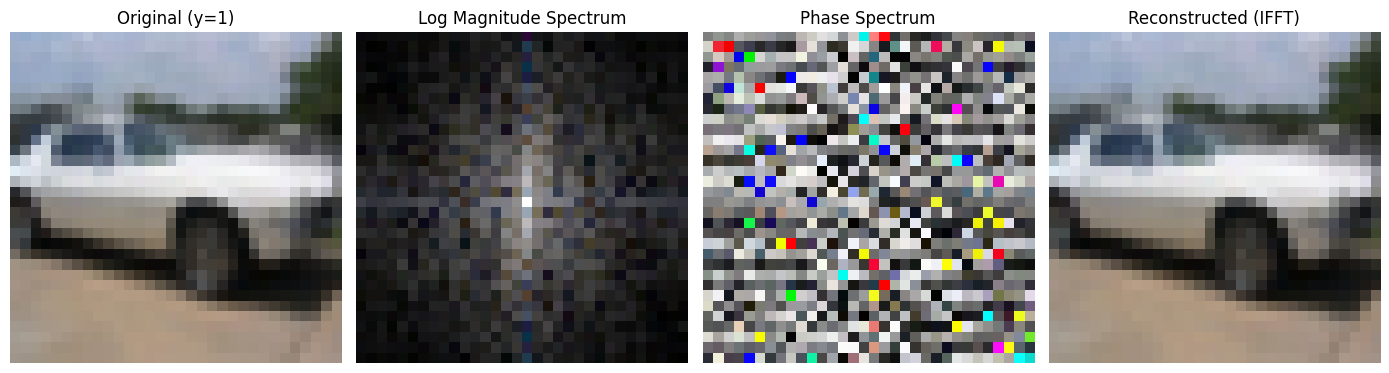

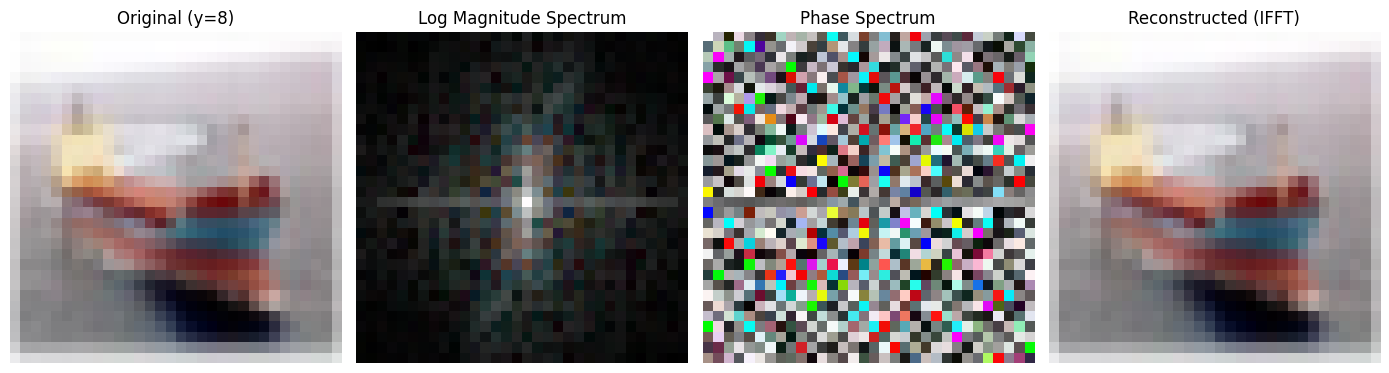

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import Subset

# ------------------------------
# 1. Load subset of CIFAR-10
# ------------------------------
transform = transforms.ToTensor()
dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
subset = Subset(dataset, np.random.choice(len(dataset), 10_000, replace=False))

def get_item(i):
    return subset[i]  # (C,H,W), label

# ------------------------------
# 2. FFT utilities
# ------------------------------
def fft2_centered(x):
    """Compute centered 2D FFT per channel."""
    X = torch.fft.fft2(x, dim=(-2, -1))
    return torch.fft.fftshift(X, dim=(-2, -1))

def ifft2_centered(X):
    """Inverse of fft2_centered."""
    x = torch.fft.ifftshift(X, dim=(-2, -1))
    x = torch.fft.ifft2(x, dim=(-2, -1))
    return x.real  # ignore small imaginary part

def magnitude_spectrum(X):
    """Log magnitude spectrum for visualization."""
    mag = torch.log1p(torch.abs(X))
    mag = mag / mag.max()
    return mag

def phase_spectrum(X):
    """Phase spectrum normalized to [0,1] for display."""
    phase = torch.angle(X)
    phase = (phase + np.pi) / (2 * np.pi)
    return phase

def chw_to_hwc(x):
    return x.detach().cpu().permute(1, 2, 0).numpy()

# ------------------------------
# 3. Plot with reconstruction
# ------------------------------
SAMPLE_INDICES = [0, 1, 2]

for i in SAMPLE_INDICES:
    x, y = get_item(i)  # (3,32,32), label

    # Forward and inverse FFT
    X = fft2_centered(x)
    x_recon = ifft2_centered(X).clamp(0, 1)

    # Visualization components
    mag = magnitude_spectrum(X)
    phase = phase_spectrum(X)

    fig, axes = plt.subplots(1, 4, figsize=(14, 4))

    axes[0].imshow(chw_to_hwc(x))
    axes[0].set_title(f"Original (y={y})")
    axes[0].axis("off")

    axes[1].imshow(chw_to_hwc(mag), cmap="gray")
    axes[1].set_title("Log Magnitude Spectrum")
    axes[1].axis("off")

    axes[2].imshow(chw_to_hwc(phase), cmap="twilight")
    axes[2].set_title("Phase Spectrum")
    axes[2].axis("off")

    axes[3].imshow(chw_to_hwc(x_recon))
    axes[3].set_title("Reconstructed (IFFT)")
    axes[3].axis("off")

    plt.tight_layout()
    plt.show()


# Training Setup + Dependencies

In [8]:
import warnings
warnings.filterwarnings("ignore", message=".*pin_memory.*")
warnings.filterwarnings("ignore", category=UserWarning)

import math
import time
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset, random_split

from torchvision import datasets, transforms
from tqdm.auto import tqdm

try:
    from torch.profiler import profile, record_function, ProfilerActivity
    _HAS_PROFILER = True
except:
    _HAS_PROFILER = False

def seed_everything(seed=123):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = True

seed_everything(123)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def haar_dwt2(img):
    C, H, W = img.shape
    s = 1.0 / math.sqrt(2.0)

    even_cols = img[:, :, 0::2]
    odd_cols  = img[:, :, 1::2]
    low_c  = s * (even_cols + odd_cols)
    high_c = s * (even_cols - odd_cols)

    even_rows = low_c[:, 0::2, :]
    odd_rows  = low_c[:, 1::2, :]
    LL = s * (even_rows + odd_rows)
    HL = s * (even_rows - odd_rows)

    even_rows_h = high_c[:, 0::2, :]
    odd_rows_h  = high_c[:, 1::2, :]
    LH = s * (even_rows_h + odd_rows_h)
    HH = s * (even_rows_h - odd_rows_h)

    return LL.contiguous(), LH.contiguous(), HL.contiguous(), HH.contiguous()


def fft_features(img):
    X = torch.fft.fft2(img, dim=(-2, -1))
    X = torch.fft.fftshift(X)
    mag = torch.log1p(torch.abs(X))
    phase = torch.angle(X)
    return mag.contiguous(), phase.contiguous()

transform = transforms.ToTensor()

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

TRAIN_SAMPLES = 10000
TEST_SAMPLES  = 2000

if TRAIN_SAMPLES:
    idx = np.random.default_rng(0).choice(len(train_dataset), TRAIN_SAMPLES, replace=False)
    train_subset = Subset(train_dataset, idx)
else:
    train_subset = train_dataset

if TEST_SAMPLES:
    idx = np.random.default_rng(1).choice(len(test_dataset), TEST_SAMPLES, replace=False)
    test_subset = Subset(test_dataset, idx)
else:
    test_subset = test_dataset


class WaveletDataset(Dataset):
    def __init__(self, subset, use_subbands=[0,1,2,3]):
        self.subset = subset
        self.use = use_subbands

    def __len__(self): return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        LL, LH, HL, HH = haar_dwt2(x)
        subs = [LL, LH, HL, HH]
        feat = torch.cat([subs[i] for i in self.use], dim=0)
        return feat, y


class FFTDataset(Dataset):
    def __init__(self, subset): self.subset = subset
    def __len__(self): return len(self.subset)

    def __getitem__(self, idx):
        x, y = self.subset[idx]
        mag, phase = fft_features(x)
        return torch.cat([mag, phase], dim=0), y


class BaselineDataset(Dataset):
    def __init__(self, subset): self.subset = subset
    def __len__(self): return len(self.subset)

    def __getitem__(self, idx):
        return self.subset[idx]



/home/users/subaven/pyclaw-flow/pyclaw-flow/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Files already downloaded and verified
Files already downloaded and verified


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class _DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size, drop_rate):
        super().__init__()
        # Bottleneck layers
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv1 = nn.Conv2d(in_channels, bn_size * growth_rate,
                               kernel_size=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        new_features = self.conv1(F.relu(self.bn1(x)))
        new_features = self.conv2(F.relu(self.bn2(new_features)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return torch.cat([x, new_features], 1)


class _DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate, bn_size, drop_rate):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layer = _DenseLayer(
                in_channels + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            layers.append(layer)
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class _Transition(nn.Module):
    def __init__(self, in_channels, out_channels, drop_rate):
        super().__init__()
        self.bn = nn.BatchNorm2d(in_channels)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                              stride=1, bias=False)
        self.drop_rate = drop_rate

    def forward(self, x):
        x = self.conv(F.relu(self.bn(x)))
        if self.drop_rate > 0:
            x = F.dropout(x, p=self.drop_rate, training=self.training)
        return F.avg_pool2d(x, kernel_size=2, stride=2)


class DenseNetBC(nn.Module):
    def __init__(
        self,
        in_ch: int = 3,
        num_classes: int = 10,
        block_config=(6, 12, 24, 16),  # for DenseNet-121
        growth_rate=32,
        bn_size=4,
        drop_rate=0,
        compression=0.5,
        small_input=True
    ):
        super().__init__()

        if small_input:
            # For CIFAR-like inputs, skip initial downsample large kernel/stem
            self.features = nn.Sequential(
                nn.Conv2d(in_ch, 2*growth_rate, kernel_size=3, stride=1, padding=1, bias=False),
            )
            num_init_features = 2 * growth_rate
        else:
            # For ImageNet-like inputs (224x224), original DenseNet stem
            self.features = nn.Sequential(
                nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            )
            num_init_features = 64

        # Each denseblock
        self.block_config = block_config
        self.growth_rate = growth_rate
        self.bn_size = bn_size
        self.drop_rate = drop_rate
        self.compression = compression

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                in_channels=num_features,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.features.add_module(f"denseblock{i+1}", block)
            num_features = num_features + num_layers * growth_rate

            if i != len(block_config) - 1:
                out_features = int(math.floor(num_features * compression))
                trans = _Transition(in_channels=num_features,
                                    out_channels=out_features,
                                    drop_rate=drop_rate)
                self.features.add_module(f"transition{i+1}", trans)
                num_features = out_features

        # Final batch norm
        self.features.add_module("norm_final", nn.BatchNorm2d(num_features))

        # Linear classifier
        self.classifier = nn.Linear(num_features, num_classes)

        # Initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1,1)).flatten(1)
        out = self.classifier(out)
        return out


class WaveletDenseNet(nn.Module):
    def __init__(self, in_ch=12, num_classes=10):
        super().__init__()  # <-- REQUIRED
        self.m = DenseNetBC(
            in_ch=in_ch,
            num_classes=num_classes,
            block_config=(6, 12, 24, 16),
            growth_rate=32,
            bn_size=4,
            drop_rate=0,
            compression=0.5,
            small_input=True
        )

    def forward(self, x):
        return self.m(x)

class FFTDenseNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.m = DenseNetBC(in_ch=6, num_classes=num_classes,
                            block_config=(6,12,24,16),
                            growth_rate=32, bn_size=4,
                            drop_rate=0, compression=0.5,
                            small_input=True)

    def forward(self, x):
        return self.m(x)


class BaselineDenseNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.m = DenseNetBC(in_ch=3, num_classes=num_classes,
                            block_config=(6,12,24,16),
                            growth_rate=32, bn_size=4,
                            drop_rate=0, compression=0.5,
                            small_input=True)

    def forward(self, x):
        return self.m(x)



training fn, used for all runs

In [16]:
def get_loaders(dataset, val_frac=0.1, batch=128, seed=42):
    n = len(dataset)
    n_val = int(n * val_frac)
    n_train = n - n_val
    g = torch.Generator().manual_seed(seed)
    train_ds, val_ds = random_split(dataset, [n_train, n_val], generator=g)
    return (
        DataLoader(train_ds, batch_size=batch, shuffle=True,  num_workers=2),
        DataLoader(val_ds,   batch_size=batch, shuffle=False, num_workers=2)
    )


@torch.no_grad()
def eval_loss_acc(model, loader):
    model.eval()
    crit = nn.CrossEntropyLoss()
    loss_sum, correct, total = 0, 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = crit(logits, y)
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    return loss_sum/total, correct/total


def train_model(
    model, train_loader, val_loader,
    epochs=50, lr=1e-3, patience=20, desc="Model"
):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-5)
    crit = nn.CrossEntropyLoss()

    best_val = float("inf"); best_state = None; bad_epochs = 0
    hist = {"train_loss": [], "val_loss": [], "val_acc": []}

    for ep in range(1, epochs+1):
        model.train()
        t_loss_sum, seen = 0, 0
        pbar = tqdm(train_loader, desc=f"[{desc}] {ep}/{epochs}", leave=False)

        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            opt.zero_grad(set_to_none=True)
            logits = model(x)
            loss = crit(logits, y)
            loss.backward()
            opt.step()
            t_loss_sum += loss.item() * y.size(0)
            seen += y.size(0)
            pbar.set_postfix({"tloss": f"{t_loss_sum/seen:.4f}"})

        scheduler.step()
        train_loss = t_loss_sum / seen
        val_loss, val_acc = eval_loss_acc(model, val_loader)

        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)
        hist["val_acc"].append(val_acc)

        tqdm.write(
            f"[{desc}] ep={ep} lr={scheduler.get_last_lr()[0]:.6f} "
            f"train={train_loss:.4f} val={val_loss:.4f} acc={val_acc*100:.2f}%"
        )

        # if val_loss < best_val - 1e-4:
        #     best_val = val_loss
        #     best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        #     bad_epochs = 0
        # else:
        #     bad_epochs += 1
        #     if bad_epochs >= patience:
        #         tqdm.write(f"[{desc}] Early stopping at epoch {ep}.")
        #         break

    if best_state:
        model.load_state_dict(best_state)
    return model, hist


def profile_model(model, dataset, batch_size=128, device='cuda'):
    if not _HAS_PROFILER:
        print("Profiler not available.")
        return

    if device == 'cpu':
        activities = [ProfilerActivity.CPU]
    else:
        activities = [ProfilerActivity.CPU, ProfilerActivity.CUDA]

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model = model.to(device)
    x, _ = next(iter(loader))
    x = x.to(device)

    with profile(activities=activities, record_shapes=True) as prof:
        with record_function("model_inference"):
            model(x)

    print(prof.key_averages().table(
        sort_by="self_cuda_time_total",
        row_limit=10
    ))

In [39]:
import time
import torch
from torch.utils.data import DataLoader

def _as_loader(dataset_or_loader, batch_size=64, shuffle=False, num_workers=0, pin_memory=True):
    if isinstance(dataset_or_loader, DataLoader):
        return dataset_or_loader
    return DataLoader(
        dataset_or_loader,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        pin_memory=pin_memory,
        drop_last=False,
    )

def count_params(model, trainable_only=False):
    if trainable_only:
        return sum(p.numel() for p in model.parameters() if p.requires_grad)
    return sum(p.numel() for p in model.parameters())

@torch.no_grad()
def evaluate_model(model, dataset_or_loader, batch_size=256, device="cuda", num_workers=0):
    loader = _as_loader(dataset_or_loader, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model.eval().to(device)

    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.numel()
    return 100.0 * correct / max(total, 1)

@torch.no_grad()
def eval_topk(model, dataset_or_loader, k=3, batch_size=256, device="cuda", num_workers=0):
    loader = _as_loader(dataset_or_loader, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model.eval().to(device)

    correct = 0
    total = 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)
        logits = model(x)
        topk = logits.topk(k, dim=1).indices  # [B, k]
        correct += (topk == y.unsqueeze(1)).any(dim=1).sum().item()
        total += y.numel()
    return 100.0 * correct / max(total, 1)

@torch.no_grad()
def measure_inference_time(
    model,
    dataset_or_loader,
    batch_size=256,
    device="cuda",
    num_workers=0,
    warmup=10,
    iters=50,
):
    loader = _as_loader(dataset_or_loader, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    model.eval().to(device)

    x, _ = next(iter(loader))
    x = x.to(device, non_blocking=True)

    # Warmup
    for _ in range(max(warmup, 0)):
        _ = model(x)

    if device.startswith("cuda") and torch.cuda.is_available():
        torch.cuda.synchronize()
        starter = torch.cuda.Event(enable_timing=True)
        ender = torch.cuda.Event(enable_timing=True)

        starter.record()
        for _ in range(iters):
            _ = model(x)
        ender.record()

        torch.cuda.synchronize()
        ms = starter.elapsed_time(ender)  # milliseconds total
        return (ms / 1000.0) / max(iters, 1)  # seconds per forward
    else:
        t0 = time.perf_counter()
        for _ in range(iters):
            _ = model(x)
        t1 = time.perf_counter()
        return (t1 - t0) / max(iters, 1)

def compute_flops(model, dataset_or_loader, batch_size=1, device="cuda", num_workers=0):
    """
    Returns: (flops_total, params_total)

    FLOPs are best-effort from torch.profiler (not every op reports FLOPs).
    """
    params = count_params(model, trainable_only=False)

    loader = _as_loader(dataset_or_loader, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    x, _ = next(iter(loader))
    x = x.to(device)

    model = model.eval().to(device)

    # Some older builds may not support with_flops=True; handle gracefully.
    try:
        from torch.profiler import profile, ProfilerActivity
        with profile(
            activities=[ProfilerActivity.CPU] + ([ProfilerActivity.CUDA] if device.startswith("cuda") and torch.cuda.is_available() else []),
            record_shapes=True,
            with_flops=True,
        ) as prof:
            with torch.no_grad():
                _ = model(x)

        flops = 0
        for evt in prof.key_averages():
            # evt.flops can be None depending on op support
            if hasattr(evt, "flops") and evt.flops is not None:
                flops += int(evt.flops)
        return flops, params
    except Exception:
        # If profiler FLOPs aren't available, still return params.
        return None, params


In [20]:
def make_results():
    return []

def add_result(results, model_name, group, dataset_tag, n_train, n_test, top1, topk, time_s, flops, params):
    results.append({
        "model": model_name,
        "group": group,
        "dataset": dataset_tag,
        "n_train": int(n_train),
        "n_test": int(n_test),
        "top1": float(top1),
        "topk": float(topk),
        "time": float(time_s),
        "flops": float(flops),
        "params": int(params),
    })
    return results

def plot_accuracy_tradeoffs(results, group=None, dataset_tag=None):
    rows = results
    if group is not None:
        rows = [r for r in rows if r["group"] == group]
    if dataset_tag is not None:
        rows = [r for r in rows if r["dataset"] == dataset_tag]

    names = [r["model"] for r in rows]
    accs = [r["top1"] for r in rows]
    flops_m = [r["flops"] / 1e6 for r in rows]
    times = [r["time"] for r in rows]

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(flops_m, accs)
    for i, txt in enumerate(names):
        plt.annotate(txt, (flops_m[i], accs[i]))
    plt.xlabel("FLOPs (M)")
    plt.ylabel("Top-1 Accuracy (%)")
    plt.title("Accuracy vs FLOPs")

    plt.subplot(1, 2, 2)
    plt.scatter(times, accs)
    for i, txt in enumerate(names):
        plt.annotate(txt, (times[i], accs[i]))
    plt.xlabel("Inference Time (s/batch)")
    plt.ylabel("Top-1 Accuracy (%)")
    plt.title("Accuracy vs Inference Time")
    plt.tight_layout()
    plt.show()

def print_summary(results, group=None, dataset_tag=None):
    rows = results
    if group is not None:
        rows = [r for r in rows if r["group"] == group]
    if dataset_tag is not None:
        rows = [r for r in rows if r["dataset"] == dataset_tag]

    print("")
    for r in rows:
        print(f"{r['model']:18s} | Top-1: {r['top1']:.2f}% | Top-3: {r['topk']:.2f}% | Time: {r['time']:.4f}s | FLOPs: {r['flops']:.2e} | Params: {r['params']/1e6:.2f}M")


# Experiments, Reconstruction Task


Training Wavelet model...


[Wavelet] ep=1 lr=0.000999 train=1.7384 val=2.1466 acc=26.40%


[Wavelet] ep=2 lr=0.000996 train=1.3565 val=1.6608 acc=43.40%


[Wavelet] ep=3 lr=0.000991 train=1.0945 val=1.5657 acc=45.80%


[Wavelet] ep=4 lr=0.000984 train=0.8807 val=1.6898 acc=46.40%


[Wavelet] ep=5 lr=0.000976 train=0.6858 val=1.8521 acc=45.40%


[Wavelet] ep=6 lr=0.000965 train=0.5589 val=1.7578 acc=47.60%


[Wavelet] ep=7 lr=0.000953 train=0.3814 val=1.5749 acc=53.60%


[Wavelet] ep=8 lr=0.000939 train=0.2295 val=1.7207 acc=54.70%


[Wavelet] ep=9 lr=0.000923 train=0.2196 val=1.8057 acc=54.30%


[Wavelet] ep=10 lr=0.000905 train=0.2094 val=1.7091 acc=57.10%


[Wavelet] ep=11 lr=0.000886 train=0.1464 val=1.7606 acc=57.10%


[Wavelet] ep=12 lr=0.000866 train=0.1109 val=1.8328 acc=58.10%


[Wavelet] ep=13 lr=0.000844 train=0.0543 val=1.9574 acc=58.50%


[Wavelet] ep=14 lr=0.000821 train=0.1140 val=1.8831 acc=59.00%


[Wavelet] ep=15 lr=0.000796 train=0.0698 val=1.8390 acc=58.90%


[Wavelet] ep=16 lr=0.000770 train=0.0352 val=1.8381 acc=59.60%


[Wavelet] ep=17 lr=0.000743 train=0.0503 val=2.0043 acc=56.90%


[Wavelet] ep=18 lr=0.000716 train=0.0181 val=1.8765 acc=60.70%


[Wavelet] ep=19 lr=0.000687 train=0.0138 val=1.9333 acc=61.60%


[Wavelet] ep=20 lr=0.000658 train=0.0051 val=1.7588 acc=63.00%


[Wavelet] ep=21 lr=0.000628 train=0.0026 val=1.8319 acc=62.80%


[Wavelet] ep=22 lr=0.000598 train=0.0008 val=1.7687 acc=63.60%


[Wavelet] ep=23 lr=0.000567 train=0.0005 val=1.7763 acc=63.40%


[Wavelet] ep=24 lr=0.000536 train=0.0005 val=1.7872 acc=62.80%


[Wavelet] ep=25 lr=0.000505 train=0.0005 val=1.7664 acc=63.80%


[Wavelet] ep=26 lr=0.000474 train=0.0004 val=1.7703 acc=63.60%


[Wavelet] ep=27 lr=0.000443 train=0.0004 val=1.8004 acc=63.60%


[Wavelet] ep=28 lr=0.000412 train=0.0007 val=1.8296 acc=63.00%


[Wavelet] ep=29 lr=0.000382 train=0.0005 val=1.8328 acc=62.70%


[Wavelet] ep=30 lr=0.000352 train=0.0005 val=1.8416 acc=63.30%


[Wavelet] ep=31 lr=0.000323 train=0.0003 val=1.8478 acc=63.30%


[Wavelet] ep=32 lr=0.000294 train=0.0003 val=1.8321 acc=63.80%


[Wavelet] ep=33 lr=0.000267 train=0.0003 val=1.8406 acc=62.90%


[Wavelet] ep=34 lr=0.000240 train=0.0003 val=1.8326 acc=63.40%


[Wavelet] ep=35 lr=0.000214 train=0.0002 val=1.8339 acc=63.30%


[Wavelet] ep=36 lr=0.000189 train=0.0003 val=1.8406 acc=63.50%


[Wavelet] ep=37 lr=0.000166 train=0.0003 val=1.8319 acc=63.40%


[Wavelet] ep=38 lr=0.000144 train=0.0002 val=1.8311 acc=63.40%


[Wavelet] ep=39 lr=0.000124 train=0.0003 val=1.8340 acc=63.90%


[Wavelet] ep=40 lr=0.000105 train=0.0002 val=1.8289 acc=63.50%


[Wavelet] ep=41 lr=0.000087 train=0.0002 val=1.8310 acc=64.00%


[Wavelet] ep=42 lr=0.000071 train=0.0002 val=1.8277 acc=63.30%


[Wavelet] ep=43 lr=0.000057 train=0.0002 val=1.8408 acc=63.50%


[Wavelet] ep=44 lr=0.000045 train=0.0002 val=1.8348 acc=63.90%


[Wavelet] ep=45 lr=0.000034 train=0.0002 val=1.8488 acc=63.70%


[Wavelet] ep=46 lr=0.000026 train=0.0002 val=1.8328 acc=63.50%


[Wavelet] ep=47 lr=0.000019 train=0.0002 val=1.8292 acc=63.60%


[Wavelet] ep=48 lr=0.000014 train=0.0002 val=1.8525 acc=63.40%


[Wavelet] ep=49 lr=0.000011 train=0.0002 val=1.8495 acc=63.30%


[Wavelet] ep=50 lr=0.000010 train=0.0002 val=1.8464 acc=63.60%
TEST performance:
Wavelet Test Acc: 64.95 %

Training FFT model...


[FFT] ep=1 lr=0.000999 train=1.9101 val=2.9864 acc=16.10%


[FFT] ep=2 lr=0.000996 train=1.5491 val=1.9986 acc=29.60%


[FFT] ep=3 lr=0.000991 train=1.3606 val=3.3774 acc=21.40%


[FFT] ep=4 lr=0.000984 train=1.1085 val=2.0563 acc=33.80%


[FFT] ep=5 lr=0.000976 train=0.8920 val=4.7577 acc=13.20%


[FFT] ep=6 lr=0.000965 train=0.7157 val=3.3225 acc=25.00%


[FFT] ep=7 lr=0.000953 train=0.5560 val=4.0766 acc=24.90%


[FFT] ep=8 lr=0.000939 train=0.3854 val=4.9442 acc=25.80%


[FFT] ep=9 lr=0.000923 train=0.3039 val=9.2419 acc=14.80%


[FFT] ep=10 lr=0.000905 train=0.2600 val=5.1164 acc=25.40%


[FFT] ep=11 lr=0.000886 train=0.2069 val=3.6089 acc=34.30%


[FFT] ep=12 lr=0.000866 train=0.1016 val=2.9821 acc=40.40%


[FFT] ep=13 lr=0.000844 train=0.0737 val=4.0646 acc=33.50%


[FFT] ep=14 lr=0.000821 train=0.0595 val=3.6164 acc=37.50%


[FFT] ep=15 lr=0.000796 train=0.0735 val=3.6991 acc=33.00%


[FFT] ep=16 lr=0.000770 train=0.0621 val=4.0987 acc=35.10%


[FFT] ep=17 lr=0.000743 train=0.0599 val=3.4706 acc=36.80%


[FFT] ep=18 lr=0.000716 train=0.0586 val=3.7510 acc=36.70%


[FFT] ep=19 lr=0.000687 train=0.0249 val=3.6204 acc=35.50%


[FFT] ep=20 lr=0.000658 train=0.0112 val=3.3421 acc=40.80%


[FFT] ep=21 lr=0.000628 train=0.0054 val=3.1250 acc=40.70%


[FFT] ep=22 lr=0.000598 train=0.0018 val=3.0306 acc=44.50%


[FFT] ep=23 lr=0.000567 train=0.0013 val=3.2112 acc=43.30%


[FFT] ep=24 lr=0.000536 train=0.0008 val=3.0477 acc=43.70%


[FFT] ep=25 lr=0.000505 train=0.0007 val=3.0679 acc=43.30%


[FFT] ep=26 lr=0.000474 train=0.0052 val=3.1953 acc=43.50%


[FFT] ep=27 lr=0.000443 train=0.0259 val=4.3246 acc=36.60%


[FFT] ep=28 lr=0.000412 train=0.0511 val=3.6510 acc=42.60%


[FFT] ep=29 lr=0.000382 train=0.0119 val=3.2063 acc=42.50%


[FFT] ep=30 lr=0.000352 train=0.0034 val=3.3201 acc=42.60%


[FFT] ep=31 lr=0.000323 train=0.0170 val=3.5159 acc=39.90%


[FFT] ep=32 lr=0.000294 train=0.0104 val=3.2122 acc=42.30%


[FFT] ep=33 lr=0.000267 train=0.0020 val=3.1140 acc=42.50%


[FFT] ep=34 lr=0.000240 train=0.0010 val=3.0737 acc=42.90%


[FFT] ep=35 lr=0.000214 train=0.0010 val=3.0832 acc=43.50%


[FFT] ep=36 lr=0.000189 train=0.0007 val=3.0918 acc=43.50%


[FFT] ep=37 lr=0.000166 train=0.0007 val=3.1126 acc=43.40%


[FFT] ep=38 lr=0.000144 train=0.0033 val=3.2260 acc=41.80%


[FFT] ep=39 lr=0.000124 train=0.0009 val=3.1948 acc=44.30%


[FFT] ep=40 lr=0.000105 train=0.0019 val=3.1339 acc=44.10%


[FFT] ep=41 lr=0.000087 train=0.0009 val=3.0776 acc=44.30%


[FFT] ep=42 lr=0.000071 train=0.0006 val=3.0879 acc=44.50%


[FFT] ep=43 lr=0.000057 train=0.0021 val=3.1599 acc=43.80%


[FFT] ep=44 lr=0.000045 train=0.0028 val=3.2035 acc=42.70%


[FFT] ep=45 lr=0.000034 train=0.0012 val=3.1513 acc=43.60%


[FFT] ep=46 lr=0.000026 train=0.0010 val=3.1311 acc=44.20%


[FFT] ep=47 lr=0.000019 train=0.0009 val=3.1448 acc=43.80%


[FFT] ep=48 lr=0.000014 train=0.0007 val=3.1373 acc=44.40%


[FFT] ep=49 lr=0.000011 train=0.0009 val=3.1538 acc=43.20%


[FFT] ep=50 lr=0.000010 train=0.0008 val=3.1568 acc=43.70%
TEST performance:
FFT Test Acc: 45.300000000000004 %

Training Baseline model...


[Baseline] ep=1 lr=0.000999 train=1.7229 val=3.4247 acc=13.10%


[Baseline] ep=2 lr=0.000996 train=1.3075 val=1.7677 acc=40.70%


[Baseline] ep=3 lr=0.000991 train=1.1129 val=1.7909 acc=40.90%


[Baseline] ep=4 lr=0.000984 train=0.9442 val=1.3700 acc=49.90%


[Baseline] ep=5 lr=0.000976 train=0.8499 val=1.5978 acc=48.60%


[Baseline] ep=6 lr=0.000965 train=0.6699 val=1.5093 acc=53.20%


[Baseline] ep=7 lr=0.000953 train=0.5147 val=1.1762 acc=63.20%


[Baseline] ep=8 lr=0.000939 train=0.3917 val=1.4203 acc=60.90%


[Baseline] ep=9 lr=0.000923 train=0.3229 val=1.5968 acc=54.70%


[Baseline] ep=10 lr=0.000905 train=0.3673 val=1.2928 acc=62.90%


[Baseline] ep=11 lr=0.000886 train=0.2125 val=1.3237 acc=65.50%


[Baseline] ep=12 lr=0.000866 train=0.1458 val=1.1690 acc=67.20%


[Baseline] ep=13 lr=0.000844 train=0.0945 val=1.3884 acc=65.10%


[Baseline] ep=14 lr=0.000821 train=0.0948 val=1.4363 acc=65.00%


[Baseline] ep=15 lr=0.000796 train=0.0464 val=1.2614 acc=70.10%


[Baseline] ep=16 lr=0.000770 train=0.0786 val=1.5453 acc=64.70%


[Baseline] ep=17 lr=0.000743 train=0.0991 val=1.4570 acc=65.20%


[Baseline] ep=18 lr=0.000716 train=0.0772 val=1.5555 acc=63.40%


[Baseline] ep=19 lr=0.000687 train=0.0551 val=1.6526 acc=67.80%


[Baseline] ep=20 lr=0.000658 train=0.0189 val=1.2255 acc=71.30%


[Baseline] ep=21 lr=0.000628 train=0.0063 val=1.2051 acc=72.20%


[Baseline] ep=22 lr=0.000598 train=0.0026 val=1.1459 acc=73.60%


[Baseline] ep=23 lr=0.000567 train=0.0015 val=1.1563 acc=73.30%


[Baseline] ep=24 lr=0.000536 train=0.0026 val=1.1839 acc=73.60%


[Baseline] ep=25 lr=0.000505 train=0.0010 val=1.1786 acc=73.70%


[Baseline] ep=26 lr=0.000474 train=0.0008 val=1.1868 acc=74.40%


[Baseline] ep=27 lr=0.000443 train=0.0013 val=1.1962 acc=74.00%


[Baseline] ep=28 lr=0.000412 train=0.0010 val=1.1791 acc=74.10%


[Baseline] ep=29 lr=0.000382 train=0.0007 val=1.1731 acc=74.30%


[Baseline] ep=30 lr=0.000352 train=0.0011 val=1.2283 acc=73.60%


[Baseline] ep=31 lr=0.000323 train=0.0307 val=1.3458 acc=72.00%


[Baseline] ep=32 lr=0.000294 train=0.0154 val=1.3775 acc=71.00%


[Baseline] ep=33 lr=0.000267 train=0.0036 val=1.2674 acc=73.30%


[Baseline] ep=34 lr=0.000240 train=0.0060 val=1.4142 acc=72.50%


[Baseline] ep=35 lr=0.000214 train=0.0026 val=1.2711 acc=72.80%


[Baseline] ep=36 lr=0.000189 train=0.0011 val=1.2182 acc=74.00%


[Baseline] ep=37 lr=0.000166 train=0.0008 val=1.2227 acc=74.40%


[Baseline] ep=38 lr=0.000144 train=0.0008 val=1.2244 acc=74.00%


[Baseline] ep=39 lr=0.000124 train=0.0011 val=1.2122 acc=74.30%


[Baseline] ep=40 lr=0.000105 train=0.0009 val=1.2260 acc=74.30%


[Baseline] ep=41 lr=0.000087 train=0.0028 val=1.2716 acc=73.80%


[Baseline] ep=42 lr=0.000071 train=0.0009 val=1.2409 acc=74.30%


[Baseline] ep=43 lr=0.000057 train=0.0010 val=1.2451 acc=73.50%


[Baseline] ep=44 lr=0.000045 train=0.0018 val=1.2558 acc=73.90%


[Baseline] ep=45 lr=0.000034 train=0.0007 val=1.2463 acc=74.10%


[Baseline] ep=46 lr=0.000026 train=0.0006 val=1.2526 acc=74.00%


[Baseline] ep=47 lr=0.000019 train=0.0007 val=1.2508 acc=74.10%


[Baseline] ep=48 lr=0.000014 train=0.0006 val=1.2537 acc=73.80%


[Baseline] ep=49 lr=0.000011 train=0.0007 val=1.2561 acc=74.00%


[Baseline] ep=50 lr=0.000010 train=0.0009 val=1.2495 acc=74.00%
TEST performance:
Baseline Test Acc: 73.45 %


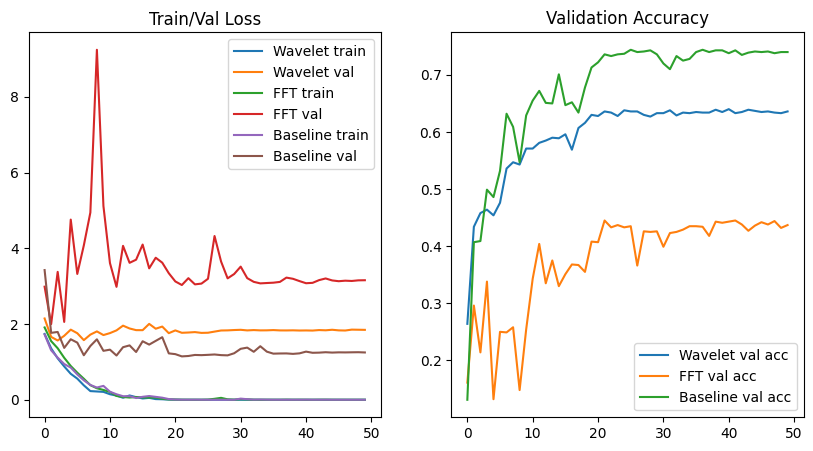


Profiling Wavelet model...
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         0.00%       0.000us         0.00%       0.000us       0.000us      26.244ms        73.82%      26.244ms      26.244ms             1  
                                 aten::cudnn_batch_norm        10.36%       3.030ms        21.88%       6.397ms      53.305us       4.384ms        12.33%       4.384ms      36.532

In [93]:

import time
import torch

@torch.no_grad()
def benchmark_inference_cpu(model, input_shape=(1, 3, 32, 32), iters=200):
    device = "cpu"
    model = model.to(device).eval()
    x = torch.randn(*input_shape, device=device)

    # Warm-up (important for CPU JIT paths and cache)
    for _ in range(20):
        _ = model(x)

    start = time.perf_counter()
    for _ in range(iters):
        _ = model(x)
    end = time.perf_counter()

    avg_latency = (end - start) / iters
    throughput = 1.0 / avg_latency

    print("===== CPU Inference Benchmark =====")
    print(f"Avg latency: {avg_latency * 1000:.3f} ms")
    print(f"Throughput: {throughput:.2f} samples/sec\n")

# first set of experiment runs, 50 epoch tests, for accuracy values + loss plotting
wave_train, wave_val = get_loaders(WaveletDataset(train_subset), batch=256)
wave_test = WaveletDataset(test_subset)

wave_model = WaveletDenseNet()
print("\nTraining Wavelet model...")
wave_model, wave_hist = train_model(wave_model, wave_train, wave_val, desc="Wavelet")

print("TEST performance:")
wave_test_acc = eval_loss_acc(wave_model, DataLoader(wave_test, batch_size=256))[1]
print("Wavelet Test Acc:", wave_test_acc*100, "%")


# ---- FFT ----
fft_train, fft_val = get_loaders(FFTDataset(train_subset), batch=256)
fft_test = FFTDataset(test_subset)

fft_model = FFTDenseNet()
print("\nTraining FFT model...")
fft_model, fft_hist = train_model(fft_model, fft_train, fft_val, desc="FFT")

print("TEST performance:")
fft_test_acc = eval_loss_acc(fft_model, DataLoader(fft_test, batch_size=256))[1]
print("FFT Test Acc:", fft_test_acc*100, "%")


# ---- Baseline ----
base_train, base_val = get_loaders(BaselineDataset(train_subset), batch=256)
base_test = BaselineDataset(test_subset)

base_model = BaselineDenseNet()
print("\nTraining Baseline model...")
base_model, base_hist = train_model(base_model, base_train, base_val, desc="Baseline")

print("TEST performance:")
base_test_acc = eval_loss_acc(base_model, DataLoader(base_test, batch_size=256))[1]
print("Baseline Test Acc:", base_test_acc*100, "%")


print("\nProfiling Wavelet model...")
profile_model(wave_model, wave_test)

print("\nProfiling FFT model...")
profile_model(fft_model, fft_test)

print("\nProfiling Baseline model...")
profile_model(base_model, base_test)

print("Inference Benchmark — Wavelet:")
benchmark_inference(wave_model, input_shape=(1,12,16,16))

print("Inference Benchmark — FFT:")
benchmark_inference(fft_model, input_shape=(1,6,32,32))

print("Inference Benchmark — Baseline:")
benchmark_inference(base_model, input_shape=(1,3,32,32))

In [28]:
wave_train, wave_val = get_loaders(WaveletDataset(train_subset), batch=256)
wave_test = WaveletDataset(test_subset)

wave_model = WaveletDenseNet()
print("\nTraining Wavelet model...")
wave_model, wave_hist = train_model(wave_model, wave_train, wave_val, desc="Wavelet", epochs=50)

print("TEST performance:")
wave_test_acc = eval_loss_acc(wave_model, DataLoader(wave_test, batch_size=256))[1]
print("Wavelet Test Acc:", wave_test_acc*100, "%")


# ---- FFT ----
fft_train, fft_val = get_loaders(FFTDataset(train_subset), batch=256)
fft_test = FFTDataset(test_subset)

fft_model = FFTDenseNet()
print("\nTraining FFT model...")
fft_model, fft_hist = train_model(fft_model, fft_train, fft_val, desc="FFT", epochs=50)

print("TEST performance:")
fft_test_acc = eval_loss_acc(fft_model, DataLoader(fft_test, batch_size=256))[1]
print("FFT Test Acc:", fft_test_acc*100, "%")


# ---- Baseline ----
base_train, base_val = get_loaders(BaselineDataset(train_subset), batch=256)
base_test = BaselineDataset(test_subset)

base_model = BaselineDenseNet()
print("\nTraining Baseline model...")
base_model, base_hist = train_model(base_model, base_train, base_val, desc="Baseline", epochs=50)

print("TEST performance:")
base_test_acc = eval_loss_acc(base_model, DataLoader(base_test, batch_size=256))[1]
print("Baseline Test Acc:", base_test_acc*100, "%")



Training Wavelet model...


[Wavelet] ep=1 lr=0.000999 train=1.7175 val=2.7176 acc=22.60%


[Wavelet] ep=2 lr=0.000996 train=1.3435 val=1.6000 acc=41.80%


[Wavelet] ep=3 lr=0.000991 train=1.0964 val=1.5005 acc=47.70%


[Wavelet] ep=4 lr=0.000984 train=0.8907 val=1.4018 acc=51.60%


[Wavelet] ep=5 lr=0.000976 train=0.6846 val=1.6231 acc=49.50%


[Wavelet] ep=6 lr=0.000965 train=0.5211 val=1.6402 acc=52.90%


[Wavelet] ep=7 lr=0.000953 train=0.4382 val=1.7783 acc=51.60%


[Wavelet] ep=8 lr=0.000939 train=0.3028 val=1.8271 acc=53.60%


[Wavelet] ep=9 lr=0.000923 train=0.2701 val=1.9265 acc=53.10%


[Wavelet] ep=10 lr=0.000905 train=0.2085 val=1.6646 acc=57.10%


[Wavelet] ep=11 lr=0.000886 train=0.1397 val=1.7776 acc=59.30%


[Wavelet] ep=12 lr=0.000866 train=0.0937 val=1.7682 acc=57.20%


[Wavelet] ep=13 lr=0.000844 train=0.0845 val=1.7410 acc=59.70%


[Wavelet] ep=14 lr=0.000821 train=0.0415 val=1.6141 acc=62.50%


[Wavelet] ep=15 lr=0.000796 train=0.0166 val=1.7893 acc=62.20%


[Wavelet] ep=16 lr=0.000770 train=0.0124 val=1.7857 acc=61.90%


[Wavelet] ep=17 lr=0.000743 train=0.0132 val=1.8279 acc=62.00%


[Wavelet] ep=18 lr=0.000716 train=0.0125 val=1.8891 acc=61.10%


[Wavelet] ep=19 lr=0.000687 train=0.0061 val=1.7904 acc=62.20%


[Wavelet] ep=20 lr=0.000658 train=0.0188 val=1.7971 acc=61.50%


[Wavelet] ep=21 lr=0.000628 train=0.0053 val=1.8646 acc=61.80%


[Wavelet] ep=22 lr=0.000598 train=0.0046 val=1.8755 acc=62.90%


[Wavelet] ep=23 lr=0.000567 train=0.0049 val=1.8814 acc=63.40%


[Wavelet] ep=24 lr=0.000536 train=0.0041 val=1.8830 acc=63.20%


[Wavelet] ep=25 lr=0.000505 train=0.0037 val=1.9899 acc=61.00%


[Wavelet] ep=26 lr=0.000474 train=0.0151 val=2.0676 acc=59.80%


[Wavelet] ep=27 lr=0.000443 train=0.0190 val=2.1076 acc=60.30%


[Wavelet] ep=28 lr=0.000412 train=0.0088 val=2.0743 acc=59.80%


[Wavelet] ep=29 lr=0.000382 train=0.0188 val=1.9955 acc=61.10%


[Wavelet] ep=30 lr=0.000352 train=0.0071 val=1.9345 acc=62.60%


[Wavelet] ep=31 lr=0.000323 train=0.0034 val=1.9029 acc=63.30%


[Wavelet] ep=32 lr=0.000294 train=0.0014 val=1.9009 acc=63.00%


[Wavelet] ep=33 lr=0.000267 train=0.0010 val=1.8610 acc=63.30%


[Wavelet] ep=34 lr=0.000240 train=0.0009 val=1.8961 acc=63.40%


[Wavelet] ep=35 lr=0.000214 train=0.0007 val=1.9240 acc=62.50%


[Wavelet] ep=36 lr=0.000189 train=0.0006 val=1.9210 acc=63.00%


[Wavelet] ep=37 lr=0.000166 train=0.0012 val=1.9401 acc=62.10%


[Wavelet] ep=38 lr=0.000144 train=0.0013 val=1.9165 acc=62.80%


[Wavelet] ep=39 lr=0.000124 train=0.0022 val=1.8838 acc=63.20%


[Wavelet] ep=40 lr=0.000105 train=0.0006 val=1.8974 acc=63.50%


[Wavelet] ep=41 lr=0.000087 train=0.0005 val=1.8858 acc=63.60%


[Wavelet] ep=42 lr=0.000071 train=0.0004 val=1.8806 acc=63.90%


[Wavelet] ep=43 lr=0.000057 train=0.0004 val=1.8855 acc=63.80%


[Wavelet] ep=44 lr=0.000045 train=0.0004 val=1.8917 acc=63.60%


[Wavelet] ep=45 lr=0.000034 train=0.0004 val=1.8863 acc=63.30%


[Wavelet] ep=46 lr=0.000026 train=0.0004 val=1.8890 acc=63.90%


[Wavelet] ep=47 lr=0.000019 train=0.0004 val=1.8943 acc=63.40%


[Wavelet] ep=48 lr=0.000014 train=0.0004 val=1.8806 acc=63.00%


[Wavelet] ep=49 lr=0.000011 train=0.0004 val=1.8925 acc=63.40%


[Wavelet] ep=50 lr=0.000010 train=0.0003 val=1.8925 acc=64.00%
TEST performance:
Wavelet Test Acc: 64.75 %

Training FFT model...


[FFT] ep=1 lr=0.000999 train=1.9035 val=2.1038 acc=29.40%


[FFT] ep=2 lr=0.000996 train=1.5696 val=2.4786 acc=22.90%


[FFT] ep=3 lr=0.000991 train=1.3222 val=2.1616 acc=30.50%


[FFT] ep=4 lr=0.000984 train=1.1350 val=3.4061 acc=26.10%


[FFT] ep=5 lr=0.000976 train=0.8903 val=3.9794 acc=19.00%


[FFT] ep=6 lr=0.000965 train=0.7215 val=2.6880 acc=34.00%


[FFT] ep=7 lr=0.000953 train=0.5040 val=2.2401 acc=37.40%


[FFT] ep=8 lr=0.000939 train=0.3421 val=4.6261 acc=24.40%


[FFT] ep=9 lr=0.000923 train=0.3060 val=4.5343 acc=24.30%


[FFT] ep=10 lr=0.000905 train=0.2080 val=4.2661 acc=30.10%


[FFT] ep=11 lr=0.000886 train=0.2346 val=3.1992 acc=34.70%


[FFT] ep=12 lr=0.000866 train=0.1791 val=3.2939 acc=35.20%


[FFT] ep=13 lr=0.000844 train=0.0843 val=4.1038 acc=32.50%


[FFT] ep=14 lr=0.000821 train=0.0534 val=4.0492 acc=33.50%


[FFT] ep=15 lr=0.000796 train=0.0304 val=4.2757 acc=34.00%


[FFT] ep=16 lr=0.000770 train=0.0234 val=3.5035 acc=42.20%


[FFT] ep=17 lr=0.000743 train=0.0113 val=3.3271 acc=42.50%


[FFT] ep=18 lr=0.000716 train=0.0069 val=3.0955 acc=42.50%


[FFT] ep=19 lr=0.000687 train=0.0579 val=4.2560 acc=38.20%


[FFT] ep=20 lr=0.000658 train=0.0449 val=4.4626 acc=31.30%


[FFT] ep=21 lr=0.000628 train=0.0559 val=3.9857 acc=36.20%


[FFT] ep=22 lr=0.000598 train=0.0740 val=4.8385 acc=30.20%


[FFT] ep=23 lr=0.000567 train=0.0634 val=4.8245 acc=31.70%


[FFT] ep=24 lr=0.000536 train=0.0403 val=3.6753 acc=40.00%


[FFT] ep=25 lr=0.000505 train=0.0094 val=3.2438 acc=42.50%


[FFT] ep=26 lr=0.000474 train=0.0090 val=3.2044 acc=43.80%


[FFT] ep=27 lr=0.000443 train=0.0057 val=3.1894 acc=43.70%


[FFT] ep=28 lr=0.000412 train=0.0024 val=3.2338 acc=43.40%


[FFT] ep=29 lr=0.000382 train=0.0070 val=3.4147 acc=42.70%


[FFT] ep=30 lr=0.000352 train=0.0024 val=3.2288 acc=43.40%


[FFT] ep=31 lr=0.000323 train=0.0011 val=3.2388 acc=43.20%


[FFT] ep=32 lr=0.000294 train=0.0012 val=3.3520 acc=43.00%


[FFT] ep=33 lr=0.000267 train=0.0112 val=3.2906 acc=45.10%


[FFT] ep=34 lr=0.000240 train=0.0026 val=3.1672 acc=43.40%


[FFT] ep=35 lr=0.000214 train=0.0010 val=3.1813 acc=44.20%


[FFT] ep=36 lr=0.000189 train=0.0009 val=3.2311 acc=45.10%


[FFT] ep=37 lr=0.000166 train=0.0031 val=3.2976 acc=44.00%


[FFT] ep=38 lr=0.000144 train=0.0013 val=3.3025 acc=44.20%


[FFT] ep=39 lr=0.000124 train=0.0008 val=3.2541 acc=44.80%


[FFT] ep=40 lr=0.000105 train=0.0006 val=3.2648 acc=43.80%


[FFT] ep=41 lr=0.000087 train=0.0006 val=3.2628 acc=44.20%


[FFT] ep=42 lr=0.000071 train=0.0006 val=3.2735 acc=43.70%


[FFT] ep=43 lr=0.000057 train=0.0005 val=3.2606 acc=43.90%


[FFT] ep=44 lr=0.000045 train=0.0006 val=3.2776 acc=43.90%


[FFT] ep=45 lr=0.000034 train=0.0005 val=3.2585 acc=43.90%


[FFT] ep=46 lr=0.000026 train=0.0005 val=3.2608 acc=43.90%


[FFT] ep=47 lr=0.000019 train=0.0006 val=3.2850 acc=44.20%


[FFT] ep=48 lr=0.000014 train=0.0005 val=3.2456 acc=44.60%


[FFT] ep=49 lr=0.000011 train=0.0004 val=3.2730 acc=43.20%


[FFT] ep=50 lr=0.000010 train=0.0004 val=3.2668 acc=44.20%
TEST performance:
FFT Test Acc: 45.800000000000004 %

Training Baseline model...


[Baseline] ep=1 lr=0.000999 train=1.7167 val=2.9294 acc=15.60%


[Baseline] ep=2 lr=0.000996 train=1.3229 val=1.6338 acc=43.50%


[Baseline] ep=3 lr=0.000991 train=1.1462 val=1.3759 acc=51.40%


[Baseline] ep=4 lr=0.000984 train=0.9405 val=1.5374 acc=48.60%


[Baseline] ep=5 lr=0.000976 train=0.7880 val=1.2252 acc=59.00%


[Baseline] ep=6 lr=0.000965 train=0.6970 val=1.2880 acc=56.50%


[Baseline] ep=7 lr=0.000953 train=0.5003 val=1.1961 acc=60.10%


[Baseline] ep=8 lr=0.000939 train=0.4281 val=1.6956 acc=55.00%


[Baseline] ep=9 lr=0.000923 train=0.3090 val=1.5186 acc=56.70%


[Baseline] ep=10 lr=0.000905 train=0.2209 val=1.9780 acc=54.60%


[Baseline] ep=11 lr=0.000886 train=0.3064 val=1.6497 acc=58.60%


[Baseline] ep=12 lr=0.000866 train=0.1836 val=1.3042 acc=63.80%


[Baseline] ep=13 lr=0.000844 train=0.0863 val=1.1410 acc=70.10%


[Baseline] ep=14 lr=0.000821 train=0.0492 val=1.2109 acc=69.80%


[Baseline] ep=15 lr=0.000796 train=0.0817 val=1.5015 acc=65.30%


[Baseline] ep=16 lr=0.000770 train=0.0723 val=1.4514 acc=67.00%


[Baseline] ep=17 lr=0.000743 train=0.0597 val=1.5066 acc=66.60%


[Baseline] ep=18 lr=0.000716 train=0.0307 val=1.5585 acc=66.30%


[Baseline] ep=19 lr=0.000687 train=0.0235 val=1.1992 acc=72.30%


[Baseline] ep=20 lr=0.000658 train=0.0444 val=1.5743 acc=69.00%


[Baseline] ep=21 lr=0.000628 train=0.0250 val=1.2976 acc=69.80%


[Baseline] ep=22 lr=0.000598 train=0.0207 val=1.3954 acc=69.40%


[Baseline] ep=23 lr=0.000567 train=0.0181 val=1.3577 acc=72.10%


[Baseline] ep=24 lr=0.000536 train=0.0406 val=1.4652 acc=69.90%


[Baseline] ep=25 lr=0.000505 train=0.0105 val=1.4351 acc=71.30%


[Baseline] ep=26 lr=0.000474 train=0.0214 val=1.4716 acc=70.30%


[Baseline] ep=27 lr=0.000443 train=0.0197 val=1.6825 acc=68.10%


[Baseline] ep=28 lr=0.000412 train=0.0376 val=1.4306 acc=70.60%


[Baseline] ep=29 lr=0.000382 train=0.0073 val=1.3203 acc=71.60%


[Baseline] ep=30 lr=0.000352 train=0.0078 val=1.3303 acc=71.10%


[Baseline] ep=31 lr=0.000323 train=0.0016 val=1.2187 acc=73.60%


[Baseline] ep=32 lr=0.000294 train=0.0042 val=1.2677 acc=73.00%


[Baseline] ep=33 lr=0.000267 train=0.0010 val=1.2419 acc=73.70%


[Baseline] ep=34 lr=0.000240 train=0.0007 val=1.2398 acc=73.50%


[Baseline] ep=35 lr=0.000214 train=0.0007 val=1.2499 acc=73.60%


[Baseline] ep=36 lr=0.000189 train=0.0006 val=1.2384 acc=73.60%


[Baseline] ep=37 lr=0.000166 train=0.0006 val=1.2480 acc=73.70%


[Baseline] ep=38 lr=0.000144 train=0.0005 val=1.2407 acc=73.60%


[Baseline] ep=39 lr=0.000124 train=0.0005 val=1.2379 acc=73.20%


[Baseline] ep=40 lr=0.000105 train=0.0005 val=1.2561 acc=73.90%


[Baseline] ep=41 lr=0.000087 train=0.0005 val=1.2390 acc=73.30%


[Baseline] ep=42 lr=0.000071 train=0.0005 val=1.2306 acc=73.60%


[Baseline] ep=43 lr=0.000057 train=0.0005 val=1.2355 acc=73.80%


[Baseline] ep=44 lr=0.000045 train=0.0005 val=1.2567 acc=74.30%


[Baseline] ep=45 lr=0.000034 train=0.0004 val=1.2521 acc=73.60%


[Baseline] ep=46 lr=0.000026 train=0.0005 val=1.2509 acc=73.40%


[Baseline] ep=47 lr=0.000019 train=0.0005 val=1.2555 acc=74.00%


[Baseline] ep=48 lr=0.000014 train=0.0004 val=1.2504 acc=74.00%


[Baseline] ep=49 lr=0.000011 train=0.0005 val=1.2500 acc=73.70%


[Baseline] ep=50 lr=0.000010 train=0.0004 val=1.2434 acc=74.20%
TEST performance:
Baseline Test Acc: 74.5 %


In [54]:
import time
from torch.utils.data import DataLoader

EPOCHS_TRAIN_TIME = 20
BATCH = 256

timing = {}

wave_train2, wave_val2 = get_loaders(WaveletDataset(train_subset), batch=BATCH)
wave_test2 = WaveletDataset(test_subset)

wave_model_time = WaveletDenseNet()
print("\nTraining Wavelet model (timing run)...")
t0 = time.perf_counter()
wave_model_time, wave_hist_time = train_model(wave_model_time, wave_train2, wave_val2, desc="Wavelet-Timing", epochs=EPOCHS_TRAIN_TIME)
t1 = time.perf_counter()
timing["Wavelet"] = {"train_seconds": t1 - t0, "hist": wave_hist_time}

print("TEST performance:")
wave_test_acc_time = eval_loss_acc(wave_model_time, DataLoader(wave_test2, batch_size=BATCH, shuffle=False))[1]
print(f"Wavelet Test Acc: {wave_test_acc_time*100:.2f}%")
print(f"Wavelet Total Training Time: {timing['Wavelet']['train_seconds']:.2f}s")

fft_train2, fft_val2 = get_loaders(FFTDataset(train_subset), batch=BATCH)
fft_test2 = FFTDataset(test_subset)

fft_model_time = FFTDenseNet()
print("\nTraining FFT model (timing run)...")
t0 = time.perf_counter()
fft_model_time, fft_hist_time = train_model(fft_model_time, fft_train2, fft_val2, desc="FFT-Timing", epochs=EPOCHS_TRAIN_TIME)
t1 = time.perf_counter()
timing["FFT"] = {"train_seconds": t1 - t0, "hist": fft_hist_time}

print("TEST performance:")
fft_test_acc_time = eval_loss_acc(fft_model_time, DataLoader(fft_test2, batch_size=BATCH, shuffle=False))[1]
print(f"FFT Test Acc: {fft_test_acc_time*100:.2f}%")
print(f"FFT Total Training Time: {timing['FFT']['train_seconds']:.2f}s")

base_train2, base_val2 = get_loaders(BaselineDataset(train_subset), batch=BATCH)
base_test2 = BaselineDataset(test_subset)

base_model_time = BaselineDenseNet()
print("\nTraining Baseline model (timing run)...")
t0 = time.perf_counter()
base_model_time, base_hist_time = train_model(base_model_time, base_train2, base_val2, desc="Baseline-Timing", epochs=EPOCHS_TRAIN_TIME)
t1 = time.perf_counter()
timing["Baseline"] = {"train_seconds": t1 - t0, "hist": base_hist_time}

print("TEST performance:")
base_test_acc_time = eval_loss_acc(base_model_time, DataLoader(base_test2, batch_size=BATCH, shuffle=False))[1]
print(f"Baseline Test Acc: {base_test_acc_time*100:.2f}%")
print(f"Baseline Total Training Time: {timing['Baseline']['train_seconds']:.2f}s")

print("\n=== TRAINING TIME SUMMARY (20 epochs) ===")
for k in ["Baseline", "Wavelet", "FFT"]:
    s = timing[k]["train_seconds"]
    print(f"{k:9s} | Total: {s:.2f}s | Avg/Epoch: {s/EPOCHS_TRAIN_TIME:.2f}s")



Training Wavelet model (timing run)...


[Wavelet-Timing] ep=1 lr=0.000994 train=1.7135 val=1.9040 acc=34.80%


[Wavelet-Timing] ep=2 lr=0.000976 train=1.3395 val=1.5504 acc=44.20%


[Wavelet-Timing] ep=3 lr=0.000946 train=1.0876 val=1.4886 acc=47.20%


[Wavelet-Timing] ep=4 lr=0.000905 train=0.8618 val=1.5511 acc=50.80%


[Wavelet-Timing] ep=5 lr=0.000855 train=0.6309 val=1.5914 acc=49.60%


[Wavelet-Timing] ep=6 lr=0.000796 train=0.4921 val=1.5862 acc=52.60%


[Wavelet-Timing] ep=7 lr=0.000730 train=0.2840 val=2.0718 acc=50.20%


[Wavelet-Timing] ep=8 lr=0.000658 train=0.2356 val=1.7448 acc=53.90%


[Wavelet-Timing] ep=9 lr=0.000582 train=0.1002 val=1.7059 acc=55.70%


[Wavelet-Timing] ep=10 lr=0.000505 train=0.0687 val=1.7810 acc=58.00%


[Wavelet-Timing] ep=11 lr=0.000428 train=0.0255 val=1.7347 acc=59.90%


[Wavelet-Timing] ep=12 lr=0.000352 train=0.0116 val=1.7638 acc=61.00%


[Wavelet-Timing] ep=13 lr=0.000280 train=0.0063 val=1.7853 acc=60.10%


[Wavelet-Timing] ep=14 lr=0.000214 train=0.0039 val=1.7362 acc=61.40%


[Wavelet-Timing] ep=15 lr=0.000155 train=0.0044 val=1.7857 acc=61.00%


[Wavelet-Timing] ep=16 lr=0.000105 train=0.0023 val=1.7722 acc=60.30%


[Wavelet-Timing] ep=17 lr=0.000064 train=0.0018 val=1.7512 acc=61.10%


[Wavelet-Timing] ep=18 lr=0.000034 train=0.0015 val=1.7484 acc=61.00%


[Wavelet-Timing] ep=19 lr=0.000016 train=0.0014 val=1.7433 acc=61.10%


[Wavelet-Timing] ep=20 lr=0.000010 train=0.0015 val=1.7360 acc=61.30%
TEST performance:
Wavelet Test Acc: 61.95%
Wavelet Total Training Time: 56.70s

Training FFT model (timing run)...


[FFT-Timing] ep=1 lr=0.000994 train=1.9176 val=1.9916 acc=30.10%


[FFT-Timing] ep=2 lr=0.000976 train=1.5535 val=3.4003 acc=15.50%


[FFT-Timing] ep=3 lr=0.000946 train=1.3450 val=2.1383 acc=30.80%


[FFT-Timing] ep=4 lr=0.000905 train=1.0892 val=3.1527 acc=22.20%


[FFT-Timing] ep=5 lr=0.000855 train=0.8265 val=2.6741 acc=30.00%


[FFT-Timing] ep=6 lr=0.000796 train=0.5992 val=6.2494 acc=17.70%


[FFT-Timing] ep=7 lr=0.000730 train=0.4066 val=4.4552 acc=22.40%


[FFT-Timing] ep=8 lr=0.000658 train=0.2521 val=2.9423 acc=34.40%


[FFT-Timing] ep=9 lr=0.000582 train=0.1260 val=4.0849 acc=28.40%


[FFT-Timing] ep=10 lr=0.000505 train=0.1067 val=3.2829 acc=38.90%


[FFT-Timing] ep=11 lr=0.000428 train=0.0473 val=3.1041 acc=36.40%


[FFT-Timing] ep=12 lr=0.000352 train=0.0400 val=2.8940 acc=41.80%


[FFT-Timing] ep=13 lr=0.000280 train=0.0218 val=2.7750 acc=39.70%


[FFT-Timing] ep=14 lr=0.000214 train=0.0058 val=2.5730 acc=44.50%


[FFT-Timing] ep=15 lr=0.000155 train=0.0042 val=2.6203 acc=45.00%


[FFT-Timing] ep=16 lr=0.000105 train=0.0024 val=2.6173 acc=44.40%


[FFT-Timing] ep=17 lr=0.000064 train=0.0024 val=2.6577 acc=44.10%


[FFT-Timing] ep=18 lr=0.000034 train=0.0027 val=2.6648 acc=43.40%


[FFT-Timing] ep=19 lr=0.000016 train=0.0021 val=2.6751 acc=43.70%


[FFT-Timing] ep=20 lr=0.000010 train=0.0021 val=2.6588 acc=43.90%
TEST performance:
FFT Test Acc: 45.70%
FFT Total Training Time: 88.57s

Training Baseline model (timing run)...


[Baseline-Timing] ep=1 lr=0.000994 train=1.7403 val=3.3027 acc=13.50%


[Baseline-Timing] ep=2 lr=0.000976 train=1.3329 val=1.7481 acc=38.90%


[Baseline-Timing] ep=3 lr=0.000946 train=1.1347 val=1.5192 acc=47.10%


[Baseline-Timing] ep=4 lr=0.000905 train=0.9372 val=1.4567 acc=49.40%


[Baseline-Timing] ep=5 lr=0.000855 train=0.8023 val=1.3735 acc=57.70%


[Baseline-Timing] ep=6 lr=0.000796 train=0.6032 val=1.3970 acc=56.40%


[Baseline-Timing] ep=7 lr=0.000730 train=0.5083 val=1.1853 acc=62.90%


[Baseline-Timing] ep=8 lr=0.000658 train=0.4121 val=1.5503 acc=55.80%


[Baseline-Timing] ep=9 lr=0.000582 train=0.2682 val=1.1021 acc=68.00%


[Baseline-Timing] ep=10 lr=0.000505 train=0.1453 val=1.2504 acc=67.30%


[Baseline-Timing] ep=11 lr=0.000428 train=0.0856 val=1.2757 acc=65.90%


[Baseline-Timing] ep=12 lr=0.000352 train=0.0428 val=1.1183 acc=69.80%


[Baseline-Timing] ep=13 lr=0.000280 train=0.0391 val=1.2767 acc=69.20%


[Baseline-Timing] ep=14 lr=0.000214 train=0.0148 val=1.0723 acc=72.60%


[Baseline-Timing] ep=15 lr=0.000155 train=0.0069 val=1.0829 acc=72.40%


[Baseline-Timing] ep=16 lr=0.000105 train=0.0045 val=1.0904 acc=72.80%


[Baseline-Timing] ep=17 lr=0.000064 train=0.0034 val=1.0553 acc=73.00%


[Baseline-Timing] ep=18 lr=0.000034 train=0.0033 val=1.0526 acc=72.90%


[Baseline-Timing] ep=19 lr=0.000016 train=0.0032 val=1.0639 acc=73.30%


[Baseline-Timing] ep=20 lr=0.000010 train=0.0029 val=1.0632 acc=72.90%
TEST performance:
Baseline Test Acc: 72.90%
Baseline Total Training Time: 85.88s

=== TRAINING TIME SUMMARY (20 epochs) ===
Baseline  | Total: 85.88s | Avg/Epoch: 4.29s
Wavelet   | Total: 56.70s | Avg/Epoch: 2.83s
FFT       | Total: 88.57s | Avg/Epoch: 4.43s


In [55]:
import time
from torch.utils.data import DataLoader

EPOCHS_TRAIN_TIME = 50
BATCH = 256

timing = {}

wave_train2, wave_val2 = get_loaders(WaveletDataset(train_subset), batch=BATCH)
wave_test2 = WaveletDataset(test_subset)

wave_model_time = WaveletDenseNet()
print("\nTraining Wavelet model (timing run)...")
t0 = time.perf_counter()
wave_model_time, wave_hist_time = train_model(wave_model_time, wave_train2, wave_val2, desc="Wavelet-Timing", epochs=EPOCHS_TRAIN_TIME)
t1 = time.perf_counter()
timing["Wavelet"] = {"train_seconds": t1 - t0, "hist": wave_hist_time}

print("TEST performance:")
wave_test_acc_time = eval_loss_acc(wave_model_time, DataLoader(wave_test2, batch_size=BATCH, shuffle=False))[1]
print(f"Wavelet Test Acc: {wave_test_acc_time*100:.2f}%")
print(f"Wavelet Total Training Time: {timing['Wavelet']['train_seconds']:.2f}s")

fft_train2, fft_val2 = get_loaders(FFTDataset(train_subset), batch=BATCH)
fft_test2 = FFTDataset(test_subset)

fft_model_time = FFTDenseNet()
print("\nTraining FFT model (timing run)...")
t0 = time.perf_counter()
fft_model_time, fft_hist_time = train_model(fft_model_time, fft_train2, fft_val2, desc="FFT-Timing", epochs=EPOCHS_TRAIN_TIME)
t1 = time.perf_counter()
timing["FFT"] = {"train_seconds": t1 - t0, "hist": fft_hist_time}

print("TEST performance:")
fft_test_acc_time = eval_loss_acc(fft_model_time, DataLoader(fft_test2, batch_size=BATCH, shuffle=False))[1]
print(f"FFT Test Acc: {fft_test_acc_time*100:.2f}%")
print(f"FFT Total Training Time: {timing['FFT']['train_seconds']:.2f}s")

base_train2, base_val2 = get_loaders(BaselineDataset(train_subset), batch=BATCH)
base_test2 = BaselineDataset(test_subset)

base_model_time = BaselineDenseNet()
print("\nTraining Baseline model (timing run)...")
t0 = time.perf_counter()
base_model_time, base_hist_time = train_model(base_model_time, base_train2, base_val2, desc="Baseline-Timing", epochs=EPOCHS_TRAIN_TIME)
t1 = time.perf_counter()
timing["Baseline"] = {"train_seconds": t1 - t0, "hist": base_hist_time}

print("TEST performance:")
base_test_acc_time = eval_loss_acc(base_model_time, DataLoader(base_test2, batch_size=BATCH, shuffle=False))[1]
print(f"Baseline Test Acc: {base_test_acc_time*100:.2f}%")
print(f"Baseline Total Training Time: {timing['Baseline']['train_seconds']:.2f}s")

print("\n=== TRAINING TIME SUMMARY (20 epochs) ===")
for k in ["Baseline", "Wavelet", "FFT"]:
    s = timing[k]["train_seconds"]
    print(f"{k:9s} | Total: {s:.2f}s | Avg/Epoch: {s/EPOCHS_TRAIN_TIME:.2f}s")



Training Wavelet model (timing run)...


[Wavelet-Timing] ep=1 lr=0.000999 train=1.7361 val=2.2738 acc=27.50%


[Wavelet-Timing] ep=2 lr=0.000996 train=1.3691 val=1.8446 acc=39.10%


[Wavelet-Timing] ep=3 lr=0.000991 train=1.1155 val=1.6892 acc=44.80%


[Wavelet-Timing] ep=4 lr=0.000984 train=0.9350 val=1.4035 acc=52.90%


[Wavelet-Timing] ep=5 lr=0.000976 train=0.6938 val=1.5159 acc=49.20%


[Wavelet-Timing] ep=6 lr=0.000965 train=0.5646 val=1.7427 acc=50.70%


[Wavelet-Timing] ep=7 lr=0.000953 train=0.3708 val=1.7364 acc=53.80%


[Wavelet-Timing] ep=8 lr=0.000939 train=0.3493 val=1.9157 acc=48.60%


[Wavelet-Timing] ep=9 lr=0.000923 train=0.2468 val=1.8088 acc=54.40%


[Wavelet-Timing] ep=10 lr=0.000905 train=0.2353 val=1.8793 acc=53.70%


[Wavelet-Timing] ep=11 lr=0.000886 train=0.1084 val=1.8259 acc=55.80%


[Wavelet-Timing] ep=12 lr=0.000866 train=0.0542 val=2.0333 acc=57.50%


[Wavelet-Timing] ep=13 lr=0.000844 train=0.0778 val=1.8652 acc=59.30%


[Wavelet-Timing] ep=14 lr=0.000821 train=0.0468 val=1.9808 acc=58.10%


[Wavelet-Timing] ep=15 lr=0.000796 train=0.0683 val=2.1495 acc=54.90%


[Wavelet-Timing] ep=16 lr=0.000770 train=0.0787 val=2.1519 acc=54.50%


[Wavelet-Timing] ep=17 lr=0.000743 train=0.1674 val=1.9959 acc=54.70%


[Wavelet-Timing] ep=18 lr=0.000716 train=0.0838 val=1.8886 acc=58.40%


[Wavelet-Timing] ep=19 lr=0.000687 train=0.0571 val=1.8378 acc=59.30%


[Wavelet-Timing] ep=20 lr=0.000658 train=0.0399 val=1.9133 acc=60.60%


[Wavelet-Timing] ep=21 lr=0.000628 train=0.0333 val=2.0754 acc=59.80%


[Wavelet-Timing] ep=22 lr=0.000598 train=0.0219 val=1.9675 acc=59.50%


[Wavelet-Timing] ep=23 lr=0.000567 train=0.0050 val=1.8202 acc=61.30%


[Wavelet-Timing] ep=24 lr=0.000536 train=0.0017 val=1.8576 acc=62.00%


[Wavelet-Timing] ep=25 lr=0.000505 train=0.0025 val=1.9187 acc=60.10%


[Wavelet-Timing] ep=26 lr=0.000474 train=0.0010 val=1.8638 acc=61.10%


[Wavelet-Timing] ep=27 lr=0.000443 train=0.0007 val=1.8846 acc=60.30%


[Wavelet-Timing] ep=28 lr=0.000412 train=0.0005 val=1.8670 acc=60.80%


[Wavelet-Timing] ep=29 lr=0.000382 train=0.0006 val=1.8587 acc=60.80%


[Wavelet-Timing] ep=30 lr=0.000352 train=0.0011 val=1.9063 acc=60.90%


[Wavelet-Timing] ep=31 lr=0.000323 train=0.0007 val=1.9096 acc=62.40%


[Wavelet-Timing] ep=32 lr=0.000294 train=0.0005 val=1.8956 acc=61.50%


[Wavelet-Timing] ep=33 lr=0.000267 train=0.0004 val=1.9050 acc=61.70%


[Wavelet-Timing] ep=34 lr=0.000240 train=0.0004 val=1.9201 acc=61.50%


[Wavelet-Timing] ep=35 lr=0.000214 train=0.0004 val=1.8983 acc=61.40%


[Wavelet-Timing] ep=36 lr=0.000189 train=0.0004 val=1.9104 acc=61.60%


[Wavelet-Timing] ep=37 lr=0.000166 train=0.0003 val=1.8980 acc=61.90%


[Wavelet-Timing] ep=38 lr=0.000144 train=0.0003 val=1.9039 acc=62.00%


[Wavelet-Timing] ep=39 lr=0.000124 train=0.0003 val=1.9083 acc=62.30%


[Wavelet-Timing] ep=40 lr=0.000105 train=0.0003 val=1.9088 acc=62.30%


[Wavelet-Timing] ep=41 lr=0.000087 train=0.0003 val=1.9098 acc=61.30%


[Wavelet-Timing] ep=42 lr=0.000071 train=0.0003 val=1.8931 acc=61.50%


[Wavelet-Timing] ep=43 lr=0.000057 train=0.0003 val=1.9083 acc=62.00%


[Wavelet-Timing] ep=44 lr=0.000045 train=0.0003 val=1.9062 acc=61.90%


[Wavelet-Timing] ep=45 lr=0.000034 train=0.0003 val=1.9158 acc=61.60%


[Wavelet-Timing] ep=46 lr=0.000026 train=0.0003 val=1.9104 acc=61.60%


[Wavelet-Timing] ep=47 lr=0.000019 train=0.0003 val=1.9319 acc=62.40%


[Wavelet-Timing] ep=48 lr=0.000014 train=0.0003 val=1.9078 acc=62.00%


[Wavelet-Timing] ep=49 lr=0.000011 train=0.0004 val=1.9326 acc=61.70%


[Wavelet-Timing] ep=50 lr=0.000010 train=0.0003 val=1.9127 acc=61.50%
TEST performance:
Wavelet Test Acc: 63.50%
Wavelet Total Training Time: 142.49s

Training FFT model (timing run)...


[FFT-Timing] ep=1 lr=0.000999 train=1.9202 val=1.9497 acc=28.80%


[FFT-Timing] ep=2 lr=0.000996 train=1.5883 val=3.3694 acc=17.20%


[FFT-Timing] ep=3 lr=0.000991 train=1.3441 val=2.6139 acc=20.30%


[FFT-Timing] ep=4 lr=0.000984 train=1.1114 val=1.9581 acc=34.40%


[FFT-Timing] ep=5 lr=0.000976 train=0.9042 val=3.6484 acc=22.10%


[FFT-Timing] ep=6 lr=0.000965 train=0.6585 val=2.9283 acc=32.30%


[FFT-Timing] ep=7 lr=0.000953 train=0.4881 val=3.1070 acc=30.50%


[FFT-Timing] ep=8 lr=0.000939 train=0.4479 val=5.5068 acc=21.10%


[FFT-Timing] ep=9 lr=0.000923 train=0.3445 val=3.6619 acc=30.70%


[FFT-Timing] ep=10 lr=0.000905 train=0.1946 val=3.3306 acc=33.70%


[FFT-Timing] ep=11 lr=0.000886 train=0.1578 val=4.2910 acc=27.90%


[FFT-Timing] ep=12 lr=0.000866 train=0.1074 val=3.7202 acc=33.30%


[FFT-Timing] ep=13 lr=0.000844 train=0.0735 val=4.1890 acc=35.60%


[FFT-Timing] ep=14 lr=0.000821 train=0.0765 val=3.8026 acc=36.20%


[FFT-Timing] ep=15 lr=0.000796 train=0.0897 val=5.1427 acc=29.40%


[FFT-Timing] ep=16 lr=0.000770 train=0.1177 val=5.8796 acc=28.20%


[FFT-Timing] ep=17 lr=0.000743 train=0.0692 val=3.4880 acc=35.90%


[FFT-Timing] ep=18 lr=0.000716 train=0.0384 val=3.7689 acc=37.80%


[FFT-Timing] ep=19 lr=0.000687 train=0.0540 val=3.6998 acc=35.80%


[FFT-Timing] ep=20 lr=0.000658 train=0.0644 val=3.5226 acc=38.80%


[FFT-Timing] ep=21 lr=0.000628 train=0.0658 val=3.3349 acc=38.30%


[FFT-Timing] ep=22 lr=0.000598 train=0.0198 val=3.3377 acc=44.20%


[FFT-Timing] ep=23 lr=0.000567 train=0.0068 val=3.1366 acc=42.60%


[FFT-Timing] ep=24 lr=0.000536 train=0.0021 val=2.9772 acc=46.10%


[FFT-Timing] ep=25 lr=0.000505 train=0.0024 val=2.9558 acc=45.80%


[FFT-Timing] ep=26 lr=0.000474 train=0.0011 val=3.0104 acc=45.30%


[FFT-Timing] ep=27 lr=0.000443 train=0.0020 val=3.1360 acc=44.50%


[FFT-Timing] ep=28 lr=0.000412 train=0.0070 val=3.1507 acc=45.10%


[FFT-Timing] ep=29 lr=0.000382 train=0.0022 val=3.1884 acc=42.60%


[FFT-Timing] ep=30 lr=0.000352 train=0.0014 val=3.1439 acc=45.60%


[FFT-Timing] ep=31 lr=0.000323 train=0.0007 val=3.0803 acc=45.40%


[FFT-Timing] ep=32 lr=0.000294 train=0.0005 val=3.0883 acc=45.10%


[FFT-Timing] ep=33 lr=0.000267 train=0.0005 val=3.0851 acc=45.30%


[FFT-Timing] ep=34 lr=0.000240 train=0.0004 val=3.0885 acc=45.80%


[FFT-Timing] ep=35 lr=0.000214 train=0.0005 val=3.1191 acc=45.10%


[FFT-Timing] ep=36 lr=0.000189 train=0.0004 val=3.1123 acc=45.50%


[FFT-Timing] ep=37 lr=0.000166 train=0.0004 val=3.1198 acc=44.90%


[FFT-Timing] ep=38 lr=0.000144 train=0.0004 val=3.1128 acc=45.00%


[FFT-Timing] ep=39 lr=0.000124 train=0.0004 val=3.1148 acc=45.40%


[FFT-Timing] ep=40 lr=0.000105 train=0.0004 val=3.1178 acc=45.30%


[FFT-Timing] ep=41 lr=0.000087 train=0.0004 val=3.1160 acc=44.80%


[FFT-Timing] ep=42 lr=0.000071 train=0.0004 val=3.1356 acc=45.50%


[FFT-Timing] ep=43 lr=0.000057 train=0.0004 val=3.1248 acc=45.80%


[FFT-Timing] ep=44 lr=0.000045 train=0.0004 val=3.1346 acc=45.30%


[FFT-Timing] ep=45 lr=0.000034 train=0.0004 val=3.1242 acc=45.30%


[FFT-Timing] ep=46 lr=0.000026 train=0.0003 val=3.1153 acc=45.20%


[FFT-Timing] ep=47 lr=0.000019 train=0.0003 val=3.1157 acc=45.80%


[FFT-Timing] ep=48 lr=0.000014 train=0.0004 val=3.1062 acc=45.30%


[FFT-Timing] ep=49 lr=0.000011 train=0.0003 val=3.1145 acc=45.20%


[FFT-Timing] ep=50 lr=0.000010 train=0.0003 val=3.1055 acc=45.30%
TEST performance:
FFT Test Acc: 45.35%
FFT Total Training Time: 221.17s

Training Baseline model (timing run)...


[Baseline-Timing] ep=1 lr=0.000999 train=1.7031 val=2.5612 acc=18.30%


[Baseline-Timing] ep=2 lr=0.000996 train=1.3063 val=1.6782 acc=39.60%


[Baseline-Timing] ep=3 lr=0.000991 train=1.0952 val=1.3675 acc=52.10%


[Baseline-Timing] ep=4 lr=0.000984 train=0.9164 val=1.2067 acc=57.70%


[Baseline-Timing] ep=5 lr=0.000976 train=0.7646 val=1.6266 acc=50.10%


[Baseline-Timing] ep=6 lr=0.000965 train=0.6443 val=1.5953 acc=53.20%


[Baseline-Timing] ep=7 lr=0.000953 train=0.5427 val=1.4823 acc=55.60%


[Baseline-Timing] ep=8 lr=0.000939 train=0.4035 val=1.9801 acc=51.70%


[Baseline-Timing] ep=9 lr=0.000923 train=0.3091 val=2.3133 acc=47.40%


[Baseline-Timing] ep=10 lr=0.000905 train=0.2343 val=1.4091 acc=61.10%


[Baseline-Timing] ep=11 lr=0.000886 train=0.2019 val=1.2555 acc=67.30%


[Baseline-Timing] ep=12 lr=0.000866 train=0.1540 val=1.7365 acc=61.50%


[Baseline-Timing] ep=13 lr=0.000844 train=0.1553 val=1.4412 acc=62.40%


[Baseline-Timing] ep=14 lr=0.000821 train=0.1051 val=1.3058 acc=66.90%


[Baseline-Timing] ep=15 lr=0.000796 train=0.0650 val=1.4909 acc=66.50%


[Baseline-Timing] ep=16 lr=0.000770 train=0.0509 val=1.6393 acc=66.40%


[Baseline-Timing] ep=17 lr=0.000743 train=0.0234 val=1.4060 acc=67.30%


[Baseline-Timing] ep=18 lr=0.000716 train=0.0541 val=1.5557 acc=65.80%


[Baseline-Timing] ep=19 lr=0.000687 train=0.0242 val=1.4503 acc=69.60%


[Baseline-Timing] ep=20 lr=0.000658 train=0.0132 val=1.3882 acc=69.90%


[Baseline-Timing] ep=21 lr=0.000628 train=0.0053 val=1.3062 acc=71.50%


[Baseline-Timing] ep=22 lr=0.000598 train=0.0096 val=1.3317 acc=71.50%


[Baseline-Timing] ep=23 lr=0.000567 train=0.0026 val=1.3413 acc=70.60%


[Baseline-Timing] ep=24 lr=0.000536 train=0.0014 val=1.2928 acc=71.90%


[Baseline-Timing] ep=25 lr=0.000505 train=0.0087 val=1.4785 acc=69.80%


[Baseline-Timing] ep=26 lr=0.000474 train=0.0022 val=1.3504 acc=70.90%


[Baseline-Timing] ep=27 lr=0.000443 train=0.0011 val=1.3395 acc=71.70%


[Baseline-Timing] ep=28 lr=0.000412 train=0.0007 val=1.3400 acc=71.30%


[Baseline-Timing] ep=29 lr=0.000382 train=0.0005 val=1.3464 acc=71.30%


[Baseline-Timing] ep=30 lr=0.000352 train=0.0006 val=1.3411 acc=71.00%


[Baseline-Timing] ep=31 lr=0.000323 train=0.0005 val=1.3432 acc=71.30%


[Baseline-Timing] ep=32 lr=0.000294 train=0.0005 val=1.3441 acc=71.90%


[Baseline-Timing] ep=33 lr=0.000267 train=0.0005 val=1.3660 acc=71.60%


[Baseline-Timing] ep=34 lr=0.000240 train=0.0011 val=1.3743 acc=71.90%


[Baseline-Timing] ep=35 lr=0.000214 train=0.0009 val=1.3583 acc=71.70%


[Baseline-Timing] ep=36 lr=0.000189 train=0.0006 val=1.3604 acc=71.50%


[Baseline-Timing] ep=37 lr=0.000166 train=0.0005 val=1.3518 acc=71.90%


[Baseline-Timing] ep=38 lr=0.000144 train=0.0007 val=1.3595 acc=72.00%


[Baseline-Timing] ep=39 lr=0.000124 train=0.0004 val=1.3557 acc=72.00%


[Baseline-Timing] ep=40 lr=0.000105 train=0.0005 val=1.3583 acc=71.90%


[Baseline-Timing] ep=41 lr=0.000087 train=0.0021 val=1.3731 acc=71.40%


[Baseline-Timing] ep=42 lr=0.000071 train=0.0009 val=1.3948 acc=72.00%


[Baseline-Timing] ep=43 lr=0.000057 train=0.0006 val=1.3921 acc=72.10%


[Baseline-Timing] ep=44 lr=0.000045 train=0.0005 val=1.3816 acc=72.40%


[Baseline-Timing] ep=45 lr=0.000034 train=0.0006 val=1.3737 acc=72.60%


[Baseline-Timing] ep=46 lr=0.000026 train=0.0005 val=1.3853 acc=71.50%


[Baseline-Timing] ep=47 lr=0.000019 train=0.0006 val=1.3845 acc=71.60%


[Baseline-Timing] ep=48 lr=0.000014 train=0.0005 val=1.3746 acc=72.10%


[Baseline-Timing] ep=49 lr=0.000011 train=0.0005 val=1.3682 acc=72.20%


[Baseline-Timing] ep=50 lr=0.000010 train=0.0005 val=1.3722 acc=71.40%
TEST performance:
Baseline Test Acc: 73.30%
Baseline Total Training Time: 214.82s

=== TRAINING TIME SUMMARY (20 epochs) ===
Baseline  | Total: 214.82s | Avg/Epoch: 4.30s
Wavelet   | Total: 142.49s | Avg/Epoch: 2.85s
FFT       | Total: 221.17s | Avg/Epoch: 4.42s


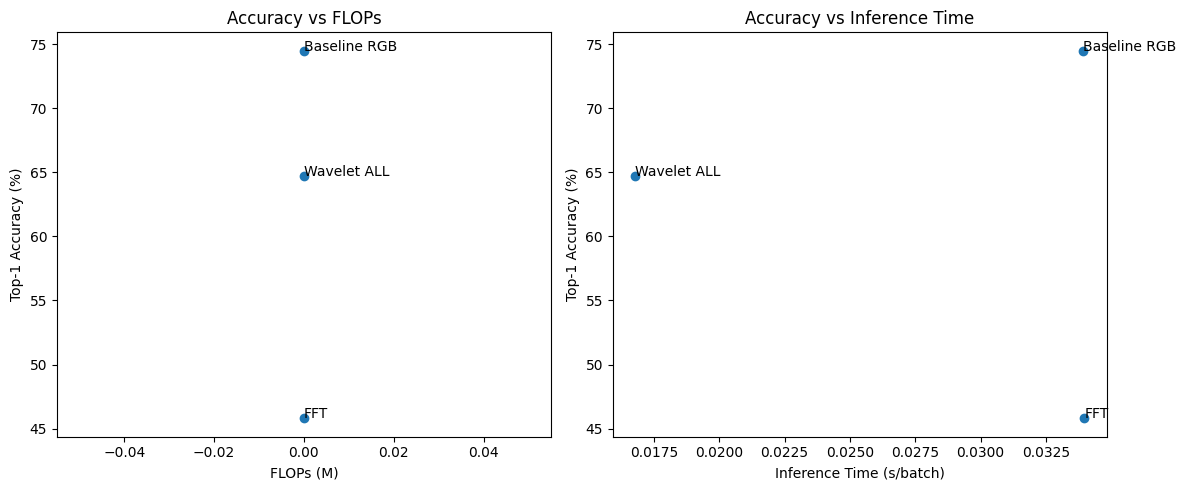


Baseline RGB       | Top-1: 74.50% | Top-3: 93.25% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet ALL        | Top-1: 64.75% | Top-3: 88.75% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M
FFT                | Top-1: 45.80% | Top-3: 78.00% | Time: 0.0340s | FLOPs: 0.00e+00 | Params: 6.96M


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
results = make_results()

baseline_model = base_model
baseline_top1 = evaluate_model(baseline_model, base_test_ds, device=device)
baseline_top3 = eval_topk(baseline_model, base_test_ds, k=3, device=device)
baseline_time = measure_inference_time(baseline_model, base_test_ds, device=device)
baseline_flops, baseline_params = compute_flops(baseline_model, base_test_ds, device=device)
add_result(results, "Baseline RGB", "main", "CIFAR10", len(train_subset), len(test_subset), baseline_top1, baseline_top3, baseline_time, baseline_flops, baseline_params)

wavelet_model = wave_model
wavelet_test = WaveletDataset(test_subset, use_subbands=[0, 1, 2, 3])
wavelet_top1 = evaluate_model(wavelet_model, wavelet_test, device=device)
wavelet_top3 = eval_topk(wavelet_model, wavelet_test, k=3, device=device)
wavelet_time = measure_inference_time(wavelet_model, wavelet_test, device=device)
wavelet_flops, wavelet_params = compute_flops(wavelet_model, wavelet_test, device=device)
add_result(results, "Wavelet ALL", "main", "CIFAR10", len(train_subset), len(test_subset), wavelet_top1, wavelet_top3, wavelet_time, wavelet_flops, wavelet_params)

fft_test = FFTDataset(test_subset)
fft_top1 = evaluate_model(fft_model, fft_test, device=device)
fft_top3 = eval_topk(fft_model, fft_test, k=3, device=device)
fft_time = measure_inference_time(fft_model, fft_test, device=device)
fft_flops, fft_params = compute_flops(fft_model, fft_test, device=device)
add_result(results, "FFT", "main", "CIFAR10", len(train_subset), len(test_subset), fft_top1, fft_top3, fft_time, fft_flops, fft_params)

plot_accuracy_tradeoffs(results, group="main", dataset_tag="CIFAR10")
print_summary(results, group="main", dataset_tag="CIFAR10")


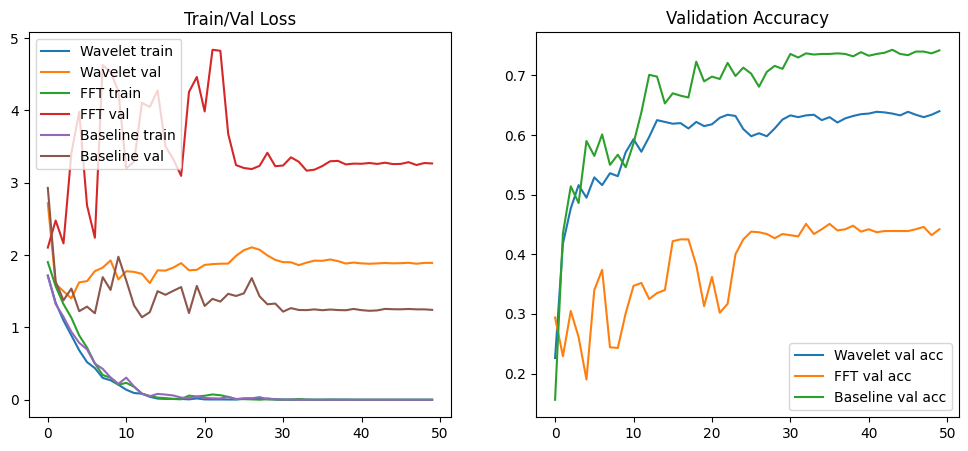

In [38]:
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(wave_hist["train_loss"], label="Wavelet train")
plt.plot(wave_hist["val_loss"],   label="Wavelet val")
plt.plot(fft_hist["train_loss"],  label="FFT train")
plt.plot(fft_hist["val_loss"],    label="FFT val")
plt.plot(base_hist["train_loss"], label="Baseline train")
plt.plot(base_hist["val_loss"],   label="Baseline val")
plt.title("Train/Val Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(wave_hist["val_acc"], label="Wavelet val acc")
plt.plot(fft_hist["val_acc"],  label="FFT val acc")
plt.plot(base_hist["val_acc"], label="Baseline val acc")
plt.title("Validation Accuracy")
plt.legend()
plt.show()

In [94]:
@torch.no_grad()
def eval_topk(model, dataset, k=3, batch_size=256, device='cuda'):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model = model.to(device).eval()

    total = 0
    topk_correct = 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)                      # [B,10]
        _, pred_topk = logits.topk(k, dim=1)   # [B,k]

        # check if true label is in any of the top-k predictions
        match = pred_topk.eq(y.unsqueeze(1))   # [B,k]
        topk_correct += match.any(dim=1).sum().item()
        total += y.size(0)

    return topk_correct / total

wave_top3 = eval_topk(wave_model, wave_test, k=3)
fft_top3  = eval_topk(fft_model, fft_test, k=3)
base_top3 = eval_topk(base_model, base_test, k=3)

print("\n=== Top-3 Accuracies ===")
print(f"Baseline (RGB):   {base_top3*100:.2f}%")
print(f"Wavelet (DWT12):  {wave_top3*100:.2f}%")
print(f"FFT (Mag+Phase):  {fft_top3*100:.2f}%")

wave_top3 = eval_topk(wave_model, wave_test, k=1)
fft_top3  = eval_topk(fft_model, fft_test, k=1)
base_top3 = eval_topk(base_model, base_test, k=1)

print("\n=== Top-1 Accuracies ===")
print(f"Baseline (RGB):   {base_top3*100:.2f}%")
print(f"Wavelet (DWT12):  {wave_top3*100:.2f}%")
print(f"FFT (Mag+Phase):  {fft_top3*100:.2f}%")



=== Top-3 Accuracies ===
Baseline (RGB):   93.00%
Wavelet (DWT12):  89.50%
FFT (Mag+Phase):  78.35%

=== Top-1 Accuracies ===
Baseline (RGB):   73.45%
Wavelet (DWT12):  64.95%
FFT (Mag+Phase):  45.30%


Confusion matrix + t-SNE analysis

Device: cuda
Baseline RGB Top-1/Top-3: [74.5, 93.25]
Wavelet Model Top-1/Top-3: [64.75, 88.75]
FFT Model Top-1/Top-3: [45.8, 78.0]

Confusion / per-class accuracy: Baseline


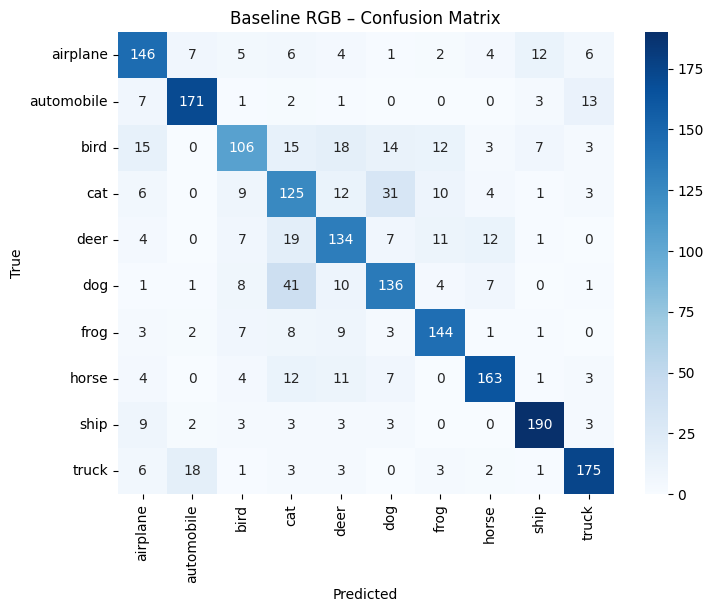

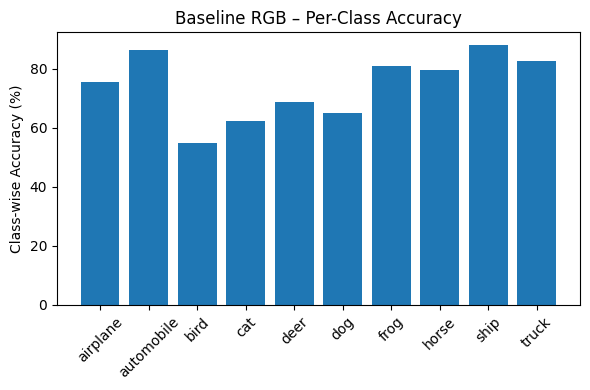


Confusion / per-class accuracy: Wavelet


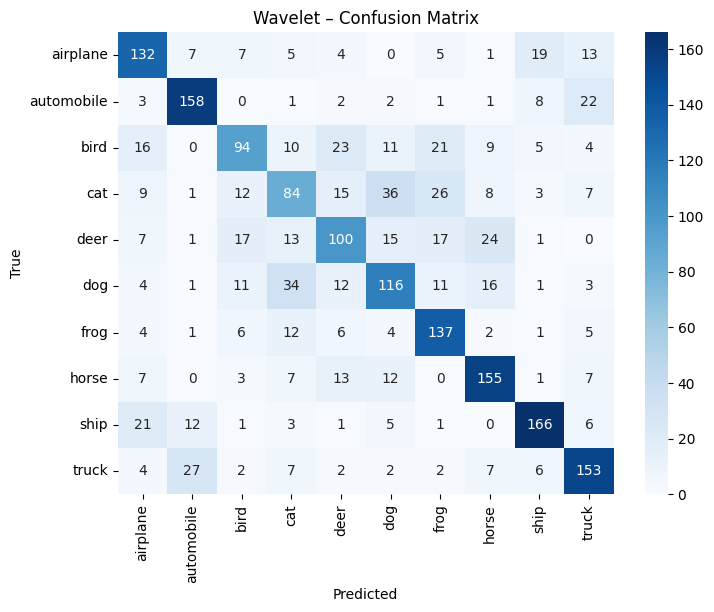

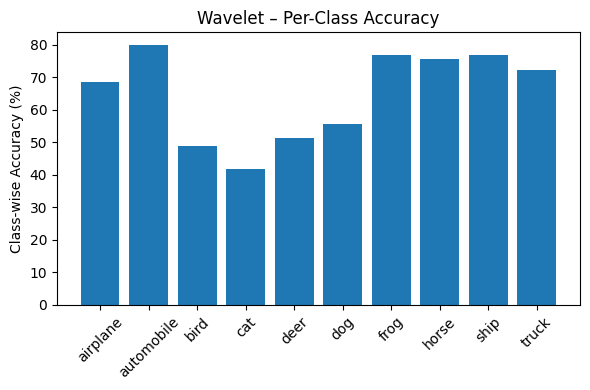


Confusion / per-class accuracy: FFT


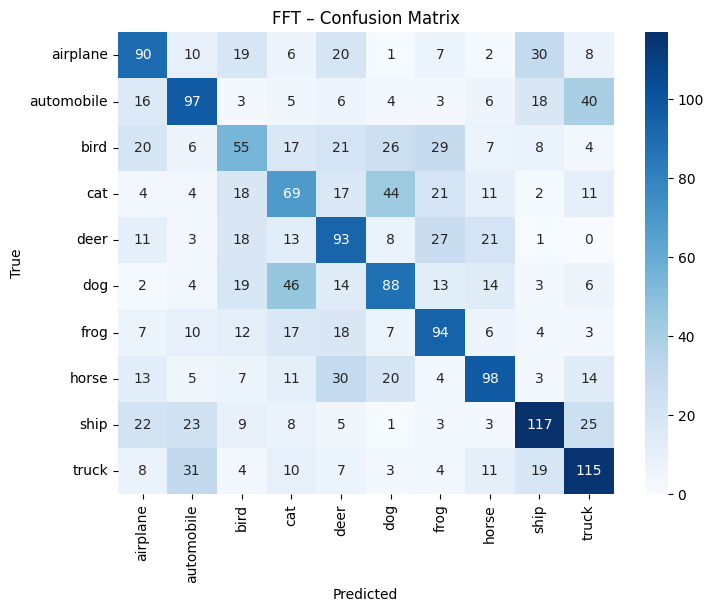

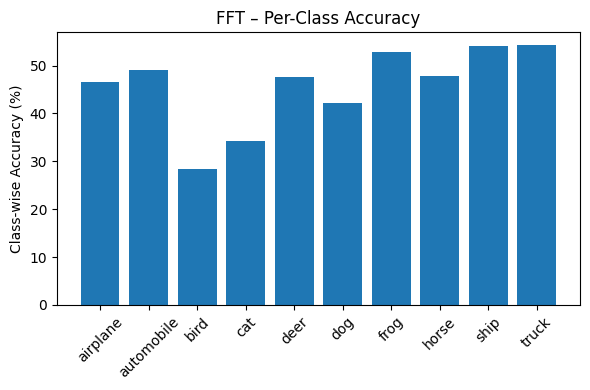


Profiling Baseline...


Unsupported operator aten::avg_pool2d encountered 3 time(s)


Profiling Wavelet...


Unsupported operator aten::avg_pool2d encountered 3 time(s)


Profiling FFT...


Unsupported operator aten::avg_pool2d encountered 3 time(s)



=== Model Complexity & Inference ===
Baseline RGB: FLOPs=898.07M | Params=6.96M | PeakMem=282.39616 MB | Time=0.0165s
Wavelet:      FLOPs=225.85M | Params=6.96M | PeakMem=252.585472 MB | Time=0.0168s
FFT:          FLOPs=899.84M | Params=6.96M | PeakMem=282.408448 MB | Time=0.0163s

Computing t-SNE (this can be slow)...


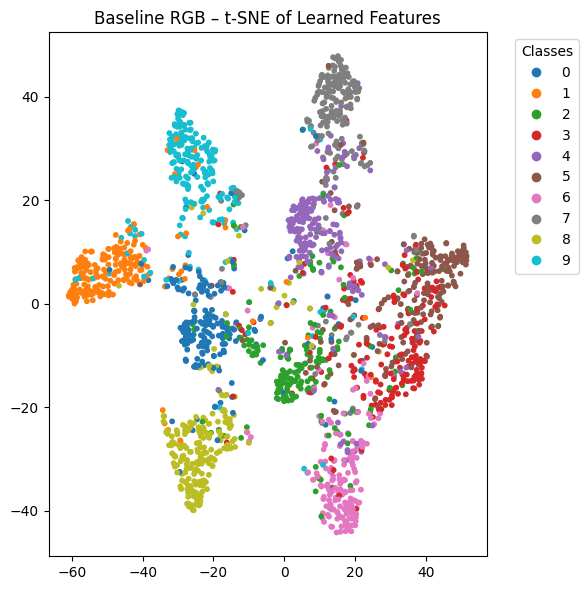

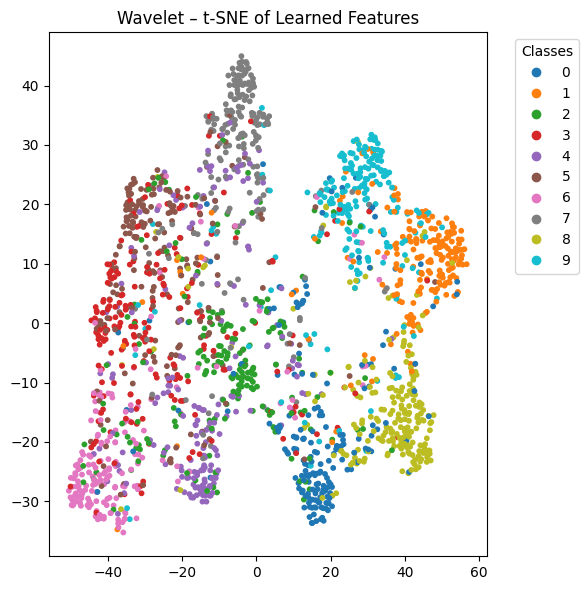

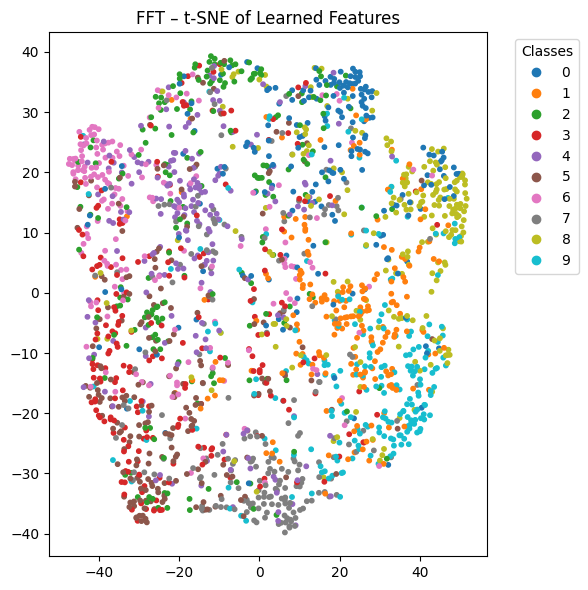

In [46]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import time
from fvcore.nn import FlopCountAnalysis

base_test = BaselineDataset(test_subset)
wavelet_test = WaveletDataset(test_subset, use_subbands=[0, 1, 2, 3])
fft_test = FFTDataset(test_subset)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

def topk_accuracy(model, dataset, topk=(1, 3), batch_size=64, device="cuda"):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model.eval().to(device)
    correct_topk = [0] * len(topk)
    total = 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            total += y.size(0)
            for i, k in enumerate(topk):
                pred = out.topk(k, dim=1)[1]
                correct_topk[i] += (pred == y.unsqueeze(1)).sum().item()
    return [100 * c / total for c in correct_topk]

baseline_topk = topk_accuracy(baseline_model, base_test, device=device)
wavelet_topk = topk_accuracy(wavelet_model, wavelet_test, device=device)
fft_topk = topk_accuracy(fft_model, fft_test, device=device)

print(f"Baseline RGB Top-1/Top-3: {baseline_topk}")
print(f"Wavelet Model Top-1/Top-3: {wavelet_topk}")
print(f"FFT Model Top-1/Top-3: {fft_topk}")

def plot_confusion(model, dataset, class_names, model_name="Model", device="cuda"):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval().to(device)
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            pred = model(x).argmax(dim=1)
            y_true.append(y.cpu())
            y_pred.append(pred.cpu())
    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()
    cm = confusion_matrix(y_true, y_pred)
    acc_per_class = cm.diagonal() / cm.sum(axis=1)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"{model_name} – Confusion Matrix")
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.bar(class_names, acc_per_class * 100)
    plt.ylabel("Class-wise Accuracy (%)")
    plt.title(f"{model_name} – Per-Class Accuracy")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return acc_per_class * 100

class_names = train_dataset.classes

print("\nConfusion / per-class accuracy: Baseline")
baseline_class_acc = plot_confusion(baseline_model, base_test, class_names, model_name="Baseline RGB", device=device)

print("\nConfusion / per-class accuracy: Wavelet")
wavelet_class_acc = plot_confusion(wavelet_model, wavelet_test, class_names, model_name="Wavelet", device=device)

print("\nConfusion / per-class accuracy: FFT")
fft_class_acc = plot_confusion(fft_model, fft_test, class_names, model_name="FFT", device=device)

def profile_model(model, dataset, batch_size=1, device="cuda"):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    model = model.to(device).eval()
    x, _ = next(iter(loader))
    x = x.to(device)

    flops = FlopCountAnalysis(model, x).total()
    params = sum(p.numel() for p in model.parameters())

    if device == "cuda":
        torch.cuda.reset_peak_memory_stats()
    _ = model(x)
    peak_mem = torch.cuda.max_memory_allocated() if device == "cuda" else None

    if device == "cuda":
        torch.cuda.synchronize()
    start = time.time()
    _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
    inf_time = time.time() - start

    return flops, params, peak_mem, inf_time

print("\nProfiling Baseline...")
baseline_flops, baseline_params, baseline_mem, baseline_time = profile_model(baseline_model, base_test, device=device)
print("Profiling Wavelet...")
wavelet_flops, wavelet_params, wavelet_mem, wavelet_time = profile_model(wavelet_model, wavelet_test, device=device)
print("Profiling FFT...")
fft_flops, fft_params, fft_mem, fft_time = profile_model(fft_model, fft_test, device=device)

def mem_mb(m):
    return m / 1e6 if m is not None else "N/A"

print("\n=== Model Complexity & Inference ===")
print(f"Baseline RGB: FLOPs={baseline_flops/1e6:.2f}M | Params={baseline_params/1e6:.2f}M | PeakMem={mem_mb(baseline_mem)} MB | Time={baseline_time:.4f}s")
print(f"Wavelet:      FLOPs={wavelet_flops/1e6:.2f}M | Params={wavelet_params/1e6:.2f}M | PeakMem={mem_mb(wavelet_mem)} MB | Time={wavelet_time:.4f}s")
print(f"FFT:          FLOPs={fft_flops/1e6:.2f}M | Params={fft_params/1e6:.2f}M | PeakMem={mem_mb(fft_mem)} MB | Time={fft_time:.4f}s")

def plot_tsne(model, dataset, model_name="Model", perplexity=30, device="cuda"):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    model.eval().to(device)
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            feat = model(x).flatten(1)
            feats.append(feat.cpu())
            labels.append(y)
    feats = torch.cat(feats).numpy()
    labels = torch.cat(labels).numpy()

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    emb = tsne.fit_transform(feats)

    plt.figure(figsize=(6, 6))
    scatter = plt.scatter(emb[:, 0], emb[:, 1], c=labels, cmap="tab10", s=10)
    plt.legend(*scatter.legend_elements(), title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title(f"{model_name} – t-SNE of Learned Features")
    plt.tight_layout()
    plt.show()
    return emb, labels

print("\nComputing t-SNE (this can be slow)...")
_ = plot_tsne(baseline_model, base_test, model_name="Baseline RGB", device=device)
_ = plot_tsne(wavelet_model, wavelet_test, model_name="Wavelet", device=device)
_ = plot_tsne(fft_model, fft_test, model_name="FFT", device=device)


# subband ablation

[Wavelet-LL] ep=1 lr=0.000999 train=1.7490 val=2.6123 acc=17.80%


[Wavelet-LL] ep=2 lr=0.000996 train=1.3431 val=1.5923 acc=44.40%


[Wavelet-LL] ep=3 lr=0.000991 train=1.1157 val=1.4191 acc=50.70%


[Wavelet-LL] ep=4 lr=0.000984 train=0.9193 val=2.1386 acc=36.60%


[Wavelet-LL] ep=5 lr=0.000976 train=0.7290 val=1.5044 acc=51.30%


[Wavelet-LL] ep=6 lr=0.000965 train=0.5357 val=1.7309 acc=49.60%


[Wavelet-LL] ep=7 lr=0.000953 train=0.4116 val=1.9438 acc=49.40%


[Wavelet-LL] ep=8 lr=0.000939 train=0.3387 val=1.6695 acc=52.30%


[Wavelet-LL] ep=9 lr=0.000923 train=0.1962 val=1.7077 acc=55.10%


[Wavelet-LL] ep=10 lr=0.000905 train=0.3011 val=1.6345 acc=56.00%


[Wavelet-LL] ep=11 lr=0.000886 train=0.1593 val=2.0932 acc=55.40%


[Wavelet-LL] ep=12 lr=0.000866 train=0.1619 val=2.0583 acc=53.50%


[Wavelet-LL] ep=13 lr=0.000844 train=0.1082 val=1.8245 acc=57.00%


[Wavelet-LL] ep=14 lr=0.000821 train=0.0512 val=1.7131 acc=59.80%


[Wavelet-LL] ep=15 lr=0.000796 train=0.0217 val=1.6845 acc=62.10%


[Wavelet-LL] ep=16 lr=0.000770 train=0.0275 val=1.7647 acc=60.60%


[Wavelet-LL] ep=17 lr=0.000743 train=0.0378 val=1.8536 acc=60.20%


[Wavelet-LL] ep=18 lr=0.000716 train=0.0340 val=1.8206 acc=62.60%


[Wavelet-LL] ep=19 lr=0.000687 train=0.0518 val=1.8392 acc=60.10%


[Wavelet-LL] ep=20 lr=0.000658 train=0.0562 val=1.7493 acc=60.70%


[Wavelet-LL] ep=21 lr=0.000628 train=0.0592 val=1.8640 acc=59.60%


[Wavelet-LL] ep=22 lr=0.000598 train=0.0364 val=1.8438 acc=61.70%


[Wavelet-LL] ep=23 lr=0.000567 train=0.0440 val=1.7775 acc=61.00%


[Wavelet-LL] ep=24 lr=0.000536 train=0.0172 val=1.7083 acc=62.90%


[Wavelet-LL] ep=25 lr=0.000505 train=0.0050 val=1.7014 acc=62.80%


[Wavelet-LL] ep=26 lr=0.000474 train=0.0019 val=1.7008 acc=62.70%


[Wavelet-LL] ep=27 lr=0.000443 train=0.0043 val=1.6796 acc=63.30%


[Wavelet-LL] ep=28 lr=0.000412 train=0.0011 val=1.7016 acc=62.80%


[Wavelet-LL] ep=29 lr=0.000382 train=0.0007 val=1.6887 acc=63.80%


[Wavelet-LL] ep=30 lr=0.000352 train=0.0006 val=1.7016 acc=63.70%


[Wavelet-LL] ep=31 lr=0.000323 train=0.0005 val=1.7067 acc=63.00%


[Wavelet-LL] ep=32 lr=0.000294 train=0.0012 val=1.7242 acc=63.10%


[Wavelet-LL] ep=33 lr=0.000267 train=0.0005 val=1.7179 acc=64.60%


[Wavelet-LL] ep=34 lr=0.000240 train=0.0007 val=1.7279 acc=63.70%


[Wavelet-LL] ep=35 lr=0.000214 train=0.0005 val=1.7336 acc=62.90%


[Wavelet-LL] ep=36 lr=0.000189 train=0.0004 val=1.7170 acc=63.40%


[Wavelet-LL] ep=37 lr=0.000166 train=0.0004 val=1.7108 acc=63.10%


[Wavelet-LL] ep=38 lr=0.000144 train=0.0004 val=1.7125 acc=64.30%


[Wavelet-LL] ep=39 lr=0.000124 train=0.0004 val=1.7111 acc=63.50%


[Wavelet-LL] ep=40 lr=0.000105 train=0.0004 val=1.7559 acc=63.80%


[Wavelet-LL] ep=41 lr=0.000087 train=0.0004 val=1.7431 acc=63.70%


[Wavelet-LL] ep=42 lr=0.000071 train=0.0003 val=1.7353 acc=63.50%


[Wavelet-LL] ep=43 lr=0.000057 train=0.0003 val=1.7302 acc=63.40%


[Wavelet-LL] ep=44 lr=0.000045 train=0.0003 val=1.7421 acc=63.80%


[Wavelet-LL] ep=45 lr=0.000034 train=0.0003 val=1.7292 acc=63.80%


[Wavelet-LL] ep=46 lr=0.000026 train=0.0003 val=1.7280 acc=63.60%


[Wavelet-LL] ep=47 lr=0.000019 train=0.0003 val=1.7333 acc=63.80%


[Wavelet-LL] ep=48 lr=0.000014 train=0.0003 val=1.7167 acc=63.70%


[Wavelet-LL] ep=49 lr=0.000011 train=0.0003 val=1.7369 acc=63.50%


[Wavelet-LL] ep=50 lr=0.000010 train=0.0003 val=1.7320 acc=63.90%


[Wavelet-LH] ep=1 lr=0.000999 train=1.8998 val=4.0886 acc=9.80%


[Wavelet-LH] ep=2 lr=0.000996 train=1.4011 val=1.9142 acc=36.90%


[Wavelet-LH] ep=3 lr=0.000991 train=1.0770 val=1.8943 acc=41.40%


[Wavelet-LH] ep=4 lr=0.000984 train=0.8046 val=1.8460 acc=43.60%


[Wavelet-LH] ep=5 lr=0.000976 train=0.5438 val=1.6570 acc=51.50%


[Wavelet-LH] ep=6 lr=0.000965 train=0.3805 val=1.8807 acc=50.10%


[Wavelet-LH] ep=7 lr=0.000953 train=0.2448 val=2.7746 acc=40.80%


[Wavelet-LH] ep=8 lr=0.000939 train=0.2578 val=2.5000 acc=43.70%


[Wavelet-LH] ep=9 lr=0.000923 train=0.1727 val=2.0287 acc=50.60%


[Wavelet-LH] ep=10 lr=0.000905 train=0.0912 val=1.9442 acc=54.70%


[Wavelet-LH] ep=11 lr=0.000886 train=0.0590 val=2.0541 acc=55.10%


[Wavelet-LH] ep=12 lr=0.000866 train=0.0626 val=2.3016 acc=50.70%


[Wavelet-LH] ep=13 lr=0.000844 train=0.0811 val=2.1566 acc=54.00%


[Wavelet-LH] ep=14 lr=0.000821 train=0.0874 val=2.1619 acc=55.00%


[Wavelet-LH] ep=15 lr=0.000796 train=0.0574 val=2.1728 acc=53.10%


[Wavelet-LH] ep=16 lr=0.000770 train=0.0339 val=2.2178 acc=55.60%


[Wavelet-LH] ep=17 lr=0.000743 train=0.0179 val=2.0598 acc=57.30%


[Wavelet-LH] ep=18 lr=0.000716 train=0.0302 val=2.4574 acc=53.30%


[Wavelet-LH] ep=19 lr=0.000687 train=0.0097 val=2.1069 acc=57.20%


[Wavelet-LH] ep=20 lr=0.000658 train=0.0224 val=2.2539 acc=55.60%


[Wavelet-LH] ep=21 lr=0.000628 train=0.0075 val=2.1482 acc=57.30%


[Wavelet-LH] ep=22 lr=0.000598 train=0.0016 val=2.0696 acc=59.20%


[Wavelet-LH] ep=23 lr=0.000567 train=0.0008 val=2.0465 acc=59.00%


[Wavelet-LH] ep=24 lr=0.000536 train=0.0006 val=2.0754 acc=59.10%


[Wavelet-LH] ep=25 lr=0.000505 train=0.0008 val=2.0890 acc=59.20%


[Wavelet-LH] ep=26 lr=0.000474 train=0.0005 val=2.0860 acc=59.20%


[Wavelet-LH] ep=27 lr=0.000443 train=0.0006 val=2.1577 acc=57.90%


[Wavelet-LH] ep=28 lr=0.000412 train=0.0109 val=2.2066 acc=57.30%


[Wavelet-LH] ep=29 lr=0.000382 train=0.0020 val=2.1565 acc=57.00%


[Wavelet-LH] ep=30 lr=0.000352 train=0.0010 val=2.1527 acc=57.30%


[Wavelet-LH] ep=31 lr=0.000323 train=0.0013 val=2.1616 acc=57.70%


[Wavelet-LH] ep=32 lr=0.000294 train=0.0161 val=2.2918 acc=55.30%


[Wavelet-LH] ep=33 lr=0.000267 train=0.0039 val=2.2894 acc=55.80%


[Wavelet-LH] ep=34 lr=0.000240 train=0.0012 val=2.1977 acc=57.00%


[Wavelet-LH] ep=35 lr=0.000214 train=0.0007 val=2.2042 acc=57.30%


[Wavelet-LH] ep=36 lr=0.000189 train=0.0007 val=2.2013 acc=57.20%


[Wavelet-LH] ep=37 lr=0.000166 train=0.0029 val=2.2860 acc=56.70%


[Wavelet-LH] ep=38 lr=0.000144 train=0.0009 val=2.2268 acc=57.50%


[Wavelet-LH] ep=39 lr=0.000124 train=0.0038 val=2.2602 acc=57.50%


[Wavelet-LH] ep=40 lr=0.000105 train=0.0016 val=2.2189 acc=58.20%


[Wavelet-LH] ep=41 lr=0.000087 train=0.0018 val=2.2263 acc=56.70%


[Wavelet-LH] ep=42 lr=0.000071 train=0.0033 val=2.2399 acc=56.70%


[Wavelet-LH] ep=43 lr=0.000057 train=0.0008 val=2.2200 acc=57.70%


[Wavelet-LH] ep=44 lr=0.000045 train=0.0006 val=2.2240 acc=57.10%


[Wavelet-LH] ep=45 lr=0.000034 train=0.0006 val=2.2181 acc=57.40%


[Wavelet-LH] ep=46 lr=0.000026 train=0.0005 val=2.2304 acc=57.10%


[Wavelet-LH] ep=47 lr=0.000019 train=0.0005 val=2.2154 acc=57.20%


[Wavelet-LH] ep=48 lr=0.000014 train=0.0005 val=2.2389 acc=58.00%


[Wavelet-LH] ep=49 lr=0.000011 train=0.0005 val=2.2265 acc=57.70%


[Wavelet-LH] ep=50 lr=0.000010 train=0.0005 val=2.2160 acc=57.10%


[Wavelet-HL] ep=1 lr=0.000999 train=1.7917 val=4.8103 acc=9.80%


[Wavelet-HL] ep=2 lr=0.000996 train=1.3379 val=2.0728 acc=30.70%


[Wavelet-HL] ep=3 lr=0.000991 train=1.0779 val=1.5794 acc=44.40%


[Wavelet-HL] ep=4 lr=0.000984 train=0.8076 val=1.9757 acc=44.80%


[Wavelet-HL] ep=5 lr=0.000976 train=0.5478 val=2.3392 acc=41.80%


[Wavelet-HL] ep=6 lr=0.000965 train=0.4652 val=1.7952 acc=49.40%


[Wavelet-HL] ep=7 lr=0.000953 train=0.3023 val=2.2532 acc=46.90%


[Wavelet-HL] ep=8 lr=0.000939 train=0.2482 val=1.9401 acc=50.00%


[Wavelet-HL] ep=9 lr=0.000923 train=0.1448 val=1.9739 acc=53.20%


[Wavelet-HL] ep=10 lr=0.000905 train=0.1398 val=2.0897 acc=52.60%


[Wavelet-HL] ep=11 lr=0.000886 train=0.1916 val=2.0059 acc=54.10%


[Wavelet-HL] ep=12 lr=0.000866 train=0.1127 val=2.5169 acc=47.90%


[Wavelet-HL] ep=13 lr=0.000844 train=0.0758 val=2.0257 acc=55.90%


[Wavelet-HL] ep=14 lr=0.000821 train=0.0338 val=1.7934 acc=59.10%


[Wavelet-HL] ep=15 lr=0.000796 train=0.0067 val=1.7922 acc=58.80%


[Wavelet-HL] ep=16 lr=0.000770 train=0.0022 val=1.7772 acc=59.40%


[Wavelet-HL] ep=17 lr=0.000743 train=0.0024 val=1.8381 acc=58.80%


[Wavelet-HL] ep=18 lr=0.000716 train=0.0078 val=1.9624 acc=57.80%


[Wavelet-HL] ep=19 lr=0.000687 train=0.0030 val=1.9642 acc=57.30%


[Wavelet-HL] ep=20 lr=0.000658 train=0.0019 val=1.9569 acc=57.50%


[Wavelet-HL] ep=21 lr=0.000628 train=0.0008 val=1.9370 acc=58.40%


[Wavelet-HL] ep=22 lr=0.000598 train=0.0006 val=1.9356 acc=58.70%


[Wavelet-HL] ep=23 lr=0.000567 train=0.0005 val=1.9370 acc=58.70%


[Wavelet-HL] ep=24 lr=0.000536 train=0.0004 val=1.9448 acc=58.90%


[Wavelet-HL] ep=25 lr=0.000505 train=0.0004 val=1.9392 acc=58.80%


[Wavelet-HL] ep=26 lr=0.000474 train=0.0005 val=1.9454 acc=58.90%


[Wavelet-HL] ep=27 lr=0.000443 train=0.0006 val=1.9878 acc=58.40%


[Wavelet-HL] ep=28 lr=0.000412 train=0.0007 val=2.0542 acc=57.70%


[Wavelet-HL] ep=29 lr=0.000382 train=0.0139 val=2.1951 acc=57.30%


[Wavelet-HL] ep=30 lr=0.000352 train=0.0031 val=2.0857 acc=57.70%


[Wavelet-HL] ep=31 lr=0.000323 train=0.0024 val=2.1159 acc=57.90%


[Wavelet-HL] ep=32 lr=0.000294 train=0.0071 val=2.0740 acc=58.10%


[Wavelet-HL] ep=33 lr=0.000267 train=0.0019 val=2.0808 acc=57.40%


[Wavelet-HL] ep=34 lr=0.000240 train=0.0012 val=2.1098 acc=57.30%


[Wavelet-HL] ep=35 lr=0.000214 train=0.0007 val=2.0577 acc=58.20%


[Wavelet-HL] ep=36 lr=0.000189 train=0.0005 val=2.0613 acc=58.40%


[Wavelet-HL] ep=37 lr=0.000166 train=0.0004 val=2.0539 acc=58.10%


[Wavelet-HL] ep=38 lr=0.000144 train=0.0004 val=2.0582 acc=58.20%


[Wavelet-HL] ep=39 lr=0.000124 train=0.0004 val=2.0727 acc=58.20%


[Wavelet-HL] ep=40 lr=0.000105 train=0.0004 val=2.0485 acc=58.20%


[Wavelet-HL] ep=41 lr=0.000087 train=0.0003 val=2.0578 acc=58.50%


[Wavelet-HL] ep=42 lr=0.000071 train=0.0004 val=2.0739 acc=58.00%


[Wavelet-HL] ep=43 lr=0.000057 train=0.0003 val=2.0734 acc=57.90%


[Wavelet-HL] ep=44 lr=0.000045 train=0.0003 val=2.0530 acc=58.30%


[Wavelet-HL] ep=45 lr=0.000034 train=0.0004 val=2.0398 acc=58.60%


[Wavelet-HL] ep=46 lr=0.000026 train=0.0004 val=2.0520 acc=58.60%


[Wavelet-HL] ep=47 lr=0.000019 train=0.0003 val=2.0598 acc=58.80%


[Wavelet-HL] ep=48 lr=0.000014 train=0.0003 val=2.0499 acc=58.80%


[Wavelet-HL] ep=49 lr=0.000011 train=0.0003 val=2.0631 acc=58.50%


[Wavelet-HL] ep=50 lr=0.000010 train=0.0003 val=2.0644 acc=58.60%


[Wavelet-HH] ep=1 lr=0.000999 train=1.9944 val=4.6849 acc=9.80%


[Wavelet-HH] ep=2 lr=0.000996 train=1.6713 val=2.6718 acc=19.20%


[Wavelet-HH] ep=3 lr=0.000991 train=1.4236 val=2.0146 acc=30.80%


[Wavelet-HH] ep=4 lr=0.000984 train=1.1513 val=1.7854 acc=41.20%


[Wavelet-HH] ep=5 lr=0.000976 train=0.8675 val=3.3260 acc=30.50%


[Wavelet-HH] ep=6 lr=0.000965 train=0.6698 val=2.5450 acc=35.20%


[Wavelet-HH] ep=7 lr=0.000953 train=0.4347 val=2.4100 acc=37.70%


[Wavelet-HH] ep=8 lr=0.000939 train=0.3390 val=3.1377 acc=34.90%


[Wavelet-HH] ep=9 lr=0.000923 train=0.2540 val=2.8547 acc=40.00%


[Wavelet-HH] ep=10 lr=0.000905 train=0.1954 val=3.2769 acc=35.20%


[Wavelet-HH] ep=11 lr=0.000886 train=0.1783 val=2.6098 acc=41.80%


[Wavelet-HH] ep=12 lr=0.000866 train=0.0873 val=2.7691 acc=40.60%


[Wavelet-HH] ep=13 lr=0.000844 train=0.0438 val=2.6875 acc=43.80%


[Wavelet-HH] ep=14 lr=0.000821 train=0.0212 val=3.9720 acc=34.20%


[Wavelet-HH] ep=15 lr=0.000796 train=0.0434 val=3.5390 acc=40.40%


[Wavelet-HH] ep=16 lr=0.000770 train=0.0185 val=2.9243 acc=41.80%


[Wavelet-HH] ep=17 lr=0.000743 train=0.0099 val=2.8240 acc=43.70%


[Wavelet-HH] ep=18 lr=0.000716 train=0.0100 val=2.8354 acc=45.00%


[Wavelet-HH] ep=19 lr=0.000687 train=0.0061 val=2.8475 acc=46.80%


[Wavelet-HH] ep=20 lr=0.000658 train=0.0147 val=2.9456 acc=44.80%


[Wavelet-HH] ep=21 lr=0.000628 train=0.0059 val=3.0719 acc=44.60%


[Wavelet-HH] ep=22 lr=0.000598 train=0.0132 val=2.9075 acc=46.40%


[Wavelet-HH] ep=23 lr=0.000567 train=0.0059 val=3.0187 acc=43.50%


[Wavelet-HH] ep=24 lr=0.000536 train=0.0025 val=2.9092 acc=45.90%


[Wavelet-HH] ep=25 lr=0.000505 train=0.0009 val=2.9050 acc=46.10%


[Wavelet-HH] ep=26 lr=0.000474 train=0.0006 val=2.9045 acc=46.70%


[Wavelet-HH] ep=27 lr=0.000443 train=0.0004 val=2.8927 acc=47.20%


[Wavelet-HH] ep=28 lr=0.000412 train=0.0004 val=2.9084 acc=46.80%


[Wavelet-HH] ep=29 lr=0.000382 train=0.0005 val=2.8938 acc=46.20%


[Wavelet-HH] ep=30 lr=0.000352 train=0.0006 val=2.9262 acc=46.40%


[Wavelet-HH] ep=31 lr=0.000323 train=0.0073 val=3.0426 acc=45.20%


[Wavelet-HH] ep=32 lr=0.000294 train=0.0012 val=2.9530 acc=46.50%


[Wavelet-HH] ep=33 lr=0.000267 train=0.0007 val=2.9250 acc=46.50%


[Wavelet-HH] ep=34 lr=0.000240 train=0.0006 val=2.9305 acc=46.20%


[Wavelet-HH] ep=35 lr=0.000214 train=0.0004 val=2.9086 acc=46.70%


[Wavelet-HH] ep=36 lr=0.000189 train=0.0004 val=2.9049 acc=46.80%


[Wavelet-HH] ep=37 lr=0.000166 train=0.0004 val=2.9072 acc=46.40%


[Wavelet-HH] ep=38 lr=0.000144 train=0.0003 val=2.9050 acc=46.30%


[Wavelet-HH] ep=39 lr=0.000124 train=0.0003 val=2.8905 acc=47.80%


[Wavelet-HH] ep=40 lr=0.000105 train=0.0006 val=2.9493 acc=46.50%


[Wavelet-HH] ep=41 lr=0.000087 train=0.0003 val=2.9284 acc=46.40%


[Wavelet-HH] ep=42 lr=0.000071 train=0.0003 val=2.9325 acc=46.30%


[Wavelet-HH] ep=43 lr=0.000057 train=0.0004 val=2.9280 acc=46.40%


[Wavelet-HH] ep=44 lr=0.000045 train=0.0003 val=2.9340 acc=46.70%


[Wavelet-HH] ep=45 lr=0.000034 train=0.0003 val=2.9421 acc=47.30%


[Wavelet-HH] ep=46 lr=0.000026 train=0.0003 val=2.9332 acc=46.80%


[Wavelet-HH] ep=47 lr=0.000019 train=0.0005 val=2.9283 acc=47.40%


[Wavelet-HH] ep=48 lr=0.000014 train=0.0003 val=2.9305 acc=46.70%


[Wavelet-HH] ep=49 lr=0.000011 train=0.0003 val=2.9338 acc=47.10%


[Wavelet-HH] ep=50 lr=0.000010 train=0.0003 val=2.9509 acc=47.10%


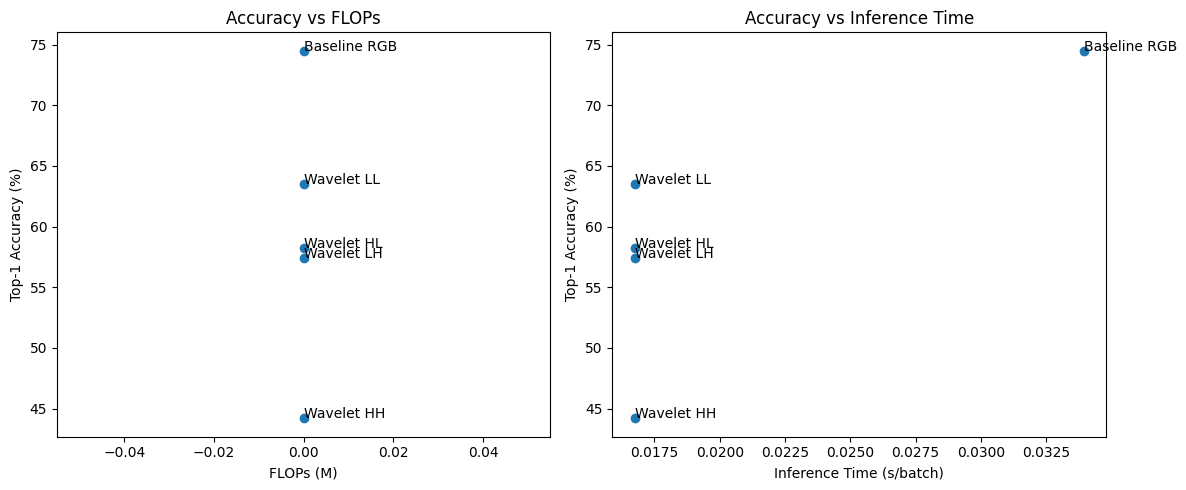

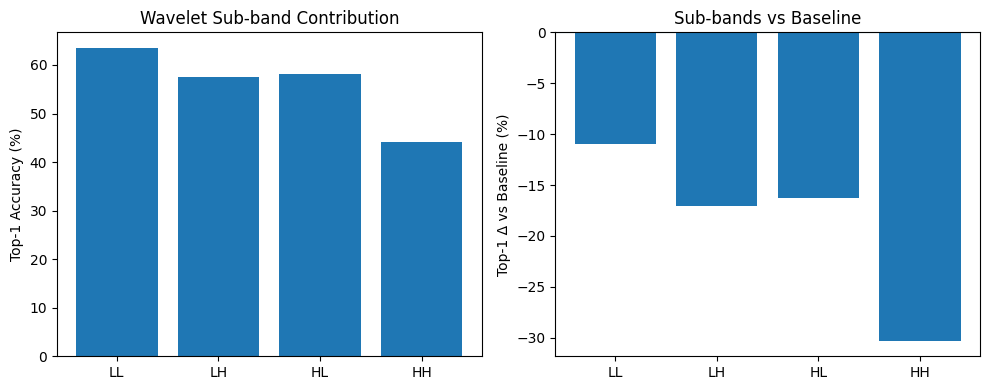


Baseline RGB       | Top-1: 74.50% | Top-3: 93.25% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet LL         | Top-1: 63.55% | Top-3: 89.55% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet LH         | Top-1: 57.45% | Top-3: 83.60% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet HL         | Top-1: 58.20% | Top-3: 85.85% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet HH         | Top-1: 44.20% | Top-3: 74.10% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M


In [30]:
subbands = {"LL": [0], "LH": [1], "HL": [2], "HH": [3]}

baseline_in_subband_view_top1 = evaluate_model(baseline_model, base_test_ds, device=device)
baseline_in_subband_view_top3 = eval_topk(baseline_model, base_test_ds, k=3, device=device)
baseline_in_subband_view_time = measure_inference_time(baseline_model, base_test_ds, device=device)
baseline_in_subband_view_flops, baseline_in_subband_view_params = compute_flops(baseline_model, base_test_ds, device=device)
add_result(results, "Baseline RGB", "subbands", "CIFAR10", len(train_subset), len(test_subset), baseline_in_subband_view_top1, baseline_in_subband_view_top3, baseline_in_subband_view_time, baseline_in_subband_view_flops, baseline_in_subband_view_params)

for name, bands in subbands.items():
    train_ds = WaveletDataset(train_subset, use_subbands=bands)
    test_ds = WaveletDataset(test_subset, use_subbands=bands)
    w_train_loader, w_val_loader = get_loaders(train_ds, val_frac=0.1, batch=256, seed=123)
    model = WaveletDenseNet(in_ch=len(bands) * 3, num_classes=10)
    model, hist = train_model(model, w_train_loader, w_val_loader, epochs=50, desc=f"Wavelet-{name}")
    top1 = evaluate_model(model, test_ds, device=device)
    top3 = eval_topk(model, test_ds, k=3, device=device)
    t = measure_inference_time(model, test_ds, device=device)
    f, p = compute_flops(model, test_ds, device=device)
    add_result(results, f"Wavelet {name}", "subbands", "CIFAR10", len(train_subset), len(test_subset), top1, top3, t, f, p)

plot_accuracy_tradeoffs(results, group="subbands", dataset_tag="CIFAR10")

rows = [r for r in results if r["group"] == "subbands" and r["dataset"] == "CIFAR10"]
sub_rows = [r for r in rows if r["model"].startswith("Wavelet ")]
baseline_row = [r for r in rows if r["model"] == "Baseline RGB"][0]

sub_names = [r["model"].split()[-1] for r in sub_rows]
sub_accs = [r["top1"] for r in sub_rows]
sub_deltas = [r["top1"] - baseline_row["top1"] for r in sub_rows]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.bar(sub_names, sub_accs)
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Wavelet Sub-band Contribution")

plt.subplot(1, 2, 2)
plt.bar(sub_names, sub_deltas)
plt.axhline(0.0)
plt.ylabel("Top-1 Δ vs Baseline (%)")
plt.title("Sub-bands vs Baseline")
plt.tight_layout()
plt.show()

print_summary(results, group="subbands", dataset_tag="CIFAR10")


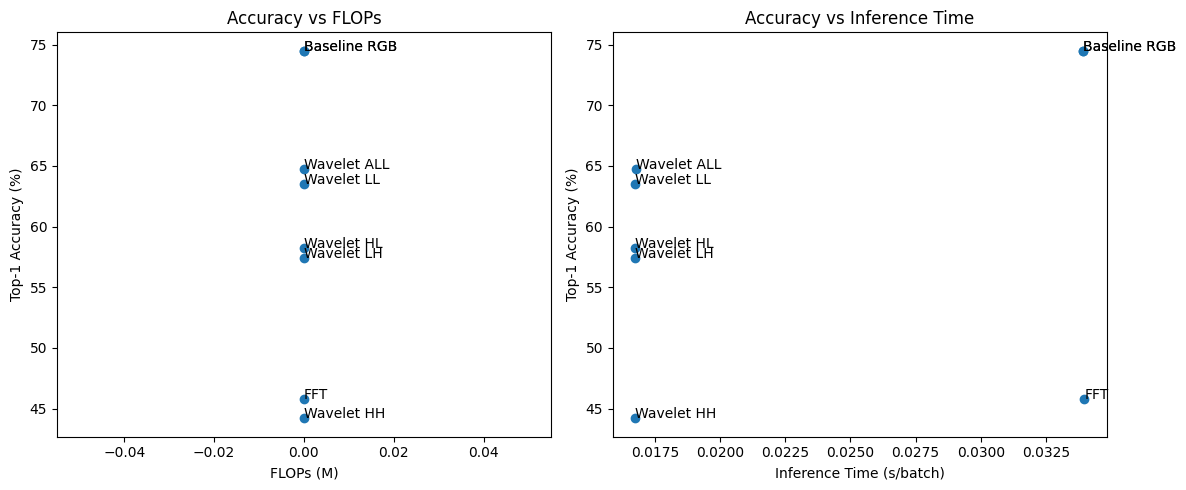

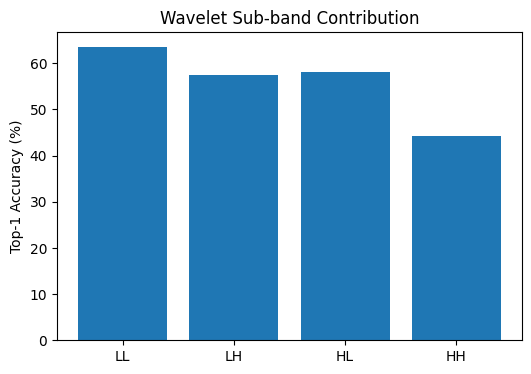


 SUMMARY 

Baseline RGB       | Top-1: 74.50% | Top-3: 93.25% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet ALL        | Top-1: 64.75% | Top-3: 88.75% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M
FFT                | Top-1: 45.80% | Top-3: 78.00% | Time: 0.0340s | FLOPs: 0.00e+00 | Params: 6.96M
Baseline RGB       | Top-1: 74.50% | Top-3: 93.25% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet LL         | Top-1: 63.55% | Top-3: 89.55% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet LH         | Top-1: 57.45% | Top-3: 83.60% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet HL         | Top-1: 58.20% | Top-3: 85.85% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet HH         | Top-1: 44.20% | Top-3: 74.10% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M


In [44]:
rows = [r for r in results if r.get("group") != "data_eff" and not ("(n=" in r.get("model", ""))]

names  = [r["model"] for r in rows]
top1s  = [r["top1"] for r in rows]
top3s  = [r["topk"] for r in rows]
flopsM = [r["flops"] / 1e6 for r in rows]
times  = [r["time"] for r in rows]
paramsM = [r["params"] / 1e6 for r in rows]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(flopsM, top1s)
for i, label in enumerate(names):
    plt.annotate(label, (flopsM[i], top1s[i]))
plt.xlabel("FLOPs (M)")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Accuracy vs FLOPs")

plt.subplot(1, 2, 2)
plt.scatter(times, top1s)
for i, label in enumerate(names):
    plt.annotate(label, (times[i], top1s[i]))
plt.xlabel("Inference Time (s/batch)")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Accuracy vs Inference Time")

plt.tight_layout()
plt.show()

sub_rows = [r for r in rows if r["model"].startswith("Wavelet ") and r["model"] != "Wavelet ALL"]
sub_names = [r["model"].split()[-1] for r in sub_rows]
sub_top1s = [r["top1"] for r in sub_rows]

plt.figure(figsize=(6, 4))
plt.bar(sub_names, sub_top1s)
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Wavelet Sub-band Contribution")
plt.show()

print("\n SUMMARY \n")
for r in rows:
    print(
        f"{r['model']:18s} | "
        f"Top-1: {r['top1']:.2f}% | "
        f"Top-3: {r['topk']:.2f}% | "
        f"Time: {r['time']:.4f}s | "
        f"FLOPs: {r['flops']:.2e} | "
        f"Params: {r['params']/1e6:.2f}M"
    )


# different wavelet families ablation

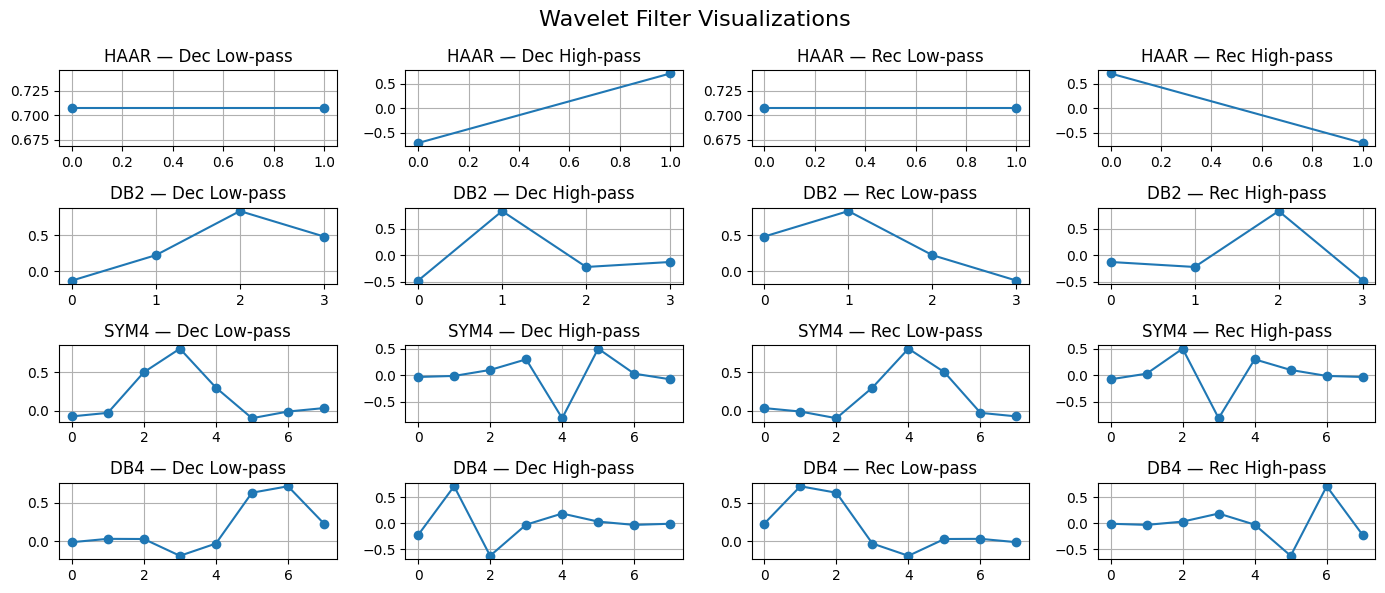

In [2]:
import pywt
import matplotlib.pyplot as plt
import numpy as np

wavelet_names = ["haar", "db2",  "sym4", "db4"]

fig, axes = plt.subplots(len(wavelet_names), 4, figsize=(14, 6))
plt.suptitle("Wavelet Filter Visualizations", fontsize=16)

for i, wname in enumerate(wavelet_names):
    wave = pywt.Wavelet(wname)

    # Decomposition filters
    dec_lo = wave.dec_lo   # h_lo
    dec_hi = wave.dec_hi   # h_hi

    # Reconstruction filters
    rec_lo = wave.rec_lo   # g_lo
    rec_hi = wave.rec_hi   # g_hi

    filters = [dec_lo, dec_hi, rec_lo, rec_hi]
    titles  = ["Dec Low-pass", "Dec High-pass", "Rec Low-pass", "Rec High-pass"]

    for j, (filt, title) in enumerate(zip(filters, titles)):
        ax = axes[i, j]
        ax.plot(filt, marker="o")
        ax.set_title(f"{wname.upper()} — {title}")
        ax.grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()


In [51]:
class WaveletDatasetGeneral(Dataset):
    def __init__(self, base_dataset, use_subbands=(0, 1, 2, 3), wavelet="haar", mode="periodization", level=1):
        self.base = base_dataset
        self.use_subbands = list(use_subbands)
        self.wavelet = wavelet
        self.mode = mode
        self.level = int(level)

    def __len__(self):
        return len(self.base)

    def _dwt_level1(self, img_ch):
        LL, (LH, HL, HH) = pywt.dwt2(img_ch, self.wavelet, mode=self.mode)
        return LL, LH, HL, HH

    def __getitem__(self, idx):
        x, y = self.base[idx]

        if not torch.is_tensor(x):
            x = torch.as_tensor(np.array(x)).permute(2, 0, 1)

        x = x.float()
        C, H, W = x.shape

        LLs, LHs, HLs, HHs = [], [], [], []

        for c in range(C):
            arr = x[c].detach().cpu().numpy()
            LL, LH, HL, HH = self._dwt_level1(arr)
            LLs.append(LL)
            LHs.append(LH)
            HLs.append(HL)
            HHs.append(HH)

        LL = np.stack(LLs, axis=0)
        LH = np.stack(LHs, axis=0)
        HL = np.stack(HLs, axis=0)
        HH = np.stack(HHs, axis=0)

        bands = [LL, LH, HL, HH]
        chosen = [bands[i] for i in self.use_subbands]
        out = np.concatenate(chosen, axis=0)

        out = torch.from_numpy(out).to(dtype=torch.float32)
        return out, y

class WaveletDataset(Dataset):
    def __init__(self, base_dataset, use_subbands=(0, 1, 2, 3)):
        self.impl = WaveletDatasetGeneral(base_dataset, use_subbands=use_subbands, wavelet="haar")

    def __len__(self):
        return len(self.impl)

    def __getitem__(self, idx):
        return self.impl[idx]



Training wavelet family: haar


[WaveletFamily-haar] ep=1 lr=0.000999 train=1.7307 val=2.1704 acc=24.30%


[WaveletFamily-haar] ep=2 lr=0.000996 train=1.3445 val=1.5487 acc=47.00%


[WaveletFamily-haar] ep=3 lr=0.000991 train=1.0842 val=1.3767 acc=52.10%


[WaveletFamily-haar] ep=4 lr=0.000984 train=0.8715 val=2.3725 acc=39.00%


[WaveletFamily-haar] ep=5 lr=0.000976 train=0.6852 val=1.7910 acc=44.50%


[WaveletFamily-haar] ep=6 lr=0.000965 train=0.5572 val=1.4991 acc=53.30%


[WaveletFamily-haar] ep=7 lr=0.000953 train=0.3572 val=2.1697 acc=44.20%


[WaveletFamily-haar] ep=8 lr=0.000939 train=0.3211 val=1.6400 acc=56.10%


[WaveletFamily-haar] ep=9 lr=0.000923 train=0.2251 val=1.8885 acc=54.30%


[WaveletFamily-haar] ep=10 lr=0.000905 train=0.2050 val=1.7164 acc=56.60%


[WaveletFamily-haar] ep=11 lr=0.000886 train=0.1200 val=1.7952 acc=58.90%


[WaveletFamily-haar] ep=12 lr=0.000866 train=0.0907 val=1.8722 acc=56.20%


[WaveletFamily-haar] ep=13 lr=0.000844 train=0.0789 val=1.9859 acc=57.20%


[WaveletFamily-haar] ep=14 lr=0.000821 train=0.0922 val=1.8231 acc=57.70%


[WaveletFamily-haar] ep=15 lr=0.000796 train=0.0700 val=1.8412 acc=58.00%


[WaveletFamily-haar] ep=16 lr=0.000770 train=0.0535 val=1.8321 acc=58.30%


[WaveletFamily-haar] ep=17 lr=0.000743 train=0.0396 val=1.7539 acc=61.80%


[WaveletFamily-haar] ep=18 lr=0.000716 train=0.0188 val=1.7300 acc=60.10%


[WaveletFamily-haar] ep=19 lr=0.000687 train=0.0085 val=1.8407 acc=61.50%


[WaveletFamily-haar] ep=20 lr=0.000658 train=0.0146 val=1.6997 acc=63.00%


[WaveletFamily-haar] ep=21 lr=0.000628 train=0.0124 val=1.8083 acc=62.10%


[WaveletFamily-haar] ep=22 lr=0.000598 train=0.0048 val=1.7798 acc=63.60%


[WaveletFamily-haar] ep=23 lr=0.000567 train=0.0037 val=1.7858 acc=63.30%


[WaveletFamily-haar] ep=24 lr=0.000536 train=0.0025 val=1.6550 acc=65.00%


[WaveletFamily-haar] ep=25 lr=0.000505 train=0.0010 val=1.6634 acc=64.30%


[WaveletFamily-haar] ep=26 lr=0.000474 train=0.0006 val=1.6358 acc=64.60%


[WaveletFamily-haar] ep=27 lr=0.000443 train=0.0005 val=1.6489 acc=65.70%


[WaveletFamily-haar] ep=28 lr=0.000412 train=0.0013 val=1.8273 acc=62.70%


[WaveletFamily-haar] ep=29 lr=0.000382 train=0.0288 val=1.8822 acc=62.80%


[WaveletFamily-haar] ep=30 lr=0.000352 train=0.0073 val=1.7387 acc=63.70%


[WaveletFamily-haar] ep=31 lr=0.000323 train=0.0014 val=1.7128 acc=64.50%


[WaveletFamily-haar] ep=32 lr=0.000294 train=0.0014 val=1.7369 acc=64.30%


[WaveletFamily-haar] ep=33 lr=0.000267 train=0.0202 val=1.8582 acc=61.10%


[WaveletFamily-haar] ep=34 lr=0.000240 train=0.0053 val=1.8323 acc=59.90%


[WaveletFamily-haar] ep=35 lr=0.000214 train=0.0061 val=1.7987 acc=63.00%


[WaveletFamily-haar] ep=36 lr=0.000189 train=0.0043 val=1.8260 acc=63.40%


[WaveletFamily-haar] ep=37 lr=0.000166 train=0.0011 val=1.7606 acc=62.90%


[WaveletFamily-haar] ep=38 lr=0.000144 train=0.0007 val=1.7601 acc=62.10%


[WaveletFamily-haar] ep=39 lr=0.000124 train=0.0007 val=1.7573 acc=62.50%


[WaveletFamily-haar] ep=40 lr=0.000105 train=0.0006 val=1.7476 acc=62.80%


[WaveletFamily-haar] ep=41 lr=0.000087 train=0.0006 val=1.7633 acc=62.90%


[WaveletFamily-haar] ep=42 lr=0.000071 train=0.0005 val=1.7613 acc=62.70%


[WaveletFamily-haar] ep=43 lr=0.000057 train=0.0004 val=1.7574 acc=63.10%


[WaveletFamily-haar] ep=44 lr=0.000045 train=0.0005 val=1.7677 acc=62.60%


[WaveletFamily-haar] ep=45 lr=0.000034 train=0.0005 val=1.7760 acc=63.50%


[WaveletFamily-haar] ep=46 lr=0.000026 train=0.0010 val=1.7671 acc=63.10%


[WaveletFamily-haar] ep=47 lr=0.000019 train=0.0005 val=1.7938 acc=62.70%


[WaveletFamily-haar] ep=48 lr=0.000014 train=0.0006 val=1.7975 acc=63.20%


[WaveletFamily-haar] ep=49 lr=0.000011 train=0.0005 val=1.7923 acc=63.10%


[WaveletFamily-haar] ep=50 lr=0.000010 train=0.0005 val=1.7936 acc=62.80%
haar: Top-1=63.80%  Top-3=87.90%

Training wavelet family: db2


[WaveletFamily-db2] ep=1 lr=0.000999 train=1.7608 val=2.1183 acc=27.50%


[WaveletFamily-db2] ep=2 lr=0.000996 train=1.3499 val=1.4348 acc=47.50%


[WaveletFamily-db2] ep=3 lr=0.000991 train=1.1113 val=1.4094 acc=50.70%


[WaveletFamily-db2] ep=4 lr=0.000984 train=0.9140 val=1.3701 acc=54.70%


[WaveletFamily-db2] ep=5 lr=0.000976 train=0.7090 val=1.4496 acc=50.90%


[WaveletFamily-db2] ep=6 lr=0.000965 train=0.5300 val=1.6425 acc=50.90%


[WaveletFamily-db2] ep=7 lr=0.000953 train=0.4680 val=1.7646 acc=51.60%


[WaveletFamily-db2] ep=8 lr=0.000939 train=0.3135 val=1.6608 acc=53.20%


[WaveletFamily-db2] ep=9 lr=0.000923 train=0.2365 val=1.5133 acc=58.70%


[WaveletFamily-db2] ep=10 lr=0.000905 train=0.2142 val=1.7306 acc=58.00%


[WaveletFamily-db2] ep=11 lr=0.000886 train=0.1785 val=1.7362 acc=57.30%


[WaveletFamily-db2] ep=12 lr=0.000866 train=0.1382 val=1.6905 acc=59.10%


[WaveletFamily-db2] ep=13 lr=0.000844 train=0.0753 val=1.7008 acc=60.70%


[WaveletFamily-db2] ep=14 lr=0.000821 train=0.0524 val=1.7809 acc=59.20%


[WaveletFamily-db2] ep=15 lr=0.000796 train=0.0192 val=1.7442 acc=61.70%


[WaveletFamily-db2] ep=16 lr=0.000770 train=0.0107 val=1.7379 acc=61.90%


[WaveletFamily-db2] ep=17 lr=0.000743 train=0.0065 val=1.7623 acc=62.70%


[WaveletFamily-db2] ep=18 lr=0.000716 train=0.0029 val=1.7389 acc=63.60%


[WaveletFamily-db2] ep=19 lr=0.000687 train=0.0012 val=1.6769 acc=65.60%


[WaveletFamily-db2] ep=20 lr=0.000658 train=0.0007 val=1.6707 acc=65.00%


[WaveletFamily-db2] ep=21 lr=0.000628 train=0.0006 val=1.6887 acc=64.30%


[WaveletFamily-db2] ep=22 lr=0.000598 train=0.0005 val=1.6811 acc=65.80%


[WaveletFamily-db2] ep=23 lr=0.000567 train=0.0009 val=1.7399 acc=63.20%


[WaveletFamily-db2] ep=24 lr=0.000536 train=0.0005 val=1.7157 acc=63.90%


[WaveletFamily-db2] ep=25 lr=0.000505 train=0.0004 val=1.7036 acc=64.80%


[WaveletFamily-db2] ep=26 lr=0.000474 train=0.0011 val=1.7211 acc=64.10%


[WaveletFamily-db2] ep=27 lr=0.000443 train=0.0013 val=1.7202 acc=64.80%


[WaveletFamily-db2] ep=28 lr=0.000412 train=0.0004 val=1.7163 acc=65.20%


[WaveletFamily-db2] ep=29 lr=0.000382 train=0.0004 val=1.7224 acc=65.60%


[WaveletFamily-db2] ep=30 lr=0.000352 train=0.0003 val=1.7117 acc=65.50%


[WaveletFamily-db2] ep=31 lr=0.000323 train=0.0003 val=1.7189 acc=65.20%


[WaveletFamily-db2] ep=32 lr=0.000294 train=0.0009 val=1.7586 acc=64.90%


[WaveletFamily-db2] ep=33 lr=0.000267 train=0.0004 val=1.7435 acc=64.90%


[WaveletFamily-db2] ep=34 lr=0.000240 train=0.0003 val=1.7642 acc=64.40%


[WaveletFamily-db2] ep=35 lr=0.000214 train=0.0003 val=1.7427 acc=63.60%


[WaveletFamily-db2] ep=36 lr=0.000189 train=0.0003 val=1.7539 acc=64.80%


[WaveletFamily-db2] ep=37 lr=0.000166 train=0.0003 val=1.7591 acc=64.50%


[WaveletFamily-db2] ep=38 lr=0.000144 train=0.0003 val=1.7516 acc=65.00%


[WaveletFamily-db2] ep=39 lr=0.000124 train=0.0007 val=1.7696 acc=64.80%


[WaveletFamily-db2] ep=40 lr=0.000105 train=0.0090 val=1.8157 acc=64.40%


[WaveletFamily-db2] ep=41 lr=0.000087 train=0.0015 val=1.8228 acc=64.70%


[WaveletFamily-db2] ep=42 lr=0.000071 train=0.0005 val=1.7974 acc=64.40%


[WaveletFamily-db2] ep=43 lr=0.000057 train=0.0004 val=1.7942 acc=64.50%


[WaveletFamily-db2] ep=44 lr=0.000045 train=0.0004 val=1.7922 acc=65.00%


[WaveletFamily-db2] ep=45 lr=0.000034 train=0.0004 val=1.8000 acc=65.10%


[WaveletFamily-db2] ep=46 lr=0.000026 train=0.0004 val=1.7871 acc=65.30%


[WaveletFamily-db2] ep=47 lr=0.000019 train=0.0003 val=1.7886 acc=64.90%


[WaveletFamily-db2] ep=48 lr=0.000014 train=0.0003 val=1.7868 acc=64.70%


[WaveletFamily-db2] ep=49 lr=0.000011 train=0.0004 val=1.7884 acc=65.00%


[WaveletFamily-db2] ep=50 lr=0.000010 train=0.0004 val=1.7919 acc=64.60%
db2: Top-1=64.40%  Top-3=87.85%

Training wavelet family: db4


[WaveletFamily-db4] ep=1 lr=0.000999 train=1.7724 val=2.0991 acc=28.50%


[WaveletFamily-db4] ep=2 lr=0.000996 train=1.3604 val=1.4095 acc=49.40%


[WaveletFamily-db4] ep=3 lr=0.000991 train=1.1434 val=1.4845 acc=46.20%


[WaveletFamily-db4] ep=4 lr=0.000984 train=0.9494 val=1.3030 acc=52.40%


[WaveletFamily-db4] ep=5 lr=0.000976 train=0.7539 val=1.6392 acc=47.50%


[WaveletFamily-db4] ep=6 lr=0.000965 train=0.5647 val=1.4671 acc=54.10%


[WaveletFamily-db4] ep=7 lr=0.000953 train=0.4322 val=2.4482 acc=45.20%


[WaveletFamily-db4] ep=8 lr=0.000939 train=0.3771 val=1.7304 acc=54.60%


[WaveletFamily-db4] ep=9 lr=0.000923 train=0.2477 val=1.8379 acc=52.40%


[WaveletFamily-db4] ep=10 lr=0.000905 train=0.2379 val=1.7430 acc=54.10%


[WaveletFamily-db4] ep=11 lr=0.000886 train=0.2278 val=1.6587 acc=59.50%


[WaveletFamily-db4] ep=12 lr=0.000866 train=0.0902 val=1.8082 acc=58.10%


[WaveletFamily-db4] ep=13 lr=0.000844 train=0.0387 val=1.8146 acc=57.70%


[WaveletFamily-db4] ep=14 lr=0.000821 train=0.0261 val=1.8082 acc=58.60%


[WaveletFamily-db4] ep=15 lr=0.000796 train=0.0451 val=1.8983 acc=57.30%


[WaveletFamily-db4] ep=16 lr=0.000770 train=0.0268 val=1.9737 acc=58.90%


[WaveletFamily-db4] ep=17 lr=0.000743 train=0.1248 val=2.0204 acc=55.50%


[WaveletFamily-db4] ep=18 lr=0.000716 train=0.1638 val=2.1271 acc=55.90%


[WaveletFamily-db4] ep=19 lr=0.000687 train=0.0880 val=1.7538 acc=60.80%


[WaveletFamily-db4] ep=20 lr=0.000658 train=0.0786 val=1.7284 acc=62.20%


[WaveletFamily-db4] ep=21 lr=0.000628 train=0.0588 val=1.8900 acc=59.10%


[WaveletFamily-db4] ep=22 lr=0.000598 train=0.0226 val=1.7254 acc=62.30%


[WaveletFamily-db4] ep=23 lr=0.000567 train=0.0041 val=1.6870 acc=62.80%


[WaveletFamily-db4] ep=24 lr=0.000536 train=0.0019 val=1.6678 acc=63.20%


[WaveletFamily-db4] ep=25 lr=0.000505 train=0.0010 val=1.6784 acc=63.40%


[WaveletFamily-db4] ep=26 lr=0.000474 train=0.0008 val=1.6685 acc=62.90%


[WaveletFamily-db4] ep=27 lr=0.000443 train=0.0007 val=1.6808 acc=63.50%


[WaveletFamily-db4] ep=28 lr=0.000412 train=0.0006 val=1.6822 acc=63.90%


[WaveletFamily-db4] ep=29 lr=0.000382 train=0.0007 val=1.6914 acc=62.90%


[WaveletFamily-db4] ep=30 lr=0.000352 train=0.0006 val=1.6916 acc=63.40%


[WaveletFamily-db4] ep=31 lr=0.000323 train=0.0010 val=1.6864 acc=63.30%


[WaveletFamily-db4] ep=32 lr=0.000294 train=0.0045 val=1.7420 acc=63.70%


[WaveletFamily-db4] ep=33 lr=0.000267 train=0.0009 val=1.7286 acc=63.40%


[WaveletFamily-db4] ep=34 lr=0.000240 train=0.0008 val=1.7356 acc=63.90%


[WaveletFamily-db4] ep=35 lr=0.000214 train=0.0008 val=1.7246 acc=63.60%


[WaveletFamily-db4] ep=36 lr=0.000189 train=0.0006 val=1.7333 acc=63.80%


[WaveletFamily-db4] ep=37 lr=0.000166 train=0.0006 val=1.7549 acc=63.60%


[WaveletFamily-db4] ep=38 lr=0.000144 train=0.0005 val=1.7398 acc=63.50%


[WaveletFamily-db4] ep=39 lr=0.000124 train=0.0005 val=1.7464 acc=63.90%


[WaveletFamily-db4] ep=40 lr=0.000105 train=0.0011 val=1.7693 acc=63.60%


[WaveletFamily-db4] ep=41 lr=0.000087 train=0.0021 val=1.7663 acc=63.20%


[WaveletFamily-db4] ep=42 lr=0.000071 train=0.0007 val=1.7628 acc=63.80%


[WaveletFamily-db4] ep=43 lr=0.000057 train=0.0006 val=1.7520 acc=63.80%


[WaveletFamily-db4] ep=44 lr=0.000045 train=0.0006 val=1.7636 acc=64.30%


[WaveletFamily-db4] ep=45 lr=0.000034 train=0.0005 val=1.7566 acc=64.10%


[WaveletFamily-db4] ep=46 lr=0.000026 train=0.0006 val=1.7512 acc=63.70%


[WaveletFamily-db4] ep=47 lr=0.000019 train=0.0006 val=1.7469 acc=64.00%


[WaveletFamily-db4] ep=48 lr=0.000014 train=0.0005 val=1.7642 acc=64.20%


[WaveletFamily-db4] ep=49 lr=0.000011 train=0.0005 val=1.7500 acc=64.30%


[WaveletFamily-db4] ep=50 lr=0.000010 train=0.0004 val=1.7475 acc=64.10%
db4: Top-1=62.00%  Top-3=88.40%

Training wavelet family: sym4


[WaveletFamily-sym4] ep=1 lr=0.000999 train=1.7273 val=2.6692 acc=18.70%


[WaveletFamily-sym4] ep=2 lr=0.000996 train=1.3254 val=1.6505 acc=40.30%


[WaveletFamily-sym4] ep=3 lr=0.000991 train=1.0820 val=1.4941 acc=48.60%


[WaveletFamily-sym4] ep=4 lr=0.000984 train=0.8570 val=1.5045 acc=50.00%


[WaveletFamily-sym4] ep=5 lr=0.000976 train=0.7143 val=1.5930 acc=49.90%


[WaveletFamily-sym4] ep=6 lr=0.000965 train=0.5122 val=1.5433 acc=51.10%


[WaveletFamily-sym4] ep=7 lr=0.000953 train=0.3328 val=1.5590 acc=55.60%


[WaveletFamily-sym4] ep=8 lr=0.000939 train=0.2923 val=1.7895 acc=55.40%


[WaveletFamily-sym4] ep=9 lr=0.000923 train=0.2389 val=2.1869 acc=48.90%


[WaveletFamily-sym4] ep=10 lr=0.000905 train=0.1794 val=2.3177 acc=51.30%


[WaveletFamily-sym4] ep=11 lr=0.000886 train=0.1108 val=1.7476 acc=59.70%


[WaveletFamily-sym4] ep=12 lr=0.000866 train=0.0910 val=2.0459 acc=56.30%


[WaveletFamily-sym4] ep=13 lr=0.000844 train=0.0732 val=1.8881 acc=57.50%


[WaveletFamily-sym4] ep=14 lr=0.000821 train=0.1890 val=1.8216 acc=55.90%


[WaveletFamily-sym4] ep=15 lr=0.000796 train=0.1035 val=1.6625 acc=60.00%


[WaveletFamily-sym4] ep=16 lr=0.000770 train=0.0298 val=1.6321 acc=61.80%


[WaveletFamily-sym4] ep=17 lr=0.000743 train=0.0101 val=1.6300 acc=62.40%


[WaveletFamily-sym4] ep=18 lr=0.000716 train=0.0032 val=1.6466 acc=63.10%


[WaveletFamily-sym4] ep=19 lr=0.000687 train=0.0043 val=1.6191 acc=63.20%


[WaveletFamily-sym4] ep=20 lr=0.000658 train=0.0171 val=1.7599 acc=62.50%


[WaveletFamily-sym4] ep=21 lr=0.000628 train=0.0099 val=1.7531 acc=63.40%


[WaveletFamily-sym4] ep=22 lr=0.000598 train=0.0025 val=1.7282 acc=63.70%


[WaveletFamily-sym4] ep=23 lr=0.000567 train=0.0012 val=1.7299 acc=62.90%


[WaveletFamily-sym4] ep=24 lr=0.000536 train=0.0007 val=1.7272 acc=63.20%


[WaveletFamily-sym4] ep=25 lr=0.000505 train=0.0006 val=1.7344 acc=63.50%


[WaveletFamily-sym4] ep=26 lr=0.000474 train=0.0005 val=1.7380 acc=63.30%


[WaveletFamily-sym4] ep=27 lr=0.000443 train=0.0004 val=1.7442 acc=63.70%


[WaveletFamily-sym4] ep=28 lr=0.000412 train=0.0005 val=1.7661 acc=63.50%


[WaveletFamily-sym4] ep=29 lr=0.000382 train=0.0013 val=1.7713 acc=63.40%


[WaveletFamily-sym4] ep=30 lr=0.000352 train=0.0005 val=1.7658 acc=63.50%


[WaveletFamily-sym4] ep=31 lr=0.000323 train=0.0004 val=1.7626 acc=64.00%


[WaveletFamily-sym4] ep=32 lr=0.000294 train=0.0004 val=1.7605 acc=63.70%


[WaveletFamily-sym4] ep=33 lr=0.000267 train=0.0005 val=1.7692 acc=63.70%


[WaveletFamily-sym4] ep=34 lr=0.000240 train=0.0003 val=1.7772 acc=64.00%


[WaveletFamily-sym4] ep=35 lr=0.000214 train=0.0004 val=1.7664 acc=64.70%


[WaveletFamily-sym4] ep=36 lr=0.000189 train=0.0018 val=1.8242 acc=64.00%


[WaveletFamily-sym4] ep=37 lr=0.000166 train=0.0008 val=1.7864 acc=64.70%


[WaveletFamily-sym4] ep=38 lr=0.000144 train=0.0004 val=1.7859 acc=64.00%


[WaveletFamily-sym4] ep=39 lr=0.000124 train=0.0003 val=1.7767 acc=63.90%


[WaveletFamily-sym4] ep=40 lr=0.000105 train=0.0003 val=1.7854 acc=64.20%


[WaveletFamily-sym4] ep=41 lr=0.000087 train=0.0003 val=1.7847 acc=64.50%


[WaveletFamily-sym4] ep=42 lr=0.000071 train=0.0003 val=1.7808 acc=64.50%


[WaveletFamily-sym4] ep=43 lr=0.000057 train=0.0003 val=1.7853 acc=64.60%


[WaveletFamily-sym4] ep=44 lr=0.000045 train=0.0003 val=1.7696 acc=64.50%


[WaveletFamily-sym4] ep=45 lr=0.000034 train=0.0003 val=1.7749 acc=64.10%


[WaveletFamily-sym4] ep=46 lr=0.000026 train=0.0003 val=1.7899 acc=64.20%


[WaveletFamily-sym4] ep=47 lr=0.000019 train=0.0003 val=1.7771 acc=64.20%


[WaveletFamily-sym4] ep=48 lr=0.000014 train=0.0003 val=1.7822 acc=64.50%


[WaveletFamily-sym4] ep=49 lr=0.000011 train=0.0002 val=1.7942 acc=64.30%


[WaveletFamily-sym4] ep=50 lr=0.000010 train=0.0003 val=1.7827 acc=65.10%
sym4: Top-1=64.35%  Top-3=89.35%

Best wavelet family by Top-1: db2 (64.40%)
haar	63.80	87.90
db2	64.40	87.85
db4	62.00	88.40
sym4	64.35	89.35


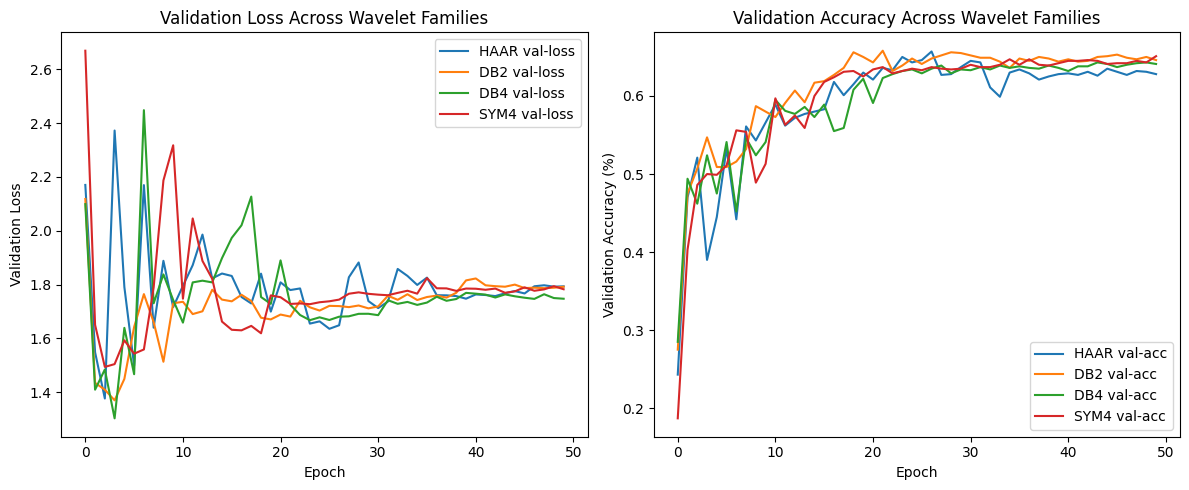

In [52]:
WAVELET_FAMILIES = ["haar", "db2", "db4", "sym4"]

def run_wavelet_family_ablation(
    wavelet_families,
    train_subset,
    test_subset,
    make_model_fn,
    get_loaders_fn,
    train_model_fn,
    evaluate_model_fn,
    eval_topk_fn,
    batch=256,
    val_frac=0.1,
    epochs=20,
    seed=123,
    device=None
):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    ablation = {}

    for w in wavelet_families:
        print(f"\nTraining wavelet family: {w}")

        train_ds = WaveletDatasetGeneral(train_subset, use_subbands=[0, 1, 2, 3], wavelet=w)
        test_ds = WaveletDatasetGeneral(test_subset, use_subbands=[0, 1, 2, 3], wavelet=w)

        train_loader, val_loader = get_loaders_fn(train_ds, val_frac=val_frac, batch=batch, seed=seed)

        model = make_model_fn()
        model, hist = train_model_fn(model, train_loader, val_loader, epochs=epochs, desc=f"WaveletFamily-{w}")

        top1 = evaluate_model_fn(model, test_ds, device=device)
        top3 = eval_topk_fn(model, test_ds, k=3, device=device)

        ablation[w] = {"top1": top1, "top3": top3, "hist": hist}

        print(f"{w}: Top-1={top1:.2f}%  Top-3={top3:.2f}%")

    best = max(ablation.keys(), key=lambda k: ablation[k]["top1"])
    print(f"\nBest wavelet family by Top-1: {best} ({ablation[best]['top1']:.2f}%)")

    return ablation

def make_wavelet_model_for_ablation():
    return WaveletDenseNet(in_ch=12, num_classes=10)

ablation_results = run_wavelet_family_ablation(
    wavelet_families=WAVELET_FAMILIES,
    train_subset=train_subset,
    test_subset=test_subset,
    make_model_fn=make_wavelet_model_for_ablation,
    get_loaders_fn=get_loaders,
    train_model_fn=train_model,
    evaluate_model_fn=evaluate_model,
    eval_topk_fn=eval_topk,
    batch=256,
    val_frac=0.1,
    epochs=50,
    seed=123,
    device=device
)

for w in WAVELET_FAMILIES:
    print(f"{w}\t{ablation_results[w]['top1']:.2f}\t{ablation_results[w]['top3']:.2f}")

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for w in WAVELET_FAMILIES:
    hist = ablation_results[w]["hist"]
    if isinstance(hist, dict) and "val_loss" in hist:
        plt.plot(hist["val_loss"], label=f"{w.upper()} val-loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Across Wavelet Families")
plt.legend()

plt.subplot(1, 2, 2)
for w in WAVELET_FAMILIES:
    hist = ablation_results[w]["hist"]
    if isinstance(hist, dict) and "val_acc" in hist:
        plt.plot(hist["val_acc"], label=f"{w.upper()} val-acc")
    elif isinstance(hist, dict) and "val_accuracy" in hist:
        plt.plot(hist["val_accuracy"], label=f"{w.upper()} val-acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Wavelet Families")
plt.legend()

plt.tight_layout()
plt.show()

haar	65.00	89.20
db2	63.55	88.00
db4	63.75	88.85
sym4	63.60	89.35


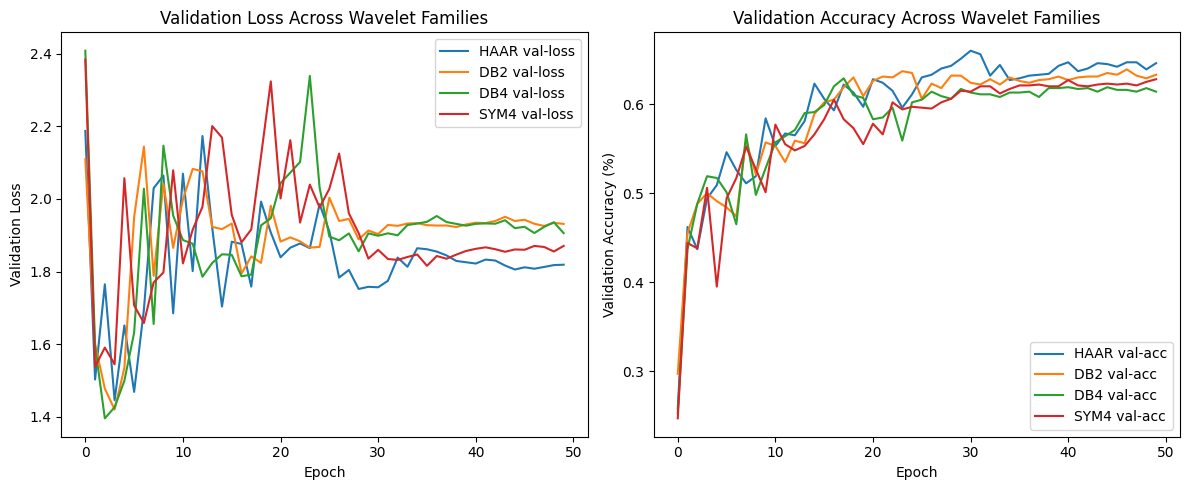

In [13]:
# training history across wavelet families from ablation

for w in WAVELET_FAMILIES:
    print(f"{w}\t{results[w]['top1']:.2f}\t{results[w]['top3']:.2f}")
    
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
for w in results:
    hist = results[w]["hist"]
    if "val_loss" in hist:
        plt.plot(hist["val_loss"], label=f"{w.upper()} val-loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Across Wavelet Families")
plt.legend()

plt.subplot(1,2,2)
for w in results:
    hist = results[w]["hist"]
    if "val_acc" in hist:
        plt.plot(hist["val_acc"], label=f"{w.upper()} val-acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Wavelet Families")
plt.legend()

plt.tight_layout()
plt.show()


# data effeciency ablation

[Baseline-n5000] ep=1 lr=0.000996 train=1.8652 val=3.2769 acc=17.20%


[Baseline-n5000] ep=2 lr=0.000984 train=1.5092 val=1.9532 acc=28.40%


[Baseline-n5000] ep=3 lr=0.000965 train=1.2916 val=1.5521 acc=44.20%


[Baseline-n5000] ep=4 lr=0.000939 train=1.0902 val=1.4277 acc=48.00%


[Baseline-n5000] ep=5 lr=0.000905 train=0.8768 val=1.5283 acc=48.60%


[Baseline-n5000] ep=6 lr=0.000866 train=0.6886 val=1.3410 acc=57.40%


[Baseline-n5000] ep=7 lr=0.000821 train=0.4697 val=2.2635 acc=46.20%


[Baseline-n5000] ep=8 lr=0.000770 train=0.3458 val=1.8138 acc=51.00%


[Baseline-n5000] ep=9 lr=0.000716 train=0.2605 val=1.7868 acc=51.00%


[Baseline-n5000] ep=10 lr=0.000658 train=0.1879 val=1.7925 acc=56.80%


[Baseline-n5000] ep=11 lr=0.000598 train=0.1311 val=2.5788 acc=47.00%


[Baseline-n5000] ep=12 lr=0.000536 train=0.0732 val=1.5934 acc=61.20%


[Baseline-n5000] ep=13 lr=0.000474 train=0.0472 val=1.7691 acc=57.80%


[Baseline-n5000] ep=14 lr=0.000412 train=0.0282 val=1.6510 acc=59.20%


[Baseline-n5000] ep=15 lr=0.000352 train=0.0118 val=1.5530 acc=60.60%


[Baseline-n5000] ep=16 lr=0.000294 train=0.0055 val=1.4651 acc=63.80%


[Baseline-n5000] ep=17 lr=0.000240 train=0.0033 val=1.4848 acc=63.40%


[Baseline-n5000] ep=18 lr=0.000189 train=0.0030 val=1.4802 acc=63.00%


[Baseline-n5000] ep=19 lr=0.000144 train=0.0027 val=1.4735 acc=63.40%


[Baseline-n5000] ep=20 lr=0.000105 train=0.0023 val=1.4789 acc=63.00%


[Baseline-n5000] ep=21 lr=0.000071 train=0.0021 val=1.4754 acc=63.60%


[Baseline-n5000] ep=22 lr=0.000045 train=0.0022 val=1.4782 acc=64.20%


[Baseline-n5000] ep=23 lr=0.000026 train=0.0021 val=1.4845 acc=62.80%


[Baseline-n5000] ep=24 lr=0.000014 train=0.0022 val=1.4881 acc=62.80%


[Baseline-n5000] ep=25 lr=0.000010 train=0.0021 val=1.4793 acc=63.60%


[FFT-n5000] ep=1 lr=0.000996 train=2.0634 val=3.9856 acc=18.60%


[FFT-n5000] ep=2 lr=0.000984 train=1.7104 val=1.9700 acc=31.40%


[FFT-n5000] ep=3 lr=0.000965 train=1.3909 val=2.3850 acc=27.40%


[FFT-n5000] ep=4 lr=0.000939 train=0.9616 val=3.9336 acc=22.40%


[FFT-n5000] ep=5 lr=0.000905 train=0.6112 val=2.8102 acc=30.20%


[FFT-n5000] ep=6 lr=0.000866 train=0.4639 val=6.6053 acc=16.00%


[FFT-n5000] ep=7 lr=0.000821 train=0.3110 val=4.0061 acc=27.80%


[FFT-n5000] ep=8 lr=0.000770 train=0.1767 val=3.2993 acc=30.60%


[FFT-n5000] ep=9 lr=0.000716 train=0.0999 val=6.2684 acc=20.00%


[FFT-n5000] ep=10 lr=0.000658 train=0.0605 val=3.4879 acc=34.60%


[FFT-n5000] ep=11 lr=0.000598 train=0.0321 val=3.4684 acc=29.40%


[FFT-n5000] ep=12 lr=0.000536 train=0.0164 val=3.5512 acc=34.40%


[FFT-n5000] ep=13 lr=0.000474 train=0.0070 val=2.6783 acc=40.60%


[FFT-n5000] ep=14 lr=0.000412 train=0.0028 val=2.6564 acc=40.40%


[FFT-n5000] ep=15 lr=0.000352 train=0.0023 val=2.6345 acc=41.40%


[FFT-n5000] ep=16 lr=0.000294 train=0.0015 val=2.6256 acc=40.60%


[FFT-n5000] ep=17 lr=0.000240 train=0.0015 val=2.6521 acc=40.80%


[FFT-n5000] ep=18 lr=0.000189 train=0.0012 val=2.6488 acc=40.40%


[FFT-n5000] ep=19 lr=0.000144 train=0.0012 val=2.6504 acc=41.40%


[FFT-n5000] ep=20 lr=0.000105 train=0.0012 val=2.6644 acc=41.40%


[FFT-n5000] ep=21 lr=0.000071 train=0.0011 val=2.6453 acc=41.20%


[FFT-n5000] ep=22 lr=0.000045 train=0.0011 val=2.6437 acc=40.40%


[FFT-n5000] ep=23 lr=0.000026 train=0.0011 val=2.6559 acc=40.80%


[FFT-n5000] ep=24 lr=0.000014 train=0.0012 val=2.6562 acc=41.00%


[FFT-n5000] ep=25 lr=0.000010 train=0.0011 val=2.6606 acc=41.40%


[WaveletALL-n5000] ep=1 lr=0.000996 train=1.8888 val=2.5448 acc=17.60%


[WaveletALL-n5000] ep=2 lr=0.000984 train=1.4626 val=1.6445 acc=39.40%


[WaveletALL-n5000] ep=3 lr=0.000965 train=1.1615 val=1.5256 acc=45.20%


[WaveletALL-n5000] ep=4 lr=0.000939 train=0.8580 val=1.6310 acc=45.00%


[WaveletALL-n5000] ep=5 lr=0.000905 train=0.5567 val=1.8936 acc=44.20%


[WaveletALL-n5000] ep=6 lr=0.000866 train=0.3669 val=1.7018 acc=50.00%


[WaveletALL-n5000] ep=7 lr=0.000821 train=0.2137 val=2.1633 acc=42.80%


[WaveletALL-n5000] ep=8 lr=0.000770 train=0.1396 val=2.0830 acc=45.80%


[WaveletALL-n5000] ep=9 lr=0.000716 train=0.1077 val=1.9378 acc=50.80%


[WaveletALL-n5000] ep=10 lr=0.000658 train=0.0759 val=2.0760 acc=48.80%


[WaveletALL-n5000] ep=11 lr=0.000598 train=0.0586 val=2.2012 acc=48.00%


[WaveletALL-n5000] ep=12 lr=0.000536 train=0.0371 val=2.1547 acc=49.80%


[WaveletALL-n5000] ep=13 lr=0.000474 train=0.0196 val=2.0389 acc=53.20%


[WaveletALL-n5000] ep=14 lr=0.000412 train=0.0094 val=2.0370 acc=53.60%


[WaveletALL-n5000] ep=15 lr=0.000352 train=0.0046 val=1.9901 acc=53.20%


[WaveletALL-n5000] ep=16 lr=0.000294 train=0.0024 val=1.9631 acc=55.20%


[WaveletALL-n5000] ep=17 lr=0.000240 train=0.0017 val=1.9624 acc=55.20%


[WaveletALL-n5000] ep=18 lr=0.000189 train=0.0015 val=1.9697 acc=54.40%


[WaveletALL-n5000] ep=19 lr=0.000144 train=0.0013 val=1.9696 acc=54.80%


[WaveletALL-n5000] ep=20 lr=0.000105 train=0.0013 val=1.9688 acc=54.80%


[WaveletALL-n5000] ep=21 lr=0.000071 train=0.0013 val=1.9762 acc=54.80%


[WaveletALL-n5000] ep=22 lr=0.000045 train=0.0012 val=1.9725 acc=54.20%


[WaveletALL-n5000] ep=23 lr=0.000026 train=0.0011 val=1.9699 acc=54.80%


[WaveletALL-n5000] ep=24 lr=0.000014 train=0.0012 val=1.9733 acc=54.80%


[WaveletALL-n5000] ep=25 lr=0.000010 train=0.0012 val=1.9826 acc=54.20%


[Baseline-n10000] ep=1 lr=0.000996 train=1.6875 val=2.6615 acc=19.50%


[Baseline-n10000] ep=2 lr=0.000984 train=1.2838 val=1.4563 acc=48.40%


[Baseline-n10000] ep=3 lr=0.000965 train=1.0719 val=1.2839 acc=54.10%


[Baseline-n10000] ep=4 lr=0.000939 train=0.8862 val=1.2581 acc=57.80%


[Baseline-n10000] ep=5 lr=0.000905 train=0.7291 val=1.2115 acc=60.30%


[Baseline-n10000] ep=6 lr=0.000866 train=0.5857 val=1.7724 acc=51.60%


[Baseline-n10000] ep=7 lr=0.000821 train=0.4671 val=1.4286 acc=56.30%


[Baseline-n10000] ep=8 lr=0.000770 train=0.3161 val=1.2883 acc=62.60%


[Baseline-n10000] ep=9 lr=0.000716 train=0.2270 val=1.1923 acc=65.70%


[Baseline-n10000] ep=10 lr=0.000658 train=0.1865 val=1.8217 acc=58.90%


[Baseline-n10000] ep=11 lr=0.000598 train=0.1107 val=1.0802 acc=70.70%


[Baseline-n10000] ep=12 lr=0.000536 train=0.0585 val=1.1706 acc=70.60%


[Baseline-n10000] ep=13 lr=0.000474 train=0.0443 val=1.1342 acc=71.50%


[Baseline-n10000] ep=14 lr=0.000412 train=0.0239 val=1.0781 acc=71.70%


[Baseline-n10000] ep=15 lr=0.000352 train=0.0129 val=1.0940 acc=73.20%


[Baseline-n10000] ep=16 lr=0.000294 train=0.0046 val=1.0528 acc=74.20%


[Baseline-n10000] ep=17 lr=0.000240 train=0.0026 val=1.0496 acc=74.60%


[Baseline-n10000] ep=18 lr=0.000189 train=0.0019 val=1.0390 acc=74.80%


[Baseline-n10000] ep=19 lr=0.000144 train=0.0017 val=1.0606 acc=74.40%


[Baseline-n10000] ep=20 lr=0.000105 train=0.0016 val=1.0503 acc=74.70%


[Baseline-n10000] ep=21 lr=0.000071 train=0.0015 val=1.0590 acc=75.00%


[Baseline-n10000] ep=22 lr=0.000045 train=0.0013 val=1.0523 acc=74.00%


[Baseline-n10000] ep=23 lr=0.000026 train=0.0013 val=1.0563 acc=74.10%


[Baseline-n10000] ep=24 lr=0.000014 train=0.0014 val=1.0426 acc=74.90%


[Baseline-n10000] ep=25 lr=0.000010 train=0.0014 val=1.0512 acc=74.30%


[FFT-n10000] ep=1 lr=0.000996 train=1.9165 val=2.7238 acc=23.20%


[FFT-n10000] ep=2 lr=0.000984 train=1.5517 val=2.0664 acc=29.90%


[FFT-n10000] ep=3 lr=0.000965 train=1.3173 val=2.7155 acc=21.30%


[FFT-n10000] ep=4 lr=0.000939 train=1.0863 val=3.3793 acc=24.20%


[FFT-n10000] ep=5 lr=0.000905 train=0.8443 val=2.8988 acc=30.80%


[FFT-n10000] ep=6 lr=0.000866 train=0.7014 val=3.7093 acc=19.60%


[FFT-n10000] ep=7 lr=0.000821 train=0.4338 val=2.3872 acc=36.70%


[FFT-n10000] ep=8 lr=0.000770 train=0.2410 val=3.4701 acc=31.20%


[FFT-n10000] ep=9 lr=0.000716 train=0.1585 val=3.7709 acc=35.60%


[FFT-n10000] ep=10 lr=0.000658 train=0.1699 val=3.0564 acc=37.40%


[FFT-n10000] ep=11 lr=0.000598 train=0.1055 val=2.8195 acc=37.70%


[FFT-n10000] ep=12 lr=0.000536 train=0.0630 val=3.1306 acc=36.20%


[FFT-n10000] ep=13 lr=0.000474 train=0.0384 val=3.4506 acc=34.30%


[FFT-n10000] ep=14 lr=0.000412 train=0.0218 val=2.9007 acc=43.30%


[FFT-n10000] ep=15 lr=0.000352 train=0.0148 val=3.2194 acc=39.40%


[FFT-n10000] ep=16 lr=0.000294 train=0.0058 val=3.0824 acc=42.60%


[FFT-n10000] ep=17 lr=0.000240 train=0.0082 val=2.7364 acc=44.70%


[FFT-n10000] ep=18 lr=0.000189 train=0.0022 val=2.6869 acc=45.50%


[FFT-n10000] ep=19 lr=0.000144 train=0.0016 val=2.6779 acc=45.80%


[FFT-n10000] ep=20 lr=0.000105 train=0.0014 val=2.6855 acc=46.10%


[FFT-n10000] ep=21 lr=0.000071 train=0.0014 val=2.6990 acc=45.70%


[FFT-n10000] ep=22 lr=0.000045 train=0.0016 val=2.6955 acc=45.60%


[FFT-n10000] ep=23 lr=0.000026 train=0.0015 val=2.7145 acc=46.20%


[FFT-n10000] ep=24 lr=0.000014 train=0.0012 val=2.6924 acc=46.10%


[FFT-n10000] ep=25 lr=0.000010 train=0.0012 val=2.6986 acc=46.10%


[WaveletALL-n10000] ep=1 lr=0.000996 train=1.7387 val=1.6572 acc=38.80%


[WaveletALL-n10000] ep=2 lr=0.000984 train=1.3133 val=1.3771 acc=50.40%


[WaveletALL-n10000] ep=3 lr=0.000965 train=1.0477 val=1.2504 acc=56.30%


[WaveletALL-n10000] ep=4 lr=0.000939 train=0.8273 val=1.4761 acc=50.30%


[WaveletALL-n10000] ep=5 lr=0.000905 train=0.6123 val=1.7223 acc=49.00%


[WaveletALL-n10000] ep=6 lr=0.000866 train=0.4006 val=1.6543 acc=53.40%


[WaveletALL-n10000] ep=7 lr=0.000821 train=0.2547 val=1.5228 acc=58.20%


[WaveletALL-n10000] ep=8 lr=0.000770 train=0.2706 val=1.5497 acc=58.20%


[WaveletALL-n10000] ep=9 lr=0.000716 train=0.1556 val=1.5397 acc=60.60%


[WaveletALL-n10000] ep=10 lr=0.000658 train=0.0875 val=1.4942 acc=62.30%


[WaveletALL-n10000] ep=11 lr=0.000598 train=0.0625 val=1.5639 acc=62.20%


[WaveletALL-n10000] ep=12 lr=0.000536 train=0.0365 val=1.5742 acc=62.10%


[WaveletALL-n10000] ep=13 lr=0.000474 train=0.0126 val=1.5136 acc=63.40%


[WaveletALL-n10000] ep=14 lr=0.000412 train=0.0039 val=1.5157 acc=63.20%


[WaveletALL-n10000] ep=15 lr=0.000352 train=0.0019 val=1.4959 acc=64.00%


[WaveletALL-n10000] ep=16 lr=0.000294 train=0.0015 val=1.4998 acc=64.30%


[WaveletALL-n10000] ep=17 lr=0.000240 train=0.0077 val=1.5021 acc=64.50%


[WaveletALL-n10000] ep=18 lr=0.000189 train=0.0022 val=1.4945 acc=64.60%


[WaveletALL-n10000] ep=19 lr=0.000144 train=0.0014 val=1.4966 acc=64.30%


[WaveletALL-n10000] ep=20 lr=0.000105 train=0.0012 val=1.5058 acc=64.60%


[WaveletALL-n10000] ep=21 lr=0.000071 train=0.0012 val=1.4909 acc=64.80%


[WaveletALL-n10000] ep=22 lr=0.000045 train=0.0011 val=1.5088 acc=64.80%


[WaveletALL-n10000] ep=23 lr=0.000026 train=0.0010 val=1.5073 acc=65.10%


[WaveletALL-n10000] ep=24 lr=0.000014 train=0.0010 val=1.5065 acc=64.10%


[WaveletALL-n10000] ep=25 lr=0.000010 train=0.0010 val=1.5096 acc=64.30%


[Baseline-n50000] ep=1 lr=0.000996 train=1.2400 val=1.0124 acc=65.36%


[Baseline-n50000] ep=2 lr=0.000984 train=0.7409 val=0.7990 acc=73.54%


[Baseline-n50000] ep=3 lr=0.000965 train=0.5288 val=0.7679 acc=73.76%


[Baseline-n50000] ep=4 lr=0.000939 train=0.3946 val=0.6353 acc=78.56%


[Baseline-n50000] ep=5 lr=0.000905 train=0.2922 val=0.7484 acc=76.96%


[Baseline-n50000] ep=6 lr=0.000866 train=0.2148 val=0.5886 acc=81.74%


[Baseline-n50000] ep=7 lr=0.000821 train=0.1536 val=0.6951 acc=79.82%


[Baseline-n50000] ep=8 lr=0.000770 train=0.1033 val=0.5440 acc=84.50%


[Baseline-n50000] ep=9 lr=0.000716 train=0.0698 val=0.6640 acc=83.26%


[Baseline-n50000] ep=10 lr=0.000658 train=0.0522 val=0.6942 acc=83.00%


[Baseline-n50000] ep=11 lr=0.000598 train=0.0375 val=0.5690 acc=85.72%


[Baseline-n50000] ep=12 lr=0.000536 train=0.0214 val=0.5726 acc=87.04%


[Baseline-n50000] ep=13 lr=0.000474 train=0.0125 val=0.6499 acc=86.20%


[Baseline-n50000] ep=14 lr=0.000412 train=0.0099 val=0.6707 acc=86.22%


[Baseline-n50000] ep=15 lr=0.000352 train=0.0040 val=0.5988 acc=87.48%


[Baseline-n50000] ep=16 lr=0.000294 train=0.0013 val=0.5497 acc=88.16%


[Baseline-n50000] ep=17 lr=0.000240 train=0.0007 val=0.5423 acc=88.76%


[Baseline-n50000] ep=18 lr=0.000189 train=0.0003 val=0.5435 acc=88.78%


[Baseline-n50000] ep=19 lr=0.000144 train=0.0003 val=0.5421 acc=88.78%


[Baseline-n50000] ep=20 lr=0.000105 train=0.0002 val=0.5469 acc=88.68%


[Baseline-n50000] ep=21 lr=0.000071 train=0.0002 val=0.5503 acc=88.60%


[Baseline-n50000] ep=22 lr=0.000045 train=0.0002 val=0.5450 acc=88.78%


[Baseline-n50000] ep=23 lr=0.000026 train=0.0002 val=0.5498 acc=88.84%


[Baseline-n50000] ep=24 lr=0.000014 train=0.0002 val=0.5496 acc=88.72%


[Baseline-n50000] ep=25 lr=0.000010 train=0.0002 val=0.5489 acc=88.64%


[FFT-n50000] ep=1 lr=0.000996 train=1.5712 val=3.0514 acc=21.94%


[FFT-n50000] ep=2 lr=0.000984 train=1.2408 val=2.0174 acc=37.28%


[FFT-n50000] ep=3 lr=0.000965 train=1.0734 val=1.5911 acc=45.28%


[FFT-n50000] ep=4 lr=0.000939 train=0.9318 val=1.2759 acc=55.32%


[FFT-n50000] ep=5 lr=0.000905 train=0.7977 val=1.5197 acc=49.38%


[FFT-n50000] ep=6 lr=0.000866 train=0.6607 val=1.5227 acc=52.14%


[FFT-n50000] ep=7 lr=0.000821 train=0.5138 val=1.4803 acc=57.70%


[FFT-n50000] ep=8 lr=0.000770 train=0.3716 val=1.6961 acc=53.70%


[FFT-n50000] ep=9 lr=0.000716 train=0.2551 val=1.9349 acc=53.96%


[FFT-n50000] ep=10 lr=0.000658 train=0.1746 val=2.2352 acc=52.56%


[FFT-n50000] ep=11 lr=0.000598 train=0.1007 val=2.0210 acc=57.76%


[FFT-n50000] ep=12 lr=0.000536 train=0.0664 val=2.1852 acc=56.46%


[FFT-n50000] ep=13 lr=0.000474 train=0.0342 val=2.2393 acc=59.50%


[FFT-n50000] ep=14 lr=0.000412 train=0.0170 val=2.2328 acc=60.28%


[FFT-n50000] ep=15 lr=0.000352 train=0.0077 val=2.2497 acc=60.42%


[FFT-n50000] ep=16 lr=0.000294 train=0.0033 val=2.2312 acc=61.54%


[FFT-n50000] ep=17 lr=0.000240 train=0.0010 val=2.2480 acc=61.80%


[FFT-n50000] ep=18 lr=0.000189 train=0.0005 val=2.2539 acc=62.00%


[FFT-n50000] ep=19 lr=0.000144 train=0.0004 val=2.2659 acc=61.94%


[FFT-n50000] ep=20 lr=0.000105 train=0.0004 val=2.2735 acc=62.10%


[FFT-n50000] ep=21 lr=0.000071 train=0.0003 val=2.2817 acc=62.06%


[FFT-n50000] ep=22 lr=0.000045 train=0.0003 val=2.2849 acc=62.12%


[FFT-n50000] ep=23 lr=0.000026 train=0.0003 val=2.2874 acc=62.06%


[FFT-n50000] ep=24 lr=0.000014 train=0.0003 val=2.2810 acc=62.10%


[FFT-n50000] ep=25 lr=0.000010 train=0.0003 val=2.2958 acc=62.24%


[WaveletALL-n50000] ep=1 lr=0.000996 train=1.3192 val=1.2415 acc=55.86%


[WaveletALL-n50000] ep=2 lr=0.000984 train=0.8465 val=0.9255 acc=68.08%


[WaveletALL-n50000] ep=3 lr=0.000965 train=0.6137 val=0.7841 acc=73.14%


[WaveletALL-n50000] ep=4 lr=0.000939 train=0.4531 val=0.8320 acc=73.08%


[WaveletALL-n50000] ep=5 lr=0.000905 train=0.3176 val=0.8704 acc=73.68%


[WaveletALL-n50000] ep=6 lr=0.000866 train=0.2147 val=0.8337 acc=75.22%


[WaveletALL-n50000] ep=7 lr=0.000821 train=0.1505 val=0.8269 acc=77.14%


[WaveletALL-n50000] ep=8 lr=0.000770 train=0.1029 val=0.9666 acc=77.10%


[WaveletALL-n50000] ep=9 lr=0.000716 train=0.0718 val=0.9429 acc=77.78%


[WaveletALL-n50000] ep=10 lr=0.000658 train=0.0484 val=0.9916 acc=78.16%


[WaveletALL-n50000] ep=11 lr=0.000598 train=0.0344 val=1.0047 acc=78.80%


[WaveletALL-n50000] ep=12 lr=0.000536 train=0.0256 val=1.0381 acc=78.52%


[WaveletALL-n50000] ep=13 lr=0.000474 train=0.0132 val=1.0210 acc=80.34%


[WaveletALL-n50000] ep=14 lr=0.000412 train=0.0050 val=0.9812 acc=81.08%


[WaveletALL-n50000] ep=15 lr=0.000352 train=0.0019 val=0.9782 acc=81.36%


[WaveletALL-n50000] ep=16 lr=0.000294 train=0.0006 val=0.9614 acc=81.80%


[WaveletALL-n50000] ep=17 lr=0.000240 train=0.0003 val=0.9716 acc=81.72%


[WaveletALL-n50000] ep=18 lr=0.000189 train=0.0002 val=0.9762 acc=81.76%


[WaveletALL-n50000] ep=19 lr=0.000144 train=0.0002 val=0.9758 acc=81.80%


[WaveletALL-n50000] ep=20 lr=0.000105 train=0.0002 val=0.9826 acc=81.94%


[WaveletALL-n50000] ep=21 lr=0.000071 train=0.0002 val=0.9778 acc=81.86%


[WaveletALL-n50000] ep=22 lr=0.000045 train=0.0002 val=0.9820 acc=81.86%


[WaveletALL-n50000] ep=23 lr=0.000026 train=0.0002 val=0.9826 acc=81.92%


[WaveletALL-n50000] ep=24 lr=0.000014 train=0.0001 val=0.9857 acc=81.80%


[WaveletALL-n50000] ep=25 lr=0.000010 train=0.0001 val=0.9856 acc=81.86%


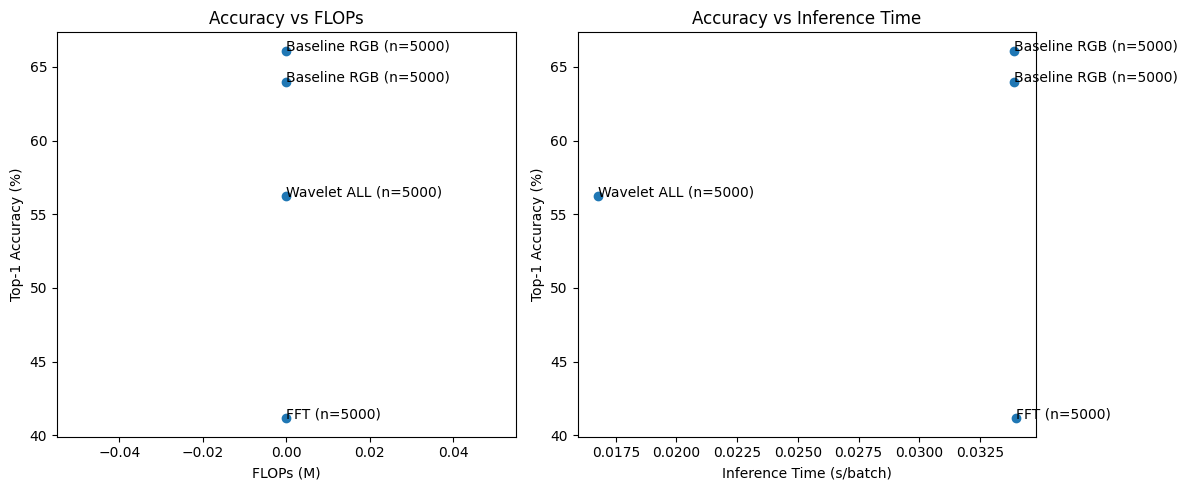


Baseline RGB (n=5000) | Top-1: 66.09% | Top-3: 90.11% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
Baseline RGB (n=5000) | Top-1: 63.97% | Top-3: 89.43% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
FFT (n=5000)       | Top-1: 41.16% | Top-3: 74.90% | Time: 0.0340s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet ALL (n=5000) | Top-1: 56.22% | Top-3: 84.63% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M


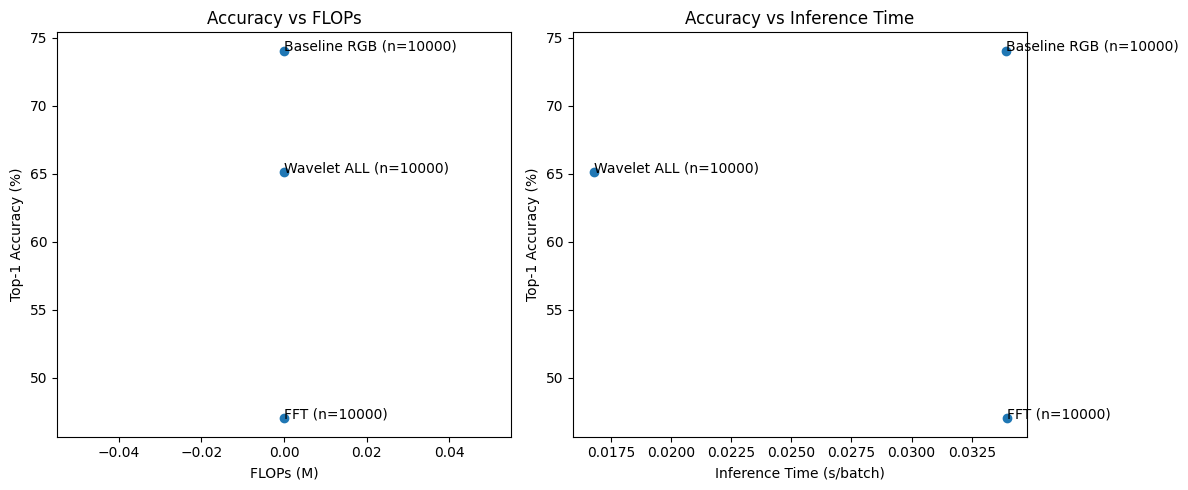


Baseline RGB (n=10000) | Top-1: 74.06% | Top-3: 93.40% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
FFT (n=10000)      | Top-1: 47.01% | Top-3: 79.15% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet ALL (n=10000) | Top-1: 65.12% | Top-3: 89.23% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M


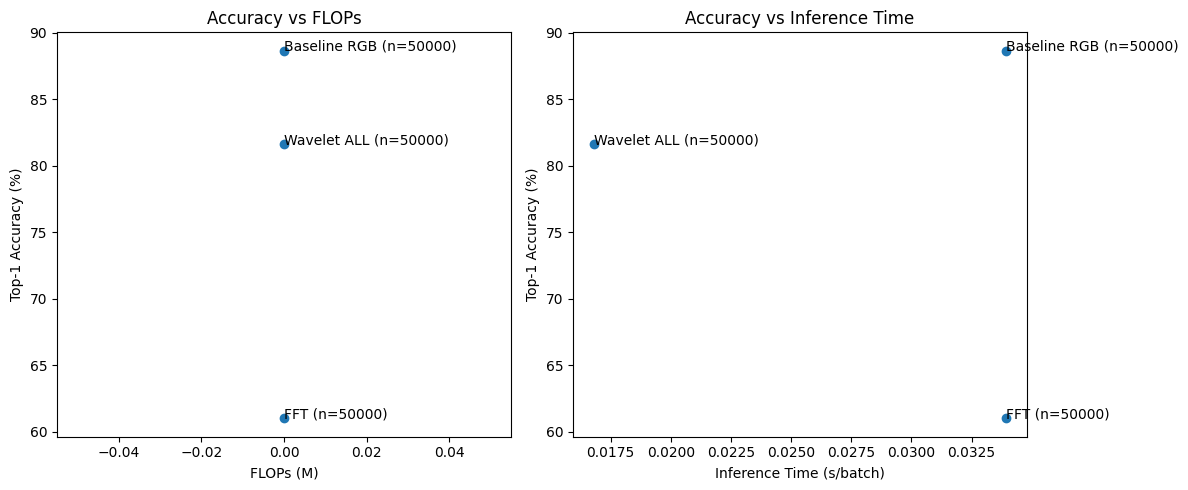


Baseline RGB (n=50000) | Top-1: 88.64% | Top-3: 98.22% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
FFT (n=50000)      | Top-1: 61.01% | Top-3: 87.76% | Time: 0.0339s | FLOPs: 0.00e+00 | Params: 6.96M
Wavelet ALL (n=50000) | Top-1: 81.60% | Top-3: 95.93% | Time: 0.0168s | FLOPs: 0.00e+00 | Params: 6.96M


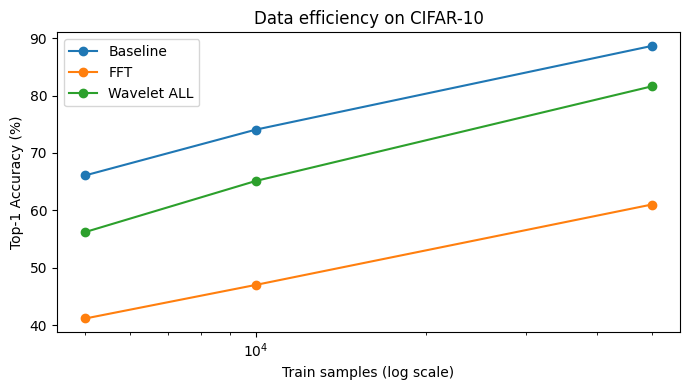

In [32]:
def make_subset(dataset, n, seed=123):
    g = torch.Generator().manual_seed(seed)
    idx = torch.randperm(len(dataset), generator=g)[:n].tolist()
    return Subset(dataset, idx)

def run_data_efficiency_suite(
    train_full,
    test_full,
    sizes,
    make_baseline_model,
    make_fft_model,
    make_wavelet_model,
    epochs=50,
    batch=256,
    val_frac=0.1,
    seed=123,
    dataset_tag_prefix="CIFAR10"
):
    for n in sizes:
        train_subset_n = make_subset(train_full, n, seed=seed)
        test_subset_full = test_full

        base_train_loader, base_val_loader = get_loaders(train_subset_n, val_frac=val_frac, batch=batch, seed=seed)
        m_base = make_baseline_model()
        m_base, _ = train_model(m_base, base_train_loader, base_val_loader, epochs=epochs, desc=f"Baseline-n{n}")
        top1 = evaluate_model(m_base, test_subset_full, device=device)
        top3 = eval_topk(m_base, test_subset_full, k=3, device=device)
        t = measure_inference_time(m_base, test_subset_full, device=device)
        f, p = compute_flops(m_base, test_subset_full, device=device)
        add_result(results, f"Baseline RGB (n={n})", "data_eff", f"{dataset_tag_prefix}-n{n}", n, len(test_subset_full), top1, top3, t, f, p)

        fft_train = FFTDataset(train_subset_n)
        fft_test = FFTDataset(test_subset_full)
        fft_train_loader, fft_val_loader = get_loaders(fft_train, val_frac=val_frac, batch=batch, seed=seed)
        m_fft = make_fft_model()
        m_fft, _ = train_model(m_fft, fft_train_loader, fft_val_loader, epochs=epochs, desc=f"FFT-n{n}")
        top1 = evaluate_model(m_fft, fft_test, device=device)
        top3 = eval_topk(m_fft, fft_test, k=3, device=device)
        t = measure_inference_time(m_fft, fft_test, device=device)
        f, p = compute_flops(m_fft, fft_test, device=device)
        add_result(results, f"FFT (n={n})", "data_eff", f"{dataset_tag_prefix}-n{n}", n, len(test_subset_full), top1, top3, t, f, p)

        w_train = WaveletDataset(train_subset_n, use_subbands=[0, 1, 2, 3])
        w_test = WaveletDataset(test_subset_full, use_subbands=[0, 1, 2, 3])
        w_train_loader, w_val_loader = get_loaders(w_train, val_frac=val_frac, batch=batch, seed=seed)
        m_w = make_wavelet_model()
        m_w, _ = train_model(m_w, w_train_loader, w_val_loader, epochs=epochs, desc=f"WaveletALL-n{n}")
        top1 = evaluate_model(m_w, w_test, device=device)
        top3 = eval_topk(m_w, w_test, k=3, device=device)
        t = measure_inference_time(m_w, w_test, device=device)
        f, p = compute_flops(m_w, w_test, device=device)
        add_result(results, f"Wavelet ALL (n={n})", "data_eff", f"{dataset_tag_prefix}-n{n}", n, len(test_subset_full), top1, top3, t, f, p)

sizes = [5000, 10000, 50000]

def make_baseline_model():
    return BaselineDenseNet(num_classes=10)

def make_fft_model():
    return FFTDenseNet(num_classes=10)

def make_wavelet_model():
    return WaveletDenseNet(in_ch=12, num_classes=10)

run_data_efficiency_suite(
    train_full=trainset,
    test_full=testset,
    sizes=sizes,
    make_baseline_model=make_baseline_model,
    make_fft_model=make_fft_model,
    make_wavelet_model=make_wavelet_model,
    epochs=25,
    batch=256,
    val_frac=0.1,
    seed=123,
    dataset_tag_prefix="CIFAR10"
)

for n in sizes:
    tag = f"CIFAR10-n{n}"
    plot_accuracy_tradeoffs(results, group="data_eff", dataset_tag=tag)
    print_summary(results, group="data_eff", dataset_tag=tag)

rows = [r for r in results if r["group"] == "data_eff" and r["dataset"].startswith("CIFAR10-n")]
rows = sorted(rows, key=lambda r: r["n_train"])
x = sorted(list(set(r["n_train"] for r in rows)))

def series(model_prefix):
    ys = []
    for n in x:
        cand = [r for r in rows if r["n_train"] == n and r["model"].startswith(model_prefix)]
        ys.append(cand[0]["top1"] if cand else float("nan"))
    return ys

plt.figure(figsize=(7, 4))
plt.plot(x, series("Baseline RGB"), marker="o", label="Baseline")
plt.plot(x, series("FFT"), marker="o", label="FFT")
plt.plot(x, series("Wavelet ALL"), marker="o", label="Wavelet ALL")
plt.xscale("log")
plt.xlabel("Train samples (log scale)")
plt.ylabel("Top-1 Accuracy (%)")
plt.title("Data efficiency on CIFAR-10")
plt.legend()
plt.tight_layout()
plt.show()


In [19]:
import math
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

@torch.no_grad()
def evaluate_model(model, dataset, batch_size=256, device=None, num_workers=2):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == "cuda"))
    model.eval().to(device)
    correct = 0
    total = 0
    with torch.inference_mode():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            out = model(x)
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.numel()
    return 100.0 * correct / max(total, 1)

@torch.no_grad()
def eval_topk(model, dataset, k=3, batch_size=256, device=None, num_workers=2):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == "cuda"))
    model.eval().to(device)
    correct = 0
    total = 0
    with torch.inference_mode():
        for x, y in loader:
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            out = model(x)
            topk = out.topk(k, dim=1).indices
            correct += (topk == y.view(-1, 1)).any(dim=1).sum().item()
            total += y.numel()
    return 100.0 * correct / max(total, 1)

@torch.no_grad()
def measure_inference_time(model, dataset, batch_size=256, device=None, warmup=10, iters=50, num_workers=2):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == "cuda"))
    x, _ = next(iter(loader))
    x = x.to(device, non_blocking=True)
    model.eval().to(device)
    with torch.inference_mode():
        for _ in range(warmup):
            _ = model(x)
    if device == "cuda":
        torch.cuda.synchronize()
        starter = torch.cuda.Event(enable_timing=True)
        ender = torch.cuda.Event(enable_timing=True)
        starter.record()
        with torch.inference_mode():
            for _ in range(iters):
                _ = model(x)
        ender.record()
        torch.cuda.synchronize()
        elapsed_ms = starter.elapsed_time(ender)
        return (elapsed_ms / 1000.0) / iters
    start = time.perf_counter()
    with torch.inference_mode():
        for _ in range(iters):
            _ = model(x)
    end = time.perf_counter()
    return (end - start) / iters

def compute_flops(model, dataset, batch_size=1, device=None, num_workers=2, include_bias=True):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.eval().to(device)
    params = count_params(model)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=(device == "cuda"))
    x, _ = next(iter(loader))
    x = x.to(device, non_blocking=True)

    try:
        from torch.utils.flop_counter import FlopCounterMode
        with FlopCounterMode(model, display=False) as fcm:
            with torch.inference_mode():
                _ = model(x)
        total_flops = int(fcm.get_total_flops())
        return total_flops, params
    except Exception:
        pass

    flops = {"total": 0}

    def conv2d_flops(m, inp, out):
        x0 = inp[0]
        B = x0.shape[0]
        Cout = out.shape[1]
        Hout = out.shape[2]
        Wout = out.shape[3]
        Cin = m.in_channels
        Kh, Kw = m.kernel_size if isinstance(m.kernel_size, tuple) else (m.kernel_size, m.kernel_size)
        groups = m.groups
        macs_per_out = (Cin // groups) * Kh * Kw
        macs = B * Hout * Wout * Cout * macs_per_out
        this = 2 * macs
        if include_bias and (m.bias is not None):
            this += B * Hout * Wout * Cout
        flops["total"] += int(this)

    def linear_flops(m, inp, out):
        x0 = inp[0]
        in_features = m.in_features
        out_features = m.out_features
        B = int(x0.numel() // in_features) if x0.numel() % in_features == 0 else x0.shape[0]
        macs = B * in_features * out_features
        this = 2 * macs
        if include_bias and (m.bias is not None):
            this += B * out_features
        flops["total"] += int(this)

    hooks = []
    for mod in model.modules():
        if isinstance(mod, nn.Conv2d):
            hooks.append(mod.register_forward_hook(conv2d_flops))
        elif isinstance(mod, nn.Linear):
            hooks.append(mod.register_forward_hook(linear_flops))

    with torch.inference_mode():
        _ = model(x)

    for h in hooks:
        h.remove()

    return int(flops["total"]), params


# extra visualizations

In [47]:
def to_numpy(img):
    img = img.detach().cpu()
    if img.min() < 0:
        img = (img + 1) / 2
    return img.permute(1, 2, 0).numpy().clip(0, 1)

x_rgb, y = test_subset[0]
x_np = to_numpy(x_rgb)

print("Label:", y)

def wavelet_transform(img):
    C, H, W = img.shape
    LL_list, LH_list, HL_list, HH_list = [], [], [], []

    for c in range(C):
        arr = img[c].cpu().numpy()
        LL, (LH, HL, HH) = pywt.dwt2(arr, "haar", mode="periodization")
        LL_list.append(LL)
        LH_list.append(LH)
        HL_list.append(HL)
        HH_list.append(HH)

    return (
        np.stack(LL_list),
        np.stack(LH_list),
        np.stack(HL_list),
        np.stack(HH_list),
    )

LL, LH, HL, HH = wavelet_transform(x_rgb)

def fft_transform(img):
    C, H, W = img.shape
    img_np = img.cpu().numpy()
    F = np.fft.fft2(img_np)
    Fshift = np.fft.fftshift(F, axes=(-2, -1))
    mag = np.abs(Fshift)
    phase = np.angle(Fshift)
    mag_disp = mag / mag.max()
    phase_disp = (phase + np.pi) / (2 * np.pi)
    return mag_disp, phase_disp

fft_mag, fft_phase = fft_transform(x_rgb)

Label: 2


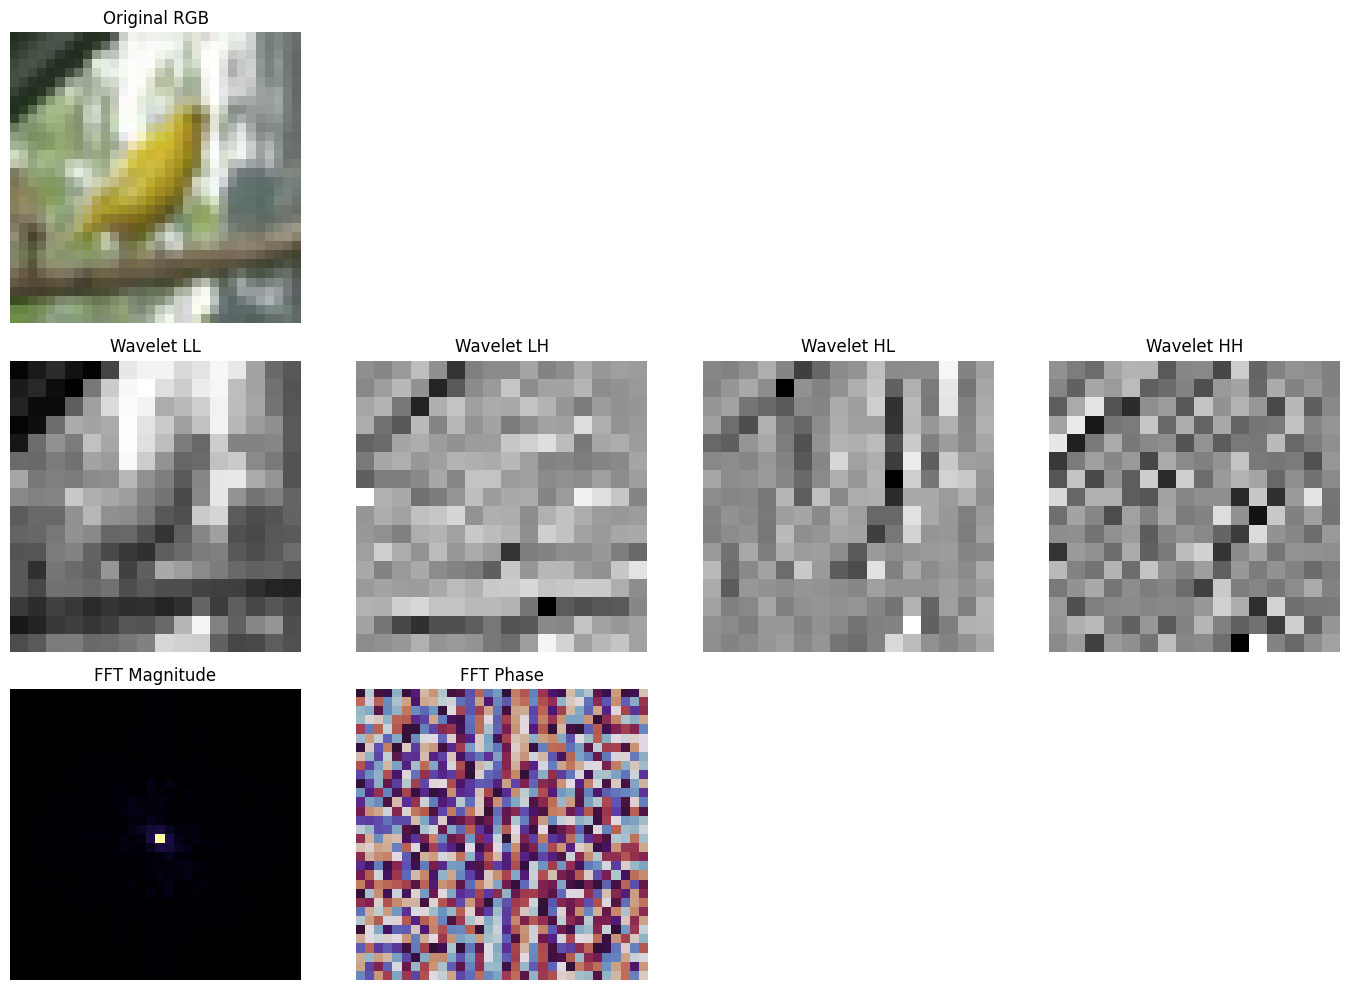

In [48]:
fig, axes = plt.subplots(3, 4, figsize=(14, 10))

axes[0, 0].imshow(x_np)
axes[0, 0].set_title("Original RGB")
axes[0, 0].axis("off")

for j in range(1, 4):
    axes[0, j].axis("off")

wave_titles = ["LL", "LH", "HL", "HH"]
wave_imgs = [LL, LH, HL, HH]

for j, w in enumerate(wave_imgs):
    axes[1, j].imshow(w.mean(axis=0), cmap="gray")
    axes[1, j].set_title(f"Wavelet {wave_titles[j]}")
    axes[1, j].axis("off")

axes[2, 0].imshow(fft_mag.mean(axis=0), cmap="inferno")
axes[2, 0].set_title("FFT Magnitude")
axes[2, 0].axis("off")

axes[2, 1].imshow(fft_phase.mean(axis=0), cmap="twilight")
axes[2, 1].set_title("FFT Phase")
axes[2, 1].axis("off")

axes[2, 2].axis("off")
axes[2, 3].axis("off")

plt.tight_layout()
plt.show()